# Combining Bilateral with Conventional Models

In [13]:

%load_ext autoreload
%autoreload 2

import torch
from tensorflow.keras.models import load_model
from os.path import join
import joblib
from pytorch_tabnet.tab_model import TabNetClassifier
from tqdm.auto import tqdm
import sys

fp_project_folder = "../../"
sys.path.append(fp_project_folder)

from src.configs.config import fp_checkpoint_folder, fp_data_folder
from src.models.bilateral.regularizer import SparseRegularizer
from src.models.bilateral.groupedSoftmaxDenseLayer import GroupedSoftmaxDenseLayer
from src.preprocessing.tabular_preprocessing import choose_output_cols
from src.models.scikitlearn.training import tune_scikitlearn_classifiers
from src.feature_visualisation.feat_extraction import format_encoder_features_for_training, \
    format_diagnosis_classification_for_training
from src.models.scikitlearn.training import train_n_evaluate_scikitlearn_classifiers
from src.misc import create_folder

from src.models.tabnet.tabnet_bilateral import TabNetBilateralClassifier, train_model_w_best_param, \
    train_tabnet_bilateral
from src.models.mlp_n_bilateral.mlp_bilateral import MLPBilateralClassifier, train_model_w_best_param, \
    train_mlp_bilateral
from src.pytorch_training.tuning import tune_model
from src.models.tabnet.tabnet_bilateral import evaluate_baseline_bilteral_models

fp_feature_folder = join(fp_checkpoint_folder, "features")
fp_col_info_file = join(fp_data_folder, "col_info.joblib")
fp_data_dfs_file = join(fp_data_folder, "data_dfs.joblib")

fp_model_checkpoints = join(fp_checkpoint_folder, "models")
fp_fc_model_checkpoint = join(fp_model_checkpoints, "fc_softmax")
fp_tabnet_bilateral_model_checkpoint = join(fp_model_checkpoints, "tabnet_bilateral")
fp_mlp_bilateral_model_checkpoint = join(fp_model_checkpoints, "mlp_bilateral")
create_folder(fp_tabnet_bilateral_model_checkpoint)
create_folder(fp_mlp_bilateral_model_checkpoint)


seed_no = 2024
batch_size = 16

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

In [5]:
data_dfs = joblib.load(fp_data_dfs_file)
col_info = joblib.load(fp_col_info_file)
col_info = choose_output_cols(col_info, bilateral=False)

## (a) Employing features extracted by the autoencoder as inputs for conventional classifiers

### Feature Extraction

In [24]:
# Load model
fc_bilateral_model = load_model(fp_fc_model_checkpoint)

In [25]:
data_dfs_ae, col_info_ae = format_encoder_features_for_training(fc_bilateral_model, data_dfs, col_info)

### Tuning

In [5]:
tuning_df_tab, best_params_tab = tune_scikitlearn_classifiers(
    param_grid={
        "n_d":[2, 4, 8], 
        "n_a":[2, 4, 8], 
        "cat_emb_dim":[2, 4], 
        "device_name":["cuda"]
    },
    **data_dfs_ae, col_info=col_info_ae, 
    Classifier=TabNetClassifier, 
    seed=seed_no
) 
display(tuning_df_tab)
print(f"Best Param: {best_params_tab}")

  0%|          | 0/18 [00:00<?, ?it/s]c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.6041  | val_0_accuracy: 0.32941 |  0:00:00s
epoch 1  | loss: 1.40771 | val_0_accuracy: 0.45882 |  0:00:01s
epoch 2  | loss: 1.18555 | val_0_accuracy: 0.45882 |  0:00:02s
epoch 3  | loss: 1.09081 | val_0_accuracy: 0.45882 |  0:00:03s
epoch 4  | loss: 1.05462 | val_0_accuracy: 0.45882 |  0:00:05s
epoch 5  | loss: 1.02807 | val_0_accuracy: 0.45882 |  0:00:06s
epoch 6  | loss: 1.01057 | val_0_accuracy: 0.45882 |  0:00:07s
epoch 7  | loss: 0.98831 | val_0_accuracy: 0.32941 |  0:00:09s
epoch 8  | loss: 0.93311 | val_0_accuracy: 0.63529 |  0:00:10s
epoch 9  | loss: 0.89146 | val_0_accuracy: 0.32941 |  0:00:12s
epoch 10 | loss: 0.82201 | val_0_accuracy: 0.48235 |  0:00:13s
epoch 11 | loss: 0.81489 | val_0_accuracy: 0.71765 |  0:00:14s
epoch 12 | loss: 0.75108 | val_0_accuracy: 0.54118 |  0:00:16s
epoch 13 | loss: 0.74713 | val_0_accuracy: 0.48235 |  0:00:17s
epoch 14 | loss: 0.72733 | val_0_accuracy: 0.25882 |  0:00:18s
epoch 15 | loss: 0.72202 | val_0_accuracy: 0.62353 |  0

c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
  6%|▌         | 1/18 [00:42<12:04, 42.62s/it]c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.3958  | val_0_accuracy: 0.12941 |  0:00:01s
epoch 1  | loss: 1.11814 | val_0_accuracy: 0.45882 |  0:00:02s
epoch 2  | loss: 1.03093 | val_0_accuracy: 0.45882 |  0:00:03s
epoch 3  | loss: 0.96442 | val_0_accuracy: 0.32941 |  0:00:04s
epoch 4  | loss: 0.98567 | val_0_accuracy: 0.45882 |  0:00:05s
epoch 5  | loss: 0.91806 | val_0_accuracy: 0.45882 |  0:00:07s
epoch 6  | loss: 0.8395  | val_0_accuracy: 0.32941 |  0:00:08s
epoch 7  | loss: 0.83552 | val_0_accuracy: 0.36471 |  0:00:09s
epoch 8  | loss: 0.81512 | val_0_accuracy: 0.32941 |  0:00:11s
epoch 9  | loss: 0.81753 | val_0_accuracy: 0.64706 |  0:00:12s
epoch 10 | loss: 0.75478 | val_0_accuracy: 0.72941 |  0:00:13s
epoch 11 | loss: 0.77055 | val_0_accuracy: 0.32941 |  0:00:15s
epoch 12 | loss: 0.72693 | val_0_accuracy: 0.32941 |  0:00:16s
epoch 13 | loss: 0.734   | val_0_accuracy: 0.32941 |  0:00:17s
epoch 14 | loss: 0.728   | val_0_accuracy: 0.32941 |  0:00:18s
epoch 15 | loss: 0.72094 | val_0_accuracy: 0.36471 |  0

c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
 11%|█         | 2/18 [01:36<13:03, 49.00s/it]c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.51031 | val_0_accuracy: 0.45882 |  0:00:01s
epoch 1  | loss: 1.13831 | val_0_accuracy: 0.45882 |  0:00:03s
epoch 2  | loss: 1.03277 | val_0_accuracy: 0.47059 |  0:00:03s
epoch 3  | loss: 0.96349 | val_0_accuracy: 0.32941 |  0:00:04s
epoch 4  | loss: 0.8907  | val_0_accuracy: 0.48235 |  0:00:06s
epoch 5  | loss: 0.81181 | val_0_accuracy: 0.32941 |  0:00:08s
epoch 6  | loss: 0.71459 | val_0_accuracy: 0.32941 |  0:00:10s
epoch 7  | loss: 0.71012 | val_0_accuracy: 0.32941 |  0:00:11s
epoch 8  | loss: 0.67693 | val_0_accuracy: 0.32941 |  0:00:12s
epoch 9  | loss: 0.67656 | val_0_accuracy: 0.32941 |  0:00:14s
epoch 10 | loss: 0.6317  | val_0_accuracy: 0.36471 |  0:00:15s
epoch 11 | loss: 0.63501 | val_0_accuracy: 0.34118 |  0:00:17s
epoch 12 | loss: 0.65732 | val_0_accuracy: 0.75294 |  0:00:18s
epoch 13 | loss: 0.58054 | val_0_accuracy: 0.4     |  0:00:18s
epoch 14 | loss: 0.59078 | val_0_accuracy: 0.24706 |  0:00:20s
epoch 15 | loss: 0.59928 | val_0_accuracy: 0.52941 |  0

c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
 17%|█▋        | 3/18 [02:29<12:44, 50.95s/it]c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.35421 | val_0_accuracy: 0.45882 |  0:00:01s
epoch 1  | loss: 1.22732 | val_0_accuracy: 0.45882 |  0:00:01s
epoch 2  | loss: 1.19179 | val_0_accuracy: 0.45882 |  0:00:02s
epoch 3  | loss: 1.16933 | val_0_accuracy: 0.45882 |  0:00:03s
epoch 4  | loss: 1.12145 | val_0_accuracy: 0.45882 |  0:00:04s
epoch 5  | loss: 1.07872 | val_0_accuracy: 0.45882 |  0:00:04s
epoch 6  | loss: 0.9932  | val_0_accuracy: 0.49412 |  0:00:05s
epoch 7  | loss: 0.92926 | val_0_accuracy: 0.62353 |  0:00:06s
epoch 8  | loss: 0.82448 | val_0_accuracy: 0.67059 |  0:00:07s
epoch 9  | loss: 0.81501 | val_0_accuracy: 0.67059 |  0:00:08s
epoch 10 | loss: 0.79096 | val_0_accuracy: 0.69412 |  0:00:08s
epoch 11 | loss: 0.75444 | val_0_accuracy: 0.72941 |  0:00:10s
epoch 12 | loss: 0.73659 | val_0_accuracy: 0.74118 |  0:00:10s
epoch 13 | loss: 0.73424 | val_0_accuracy: 0.71765 |  0:00:11s
epoch 14 | loss: 0.78561 | val_0_accuracy: 0.71765 |  0:00:12s
epoch 15 | loss: 0.76396 | val_0_accuracy: 0.72941 |  0

c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
 22%|██▏       | 4/18 [02:59<10:00, 42.91s/it]c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.37871 | val_0_accuracy: 0.45882 |  0:00:01s
epoch 1  | loss: 1.22798 | val_0_accuracy: 0.45882 |  0:00:02s
epoch 2  | loss: 1.04388 | val_0_accuracy: 0.45882 |  0:00:04s
epoch 3  | loss: 0.8873  | val_0_accuracy: 0.43529 |  0:00:05s
epoch 4  | loss: 0.98224 | val_0_accuracy: 0.36471 |  0:00:07s
epoch 5  | loss: 0.85453 | val_0_accuracy: 0.45882 |  0:00:08s
epoch 6  | loss: 0.84426 | val_0_accuracy: 0.35294 |  0:00:09s
epoch 7  | loss: 0.79408 | val_0_accuracy: 0.35294 |  0:00:10s
epoch 8  | loss: 0.75203 | val_0_accuracy: 0.32941 |  0:00:11s
epoch 9  | loss: 0.74447 | val_0_accuracy: 0.63529 |  0:00:12s
epoch 10 | loss: 0.74556 | val_0_accuracy: 0.36471 |  0:00:13s
epoch 11 | loss: 0.70087 | val_0_accuracy: 0.42353 |  0:00:14s
epoch 12 | loss: 0.67578 | val_0_accuracy: 0.50588 |  0:00:15s
epoch 13 | loss: 0.62629 | val_0_accuracy: 0.36471 |  0:00:16s
epoch 14 | loss: 0.65764 | val_0_accuracy: 0.4     |  0:00:18s
epoch 15 | loss: 0.66674 | val_0_accuracy: 0.36471 |  0

c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
 28%|██▊       | 5/18 [03:42<09:13, 42.60s/it]c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.40321 | val_0_accuracy: 0.45882 |  0:00:00s
epoch 1  | loss: 1.22619 | val_0_accuracy: 0.45882 |  0:00:01s
epoch 2  | loss: 1.21195 | val_0_accuracy: 0.45882 |  0:00:02s
epoch 3  | loss: 1.12545 | val_0_accuracy: 0.18824 |  0:00:03s
epoch 4  | loss: 1.00019 | val_0_accuracy: 0.41176 |  0:00:05s
epoch 5  | loss: 0.90513 | val_0_accuracy: 0.45882 |  0:00:06s
epoch 6  | loss: 0.84344 | val_0_accuracy: 0.52941 |  0:00:07s
epoch 7  | loss: 0.77711 | val_0_accuracy: 0.50588 |  0:00:08s
epoch 8  | loss: 0.6841  | val_0_accuracy: 0.63529 |  0:00:09s
epoch 9  | loss: 0.65846 | val_0_accuracy: 0.71765 |  0:00:10s
epoch 10 | loss: 0.68589 | val_0_accuracy: 0.52941 |  0:00:11s
epoch 11 | loss: 0.66414 | val_0_accuracy: 0.54118 |  0:00:13s
epoch 12 | loss: 0.6214  | val_0_accuracy: 0.49412 |  0:00:13s
epoch 13 | loss: 0.63128 | val_0_accuracy: 0.68235 |  0:00:14s
epoch 14 | loss: 0.60637 | val_0_accuracy: 0.72941 |  0:00:15s
epoch 15 | loss: 0.57481 | val_0_accuracy: 0.72941 |  0

c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
 33%|███▎      | 6/18 [04:19<08:09, 40.81s/it]c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.44754 | val_0_accuracy: 0.45882 |  0:00:01s
epoch 1  | loss: 1.27082 | val_0_accuracy: 0.45882 |  0:00:03s
epoch 2  | loss: 1.11158 | val_0_accuracy: 0.45882 |  0:00:04s
epoch 3  | loss: 1.1111  | val_0_accuracy: 0.45882 |  0:00:06s
epoch 4  | loss: 0.98917 | val_0_accuracy: 0.45882 |  0:00:09s
epoch 5  | loss: 0.98352 | val_0_accuracy: 0.45882 |  0:00:10s
epoch 6  | loss: 0.90241 | val_0_accuracy: 0.63529 |  0:00:12s
epoch 7  | loss: 0.89298 | val_0_accuracy: 0.34118 |  0:00:13s
epoch 8  | loss: 0.82351 | val_0_accuracy: 0.51765 |  0:00:14s
epoch 9  | loss: 0.82992 | val_0_accuracy: 0.69412 |  0:00:17s
epoch 10 | loss: 0.76842 | val_0_accuracy: 0.43529 |  0:00:18s
epoch 11 | loss: 0.81233 | val_0_accuracy: 0.75294 |  0:00:20s
epoch 12 | loss: 0.74454 | val_0_accuracy: 0.63529 |  0:00:20s
epoch 13 | loss: 0.73081 | val_0_accuracy: 0.76471 |  0:00:22s
epoch 14 | loss: 0.72655 | val_0_accuracy: 0.74118 |  0:00:24s
epoch 15 | loss: 0.7202  | val_0_accuracy: 0.70588 |  0

c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
 39%|███▉      | 7/18 [05:23<08:52, 48.45s/it]c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.55704 | val_0_accuracy: 0.45882 |  0:00:02s
epoch 1  | loss: 1.27553 | val_0_accuracy: 0.45882 |  0:00:03s
epoch 2  | loss: 1.08164 | val_0_accuracy: 0.45882 |  0:00:04s
epoch 3  | loss: 1.02379 | val_0_accuracy: 0.45882 |  0:00:05s
epoch 4  | loss: 0.9281  | val_0_accuracy: 0.45882 |  0:00:06s
epoch 5  | loss: 0.87244 | val_0_accuracy: 0.72941 |  0:00:08s
epoch 6  | loss: 0.77517 | val_0_accuracy: 0.47059 |  0:00:10s
epoch 7  | loss: 0.75967 | val_0_accuracy: 0.42353 |  0:00:11s
epoch 8  | loss: 0.73074 | val_0_accuracy: 0.48235 |  0:00:13s
epoch 9  | loss: 0.7648  | val_0_accuracy: 0.68235 |  0:00:14s
epoch 10 | loss: 0.70851 | val_0_accuracy: 0.4     |  0:00:16s
epoch 11 | loss: 0.69551 | val_0_accuracy: 0.24706 |  0:00:18s
epoch 12 | loss: 0.64815 | val_0_accuracy: 0.29412 |  0:00:19s
epoch 13 | loss: 0.63532 | val_0_accuracy: 0.50588 |  0:00:21s
epoch 14 | loss: 0.62944 | val_0_accuracy: 0.47059 |  0:00:22s
epoch 15 | loss: 0.5632  | val_0_accuracy: 0.56471 |  0

c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
 44%|████▍     | 8/18 [05:48<06:49, 40.96s/it]c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.45537 | val_0_accuracy: 0.45882 |  0:00:01s
epoch 1  | loss: 1.23344 | val_0_accuracy: 0.45882 |  0:00:02s
epoch 2  | loss: 1.20962 | val_0_accuracy: 0.45882 |  0:00:04s
epoch 3  | loss: 1.15069 | val_0_accuracy: 0.45882 |  0:00:06s
epoch 4  | loss: 1.09253 | val_0_accuracy: 0.45882 |  0:00:07s
epoch 5  | loss: 1.01883 | val_0_accuracy: 0.12941 |  0:00:08s
epoch 6  | loss: 0.92436 | val_0_accuracy: 0.71765 |  0:00:09s
epoch 7  | loss: 0.88057 | val_0_accuracy: 0.68235 |  0:00:10s
epoch 8  | loss: 0.82018 | val_0_accuracy: 0.32941 |  0:00:12s
epoch 9  | loss: 0.79241 | val_0_accuracy: 0.70588 |  0:00:14s
epoch 10 | loss: 0.70579 | val_0_accuracy: 0.44706 |  0:00:15s
epoch 11 | loss: 0.7039  | val_0_accuracy: 0.36471 |  0:00:17s
epoch 12 | loss: 0.68647 | val_0_accuracy: 0.51765 |  0:00:19s
epoch 13 | loss: 0.67322 | val_0_accuracy: 0.65882 |  0:00:21s
epoch 14 | loss: 0.67551 | val_0_accuracy: 0.62353 |  0:00:22s
epoch 15 | loss: 0.6405  | val_0_accuracy: 0.65882 |  0

c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
 50%|█████     | 9/18 [07:07<07:55, 52.84s/it]c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.6041  | val_0_accuracy: 0.32941 |  0:00:01s
epoch 1  | loss: 1.40771 | val_0_accuracy: 0.45882 |  0:00:04s
epoch 2  | loss: 1.18555 | val_0_accuracy: 0.45882 |  0:00:06s
epoch 3  | loss: 1.09081 | val_0_accuracy: 0.45882 |  0:00:08s
epoch 4  | loss: 1.05462 | val_0_accuracy: 0.45882 |  0:00:10s
epoch 5  | loss: 1.02807 | val_0_accuracy: 0.45882 |  0:00:13s
epoch 6  | loss: 1.01057 | val_0_accuracy: 0.45882 |  0:00:14s
epoch 7  | loss: 0.98831 | val_0_accuracy: 0.32941 |  0:00:16s
epoch 8  | loss: 0.93311 | val_0_accuracy: 0.63529 |  0:00:18s
epoch 9  | loss: 0.89146 | val_0_accuracy: 0.32941 |  0:00:21s
epoch 10 | loss: 0.82201 | val_0_accuracy: 0.48235 |  0:00:24s
epoch 11 | loss: 0.81489 | val_0_accuracy: 0.71765 |  0:00:27s
epoch 12 | loss: 0.75108 | val_0_accuracy: 0.54118 |  0:00:28s
epoch 13 | loss: 0.74713 | val_0_accuracy: 0.48235 |  0:00:31s
epoch 14 | loss: 0.72733 | val_0_accuracy: 0.25882 |  0:00:34s
epoch 15 | loss: 0.72202 | val_0_accuracy: 0.62353 |  0

c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
 56%|█████▌    | 10/18 [08:14<07:38, 57.35s/it]c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.3958  | val_0_accuracy: 0.12941 |  0:00:01s
epoch 1  | loss: 1.11814 | val_0_accuracy: 0.45882 |  0:00:04s
epoch 2  | loss: 1.03093 | val_0_accuracy: 0.45882 |  0:00:06s
epoch 3  | loss: 0.96442 | val_0_accuracy: 0.32941 |  0:00:10s
epoch 4  | loss: 0.98567 | val_0_accuracy: 0.45882 |  0:00:13s
epoch 5  | loss: 0.91806 | val_0_accuracy: 0.45882 |  0:00:15s
epoch 6  | loss: 0.8395  | val_0_accuracy: 0.32941 |  0:00:16s
epoch 7  | loss: 0.83552 | val_0_accuracy: 0.36471 |  0:00:17s
epoch 8  | loss: 0.81512 | val_0_accuracy: 0.32941 |  0:00:19s
epoch 9  | loss: 0.81753 | val_0_accuracy: 0.64706 |  0:00:20s
epoch 10 | loss: 0.75478 | val_0_accuracy: 0.72941 |  0:00:21s
epoch 11 | loss: 0.77055 | val_0_accuracy: 0.32941 |  0:00:22s
epoch 12 | loss: 0.72693 | val_0_accuracy: 0.32941 |  0:00:23s
epoch 13 | loss: 0.734   | val_0_accuracy: 0.32941 |  0:00:24s
epoch 14 | loss: 0.728   | val_0_accuracy: 0.32941 |  0:00:26s
epoch 15 | loss: 0.72094 | val_0_accuracy: 0.36471 |  0

c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
 61%|██████    | 11/18 [09:08<06:33, 56.22s/it]c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.51031 | val_0_accuracy: 0.45882 |  0:00:00s
epoch 1  | loss: 1.13831 | val_0_accuracy: 0.45882 |  0:00:01s
epoch 2  | loss: 1.03277 | val_0_accuracy: 0.47059 |  0:00:02s
epoch 3  | loss: 0.96349 | val_0_accuracy: 0.32941 |  0:00:03s
epoch 4  | loss: 0.8907  | val_0_accuracy: 0.48235 |  0:00:04s
epoch 5  | loss: 0.81181 | val_0_accuracy: 0.32941 |  0:00:05s
epoch 6  | loss: 0.71459 | val_0_accuracy: 0.32941 |  0:00:06s
epoch 7  | loss: 0.71012 | val_0_accuracy: 0.32941 |  0:00:07s
epoch 8  | loss: 0.67693 | val_0_accuracy: 0.32941 |  0:00:08s
epoch 9  | loss: 0.67656 | val_0_accuracy: 0.32941 |  0:00:09s
epoch 10 | loss: 0.6317  | val_0_accuracy: 0.36471 |  0:00:10s
epoch 11 | loss: 0.63501 | val_0_accuracy: 0.34118 |  0:00:11s
epoch 12 | loss: 0.65732 | val_0_accuracy: 0.75294 |  0:00:12s
epoch 13 | loss: 0.58054 | val_0_accuracy: 0.4     |  0:00:13s
epoch 14 | loss: 0.59078 | val_0_accuracy: 0.24706 |  0:00:15s
epoch 15 | loss: 0.59928 | val_0_accuracy: 0.52941 |  0

c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
 67%|██████▋   | 12/18 [09:58<05:26, 54.46s/it]c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.35421 | val_0_accuracy: 0.45882 |  0:00:01s
epoch 1  | loss: 1.22732 | val_0_accuracy: 0.45882 |  0:00:01s
epoch 2  | loss: 1.19179 | val_0_accuracy: 0.45882 |  0:00:02s
epoch 3  | loss: 1.16933 | val_0_accuracy: 0.45882 |  0:00:03s
epoch 4  | loss: 1.12145 | val_0_accuracy: 0.45882 |  0:00:04s
epoch 5  | loss: 1.07872 | val_0_accuracy: 0.45882 |  0:00:05s
epoch 6  | loss: 0.9932  | val_0_accuracy: 0.49412 |  0:00:07s
epoch 7  | loss: 0.92926 | val_0_accuracy: 0.62353 |  0:00:07s
epoch 8  | loss: 0.82448 | val_0_accuracy: 0.67059 |  0:00:09s
epoch 9  | loss: 0.81501 | val_0_accuracy: 0.67059 |  0:00:09s
epoch 10 | loss: 0.79096 | val_0_accuracy: 0.69412 |  0:00:11s
epoch 11 | loss: 0.75444 | val_0_accuracy: 0.72941 |  0:00:12s
epoch 12 | loss: 0.73659 | val_0_accuracy: 0.74118 |  0:00:13s
epoch 13 | loss: 0.73424 | val_0_accuracy: 0.71765 |  0:00:14s
epoch 14 | loss: 0.78561 | val_0_accuracy: 0.71765 |  0:00:15s
epoch 15 | loss: 0.76396 | val_0_accuracy: 0.72941 |  0

c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
 72%|███████▏  | 13/18 [10:26<03:51, 46.24s/it]c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.37871 | val_0_accuracy: 0.45882 |  0:00:00s
epoch 1  | loss: 1.22798 | val_0_accuracy: 0.45882 |  0:00:01s
epoch 2  | loss: 1.04388 | val_0_accuracy: 0.45882 |  0:00:02s
epoch 3  | loss: 0.8873  | val_0_accuracy: 0.43529 |  0:00:03s
epoch 4  | loss: 0.98224 | val_0_accuracy: 0.36471 |  0:00:03s
epoch 5  | loss: 0.85453 | val_0_accuracy: 0.45882 |  0:00:04s
epoch 6  | loss: 0.84426 | val_0_accuracy: 0.35294 |  0:00:05s
epoch 7  | loss: 0.79408 | val_0_accuracy: 0.35294 |  0:00:05s
epoch 8  | loss: 0.75203 | val_0_accuracy: 0.32941 |  0:00:06s
epoch 9  | loss: 0.74447 | val_0_accuracy: 0.63529 |  0:00:07s
epoch 10 | loss: 0.74556 | val_0_accuracy: 0.36471 |  0:00:08s
epoch 11 | loss: 0.70087 | val_0_accuracy: 0.42353 |  0:00:09s
epoch 12 | loss: 0.67578 | val_0_accuracy: 0.50588 |  0:00:10s
epoch 13 | loss: 0.62629 | val_0_accuracy: 0.36471 |  0:00:12s
epoch 14 | loss: 0.65764 | val_0_accuracy: 0.4     |  0:00:14s
epoch 15 | loss: 0.66674 | val_0_accuracy: 0.36471 |  0

c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
 78%|███████▊  | 14/18 [11:10<03:02, 45.61s/it]c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.40321 | val_0_accuracy: 0.45882 |  0:00:00s
epoch 1  | loss: 1.22619 | val_0_accuracy: 0.45882 |  0:00:01s
epoch 2  | loss: 1.21195 | val_0_accuracy: 0.45882 |  0:00:02s
epoch 3  | loss: 1.12545 | val_0_accuracy: 0.18824 |  0:00:04s
epoch 4  | loss: 1.00019 | val_0_accuracy: 0.41176 |  0:00:05s
epoch 5  | loss: 0.90513 | val_0_accuracy: 0.45882 |  0:00:06s
epoch 6  | loss: 0.84344 | val_0_accuracy: 0.52941 |  0:00:07s
epoch 7  | loss: 0.77711 | val_0_accuracy: 0.50588 |  0:00:08s
epoch 8  | loss: 0.6841  | val_0_accuracy: 0.63529 |  0:00:09s
epoch 9  | loss: 0.65846 | val_0_accuracy: 0.71765 |  0:00:11s
epoch 10 | loss: 0.68589 | val_0_accuracy: 0.52941 |  0:00:12s
epoch 11 | loss: 0.66414 | val_0_accuracy: 0.54118 |  0:00:13s
epoch 12 | loss: 0.6214  | val_0_accuracy: 0.49412 |  0:00:14s
epoch 13 | loss: 0.63128 | val_0_accuracy: 0.68235 |  0:00:15s
epoch 14 | loss: 0.60637 | val_0_accuracy: 0.72941 |  0:00:17s
epoch 15 | loss: 0.57481 | val_0_accuracy: 0.72941 |  0

c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
 83%|████████▎ | 15/18 [11:56<02:17, 45.90s/it]c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.44754 | val_0_accuracy: 0.45882 |  0:00:01s
epoch 1  | loss: 1.27082 | val_0_accuracy: 0.45882 |  0:00:02s
epoch 2  | loss: 1.11158 | val_0_accuracy: 0.45882 |  0:00:03s
epoch 3  | loss: 1.1111  | val_0_accuracy: 0.45882 |  0:00:05s
epoch 4  | loss: 0.98917 | val_0_accuracy: 0.45882 |  0:00:07s
epoch 5  | loss: 0.98352 | val_0_accuracy: 0.45882 |  0:00:08s
epoch 6  | loss: 0.90241 | val_0_accuracy: 0.63529 |  0:00:09s
epoch 7  | loss: 0.89298 | val_0_accuracy: 0.34118 |  0:00:11s
epoch 8  | loss: 0.82351 | val_0_accuracy: 0.51765 |  0:00:12s
epoch 9  | loss: 0.82992 | val_0_accuracy: 0.69412 |  0:00:12s
epoch 10 | loss: 0.76842 | val_0_accuracy: 0.43529 |  0:00:14s
epoch 11 | loss: 0.81233 | val_0_accuracy: 0.75294 |  0:00:16s
epoch 12 | loss: 0.74454 | val_0_accuracy: 0.63529 |  0:00:17s
epoch 13 | loss: 0.73081 | val_0_accuracy: 0.76471 |  0:00:19s
epoch 14 | loss: 0.72655 | val_0_accuracy: 0.74118 |  0:00:21s
epoch 15 | loss: 0.7202  | val_0_accuracy: 0.70588 |  0

c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
 89%|████████▉ | 16/18 [13:18<01:53, 56.58s/it]c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.55704 | val_0_accuracy: 0.45882 |  0:00:01s
epoch 1  | loss: 1.27553 | val_0_accuracy: 0.45882 |  0:00:03s
epoch 2  | loss: 1.08164 | val_0_accuracy: 0.45882 |  0:00:04s
epoch 3  | loss: 1.02379 | val_0_accuracy: 0.45882 |  0:00:06s
epoch 4  | loss: 0.9281  | val_0_accuracy: 0.45882 |  0:00:08s
epoch 5  | loss: 0.87244 | val_0_accuracy: 0.72941 |  0:00:10s
epoch 6  | loss: 0.77517 | val_0_accuracy: 0.47059 |  0:00:13s
epoch 7  | loss: 0.75967 | val_0_accuracy: 0.42353 |  0:00:17s
epoch 8  | loss: 0.73074 | val_0_accuracy: 0.48235 |  0:00:19s
epoch 9  | loss: 0.7648  | val_0_accuracy: 0.68235 |  0:00:21s
epoch 10 | loss: 0.70851 | val_0_accuracy: 0.4     |  0:00:23s
epoch 11 | loss: 0.69551 | val_0_accuracy: 0.24706 |  0:00:25s
epoch 12 | loss: 0.64815 | val_0_accuracy: 0.29412 |  0:00:27s
epoch 13 | loss: 0.63532 | val_0_accuracy: 0.50588 |  0:00:30s
epoch 14 | loss: 0.62944 | val_0_accuracy: 0.47059 |  0:00:31s
epoch 15 | loss: 0.5632  | val_0_accuracy: 0.56471 |  0

c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
 94%|█████████▍| 17/18 [13:54<00:50, 50.28s/it]c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.45537 | val_0_accuracy: 0.45882 |  0:00:01s
epoch 1  | loss: 1.23344 | val_0_accuracy: 0.45882 |  0:00:03s
epoch 2  | loss: 1.20962 | val_0_accuracy: 0.45882 |  0:00:05s
epoch 3  | loss: 1.15069 | val_0_accuracy: 0.45882 |  0:00:06s
epoch 4  | loss: 1.09253 | val_0_accuracy: 0.45882 |  0:00:06s
epoch 5  | loss: 1.01883 | val_0_accuracy: 0.12941 |  0:00:08s
epoch 6  | loss: 0.92436 | val_0_accuracy: 0.71765 |  0:00:09s
epoch 7  | loss: 0.88057 | val_0_accuracy: 0.68235 |  0:00:10s
epoch 8  | loss: 0.82018 | val_0_accuracy: 0.32941 |  0:00:11s
epoch 9  | loss: 0.79241 | val_0_accuracy: 0.70588 |  0:00:12s
epoch 10 | loss: 0.70579 | val_0_accuracy: 0.44706 |  0:00:14s
epoch 11 | loss: 0.7039  | val_0_accuracy: 0.36471 |  0:00:15s
epoch 12 | loss: 0.68647 | val_0_accuracy: 0.51765 |  0:00:16s
epoch 13 | loss: 0.67322 | val_0_accuracy: 0.65882 |  0:00:18s
epoch 14 | loss: 0.67551 | val_0_accuracy: 0.62353 |  0:00:19s
epoch 15 | loss: 0.6405  | val_0_accuracy: 0.65882 |  0

c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
100%|██████████| 18/18 [14:37<00:00, 48.77s/it]
e:\WLR\OneDrive - Nanyang Technological University\PhD\2_Projects\Eye\bilateral\code\src\models\scikitlearn\training.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original

,cat_emb_dim,device_name,n_a,n_d,val_acc,time/s,best
0,2,cuda,2,2,0.753,42.019738,False
1,2,cuda,2,4,0.882,52.293498,True
2,2,cuda,2,8,0.871,52.681761,False
3,2,cuda,4,2,0.776,29.928428,False
4,2,cuda,4,4,0.812,41.643765,False
5,2,cuda,4,8,0.871,36.510244,False
6,2,cuda,8,2,0.835,63.627769,False
7,2,cuda,8,4,0.729,24.091327,False
8,2,cuda,8,8,0.871,77.950233,False
9,4,cuda,2,2,0.753,66.016881,False


Best Param: {'n_d': 4, 'n_a': 2, 'cat_emb_dim': 2, 'device_name': 'cuda'}


### Training

In [26]:
best_params_tab = {'n_d': 4, 'n_a': 2, 'cat_emb_dim': 2, 'device_name': 'cuda'}
tab, tab_pred_df, tab_perf_df = train_n_evaluate_scikitlearn_classifiers(
    param=best_params_tab,
    **data_dfs_ae, col_info=col_info_ae, Classifier=TabNetClassifier, seed=seed_no
)
display(tab_perf_df)

c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.3958  | val_0_accuracy: 0.12941 |  0:00:00s
epoch 1  | loss: 1.11814 | val_0_accuracy: 0.45882 |  0:00:01s
epoch 2  | loss: 1.03093 | val_0_accuracy: 0.45882 |  0:00:02s
epoch 3  | loss: 0.96442 | val_0_accuracy: 0.32941 |  0:00:03s
epoch 4  | loss: 0.98567 | val_0_accuracy: 0.45882 |  0:00:04s
epoch 5  | loss: 0.91806 | val_0_accuracy: 0.45882 |  0:00:04s
epoch 6  | loss: 0.8395  | val_0_accuracy: 0.32941 |  0:00:05s
epoch 7  | loss: 0.83552 | val_0_accuracy: 0.36471 |  0:00:06s
epoch 8  | loss: 0.81512 | val_0_accuracy: 0.32941 |  0:00:07s
epoch 9  | loss: 0.81753 | val_0_accuracy: 0.64706 |  0:00:07s
epoch 10 | loss: 0.75478 | val_0_accuracy: 0.72941 |  0:00:08s
epoch 11 | loss: 0.77055 | val_0_accuracy: 0.32941 |  0:00:09s
epoch 12 | loss: 0.72693 | val_0_accuracy: 0.32941 |  0:00:09s
epoch 13 | loss: 0.734   | val_0_accuracy: 0.32941 |  0:00:10s
epoch 14 | loss: 0.728   | val_0_accuracy: 0.32941 |  0:00:11s
epoch 15 | loss: 0.72094 | val_0_accuracy: 0.36471 |  0

c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


,train,valid,test
Accuracy,0.847,0.882,0.835
Accuracy Total_Time_1.0,0.000,0.000,NaN
Accuracy Total_Time_13.0,0.523,0.727,0.667
Accuracy Total_Time_26.0,0.879,0.964,0.778
Accuracy Total_Time_4.33,0.638,0.400,0.625
Accuracy Total_Time_52.0,0.973,0.974,0.974
Total_Time_1.0 Proportion,0.004,0.002,0.000
Total_Time_13.0 Proportion,0.131,0.013,0.014
Total_Time_26.0 Proportion,0.215,0.033,0.032
Total_Time_4.33 Proportion,0.055,0.006,0.009


## (b) Do conventional classifiers benefit from the same “diagnosis classifier” used in the proposed framework?

### Feature Extraction

In [3]:
# Load model
fc_bilateral_model = load_model(fp_fc_model_checkpoint)

In [20]:
data_dfs_ic, col_info_ic = format_diagnosis_classification_for_training(
    model=fc_bilateral_model, data_dfs=data_dfs, col_info=col_info)

### Tuning

In [21]:
tuning_df_tab, best_params_tab = tune_scikitlearn_classifiers(
    param_grid={
        "n_d":[2, 4, 8], 
        "n_a":[2, 4, 8], 
        "cat_emb_dim":[2, 4], 
        "device_name":["cuda"]
    },
    **data_dfs_ic, col_info=col_info_ic, 
    Classifier=TabNetClassifier, 
    seed=seed_no
) 
display(tuning_df_tab)
print(f"Best Param: {best_params_tab}")

  0%|          | 0/18 [00:00<?, ?it/s]c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.5798  | val_0_accuracy: 0.32941 |  0:00:00s
epoch 1  | loss: 1.20382 | val_0_accuracy: 0.55294 |  0:00:01s
epoch 2  | loss: 1.03698 | val_0_accuracy: 0.67059 |  0:00:01s
epoch 3  | loss: 0.90492 | val_0_accuracy: 0.69412 |  0:00:02s
epoch 4  | loss: 0.90062 | val_0_accuracy: 0.68235 |  0:00:02s
epoch 5  | loss: 0.87524 | val_0_accuracy: 0.70588 |  0:00:03s
epoch 6  | loss: 0.85892 | val_0_accuracy: 0.68235 |  0:00:03s
epoch 7  | loss: 0.89003 | val_0_accuracy: 0.67059 |  0:00:04s
epoch 8  | loss: 0.88896 | val_0_accuracy: 0.68235 |  0:00:04s
epoch 9  | loss: 0.88265 | val_0_accuracy: 0.68235 |  0:00:05s
epoch 10 | loss: 0.84039 | val_0_accuracy: 0.68235 |  0:00:05s
epoch 11 | loss: 0.79226 | val_0_accuracy: 0.64706 |  0:00:06s
epoch 12 | loss: 0.78611 | val_0_accuracy: 0.68235 |  0:00:06s
epoch 13 | loss: 0.83496 | val_0_accuracy: 0.68235 |  0:00:07s
epoch 14 | loss: 0.79982 | val_0_accuracy: 0.68235 |  0:00:07s
epoch 15 | loss: 0.74451 | val_0_accuracy: 0.74118 |  0

c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
  6%|▌         | 1/18 [00:22<06:24, 22.60s/it]c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.25967 | val_0_accuracy: 0.47059 |  0:00:00s
epoch 1  | loss: 0.9805  | val_0_accuracy: 0.58824 |  0:00:01s
epoch 2  | loss: 0.87879 | val_0_accuracy: 0.65882 |  0:00:01s
epoch 3  | loss: 0.83302 | val_0_accuracy: 0.72941 |  0:00:02s
epoch 4  | loss: 0.82121 | val_0_accuracy: 0.74118 |  0:00:02s
epoch 5  | loss: 0.78337 | val_0_accuracy: 0.72941 |  0:00:03s
epoch 6  | loss: 0.81024 | val_0_accuracy: 0.72941 |  0:00:03s
epoch 7  | loss: 0.80735 | val_0_accuracy: 0.72941 |  0:00:04s
epoch 8  | loss: 0.74212 | val_0_accuracy: 0.74118 |  0:00:04s
epoch 9  | loss: 0.72241 | val_0_accuracy: 0.76471 |  0:00:05s
epoch 10 | loss: 0.73087 | val_0_accuracy: 0.77647 |  0:00:05s
epoch 11 | loss: 0.6857  | val_0_accuracy: 0.77647 |  0:00:06s
epoch 12 | loss: 0.66721 | val_0_accuracy: 0.8     |  0:00:07s
epoch 13 | loss: 0.64802 | val_0_accuracy: 0.78824 |  0:00:07s
epoch 14 | loss: 0.6428  | val_0_accuracy: 0.78824 |  0:00:08s
epoch 15 | loss: 0.68801 | val_0_accuracy: 0.78824 |  0

c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
 11%|█         | 2/18 [00:40<05:13, 19.58s/it]c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.25215 | val_0_accuracy: 0.45882 |  0:00:00s
epoch 1  | loss: 0.99276 | val_0_accuracy: 0.52941 |  0:00:01s
epoch 2  | loss: 0.95301 | val_0_accuracy: 0.68235 |  0:00:01s
epoch 3  | loss: 0.87198 | val_0_accuracy: 0.72941 |  0:00:02s
epoch 4  | loss: 0.82318 | val_0_accuracy: 0.75294 |  0:00:02s
epoch 5  | loss: 0.77088 | val_0_accuracy: 0.74118 |  0:00:03s
epoch 6  | loss: 0.78506 | val_0_accuracy: 0.70588 |  0:00:03s
epoch 7  | loss: 0.73513 | val_0_accuracy: 0.72941 |  0:00:04s
epoch 8  | loss: 0.70789 | val_0_accuracy: 0.72941 |  0:00:04s
epoch 9  | loss: 0.64635 | val_0_accuracy: 0.74118 |  0:00:05s
epoch 10 | loss: 0.63319 | val_0_accuracy: 0.76471 |  0:00:05s
epoch 11 | loss: 0.63381 | val_0_accuracy: 0.81176 |  0:00:06s
epoch 12 | loss: 0.57501 | val_0_accuracy: 0.82353 |  0:00:06s
epoch 13 | loss: 0.60809 | val_0_accuracy: 0.76471 |  0:00:07s
epoch 14 | loss: 0.57422 | val_0_accuracy: 0.8     |  0:00:07s
epoch 15 | loss: 0.54571 | val_0_accuracy: 0.76471 |  0

c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
 17%|█▋        | 3/18 [00:52<04:04, 16.33s/it]c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.42022 | val_0_accuracy: 0.55294 |  0:00:00s
epoch 1  | loss: 0.94318 | val_0_accuracy: 0.68235 |  0:00:01s
epoch 2  | loss: 0.79104 | val_0_accuracy: 0.70588 |  0:00:01s
epoch 3  | loss: 0.76296 | val_0_accuracy: 0.70588 |  0:00:02s
epoch 4  | loss: 0.76478 | val_0_accuracy: 0.69412 |  0:00:02s
epoch 5  | loss: 0.79103 | val_0_accuracy: 0.72941 |  0:00:03s
epoch 6  | loss: 0.73886 | val_0_accuracy: 0.75294 |  0:00:03s
epoch 7  | loss: 0.72954 | val_0_accuracy: 0.75294 |  0:00:04s
epoch 8  | loss: 0.69257 | val_0_accuracy: 0.75294 |  0:00:05s
epoch 9  | loss: 0.69013 | val_0_accuracy: 0.75294 |  0:00:05s
epoch 10 | loss: 0.68092 | val_0_accuracy: 0.75294 |  0:00:06s
epoch 11 | loss: 0.65758 | val_0_accuracy: 0.72941 |  0:00:06s
epoch 12 | loss: 0.72312 | val_0_accuracy: 0.68235 |  0:00:07s
epoch 13 | loss: 0.70223 | val_0_accuracy: 0.72941 |  0:00:07s
epoch 14 | loss: 0.67213 | val_0_accuracy: 0.76471 |  0:00:08s
epoch 15 | loss: 0.66961 | val_0_accuracy: 0.75294 |  0

c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
 22%|██▏       | 4/18 [01:14<04:20, 18.64s/it]c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.35938 | val_0_accuracy: 0.45882 |  0:00:00s
epoch 1  | loss: 1.02197 | val_0_accuracy: 0.58824 |  0:00:01s
epoch 2  | loss: 0.93072 | val_0_accuracy: 0.68235 |  0:00:01s
epoch 3  | loss: 0.84589 | val_0_accuracy: 0.69412 |  0:00:02s
epoch 4  | loss: 0.83311 | val_0_accuracy: 0.71765 |  0:00:02s
epoch 5  | loss: 0.78754 | val_0_accuracy: 0.69412 |  0:00:03s
epoch 6  | loss: 0.85443 | val_0_accuracy: 0.72941 |  0:00:03s
epoch 7  | loss: 0.87046 | val_0_accuracy: 0.74118 |  0:00:04s
epoch 8  | loss: 0.78227 | val_0_accuracy: 0.70588 |  0:00:05s
epoch 9  | loss: 0.8027  | val_0_accuracy: 0.78824 |  0:00:05s
epoch 10 | loss: 0.73444 | val_0_accuracy: 0.74118 |  0:00:06s
epoch 11 | loss: 0.685   | val_0_accuracy: 0.81176 |  0:00:06s
epoch 12 | loss: 0.63647 | val_0_accuracy: 0.74118 |  0:00:07s
epoch 13 | loss: 0.68235 | val_0_accuracy: 0.8     |  0:00:07s
epoch 14 | loss: 0.65525 | val_0_accuracy: 0.75294 |  0:00:08s
epoch 15 | loss: 0.65097 | val_0_accuracy: 0.81176 |  0

c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
 28%|██▊       | 5/18 [01:26<03:31, 16.30s/it]c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.28444 | val_0_accuracy: 0.45882 |  0:00:00s
epoch 1  | loss: 0.98695 | val_0_accuracy: 0.62353 |  0:00:01s
epoch 2  | loss: 0.87546 | val_0_accuracy: 0.71765 |  0:00:01s
epoch 3  | loss: 0.815   | val_0_accuracy: 0.77647 |  0:00:02s
epoch 4  | loss: 0.69738 | val_0_accuracy: 0.8     |  0:00:03s
epoch 5  | loss: 0.73967 | val_0_accuracy: 0.76471 |  0:00:03s
epoch 6  | loss: 0.72831 | val_0_accuracy: 0.76471 |  0:00:04s
epoch 7  | loss: 0.69112 | val_0_accuracy: 0.8     |  0:00:04s
epoch 8  | loss: 0.65757 | val_0_accuracy: 0.8     |  0:00:05s
epoch 9  | loss: 0.62273 | val_0_accuracy: 0.58824 |  0:00:05s
epoch 10 | loss: 0.61158 | val_0_accuracy: 0.77647 |  0:00:06s
epoch 11 | loss: 0.59741 | val_0_accuracy: 0.77647 |  0:00:06s
epoch 12 | loss: 0.57664 | val_0_accuracy: 0.69412 |  0:00:07s
epoch 13 | loss: 0.53803 | val_0_accuracy: 0.82353 |  0:00:07s
epoch 14 | loss: 0.56165 | val_0_accuracy: 0.87059 |  0:00:08s
epoch 15 | loss: 0.50845 | val_0_accuracy: 0.81176 |  0

c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
 33%|███▎      | 6/18 [01:40<03:04, 15.37s/it]c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.73605 | val_0_accuracy: 0.02353 |  0:00:00s
epoch 1  | loss: 1.5282  | val_0_accuracy: 0.45882 |  0:00:01s
epoch 2  | loss: 1.21201 | val_0_accuracy: 0.45882 |  0:00:01s
epoch 3  | loss: 1.12813 | val_0_accuracy: 0.45882 |  0:00:02s
epoch 4  | loss: 1.08108 | val_0_accuracy: 0.54118 |  0:00:02s
epoch 5  | loss: 0.94014 | val_0_accuracy: 0.67059 |  0:00:03s
epoch 6  | loss: 0.80596 | val_0_accuracy: 0.78824 |  0:00:04s
epoch 7  | loss: 0.75198 | val_0_accuracy: 0.77647 |  0:00:04s
epoch 8  | loss: 0.73807 | val_0_accuracy: 0.77647 |  0:00:05s
epoch 9  | loss: 0.69597 | val_0_accuracy: 0.78824 |  0:00:05s
epoch 10 | loss: 0.70919 | val_0_accuracy: 0.77647 |  0:00:06s
epoch 11 | loss: 0.64164 | val_0_accuracy: 0.70588 |  0:00:06s
epoch 12 | loss: 0.69119 | val_0_accuracy: 0.78824 |  0:00:07s
epoch 13 | loss: 0.67384 | val_0_accuracy: 0.70588 |  0:00:07s
epoch 14 | loss: 0.69519 | val_0_accuracy: 0.75294 |  0:00:08s
epoch 15 | loss: 0.68776 | val_0_accuracy: 0.76471 |  0

c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
 39%|███▉      | 7/18 [01:50<02:29, 13.55s/it]c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.49265 | val_0_accuracy: 0.45882 |  0:00:00s
epoch 1  | loss: 1.16825 | val_0_accuracy: 0.57647 |  0:00:01s
epoch 2  | loss: 1.01943 | val_0_accuracy: 0.65882 |  0:00:01s
epoch 3  | loss: 0.9362  | val_0_accuracy: 0.69412 |  0:00:02s
epoch 4  | loss: 0.81648 | val_0_accuracy: 0.68235 |  0:00:02s
epoch 5  | loss: 0.81238 | val_0_accuracy: 0.6     |  0:00:03s
epoch 6  | loss: 0.80486 | val_0_accuracy: 0.72941 |  0:00:03s
epoch 7  | loss: 0.74725 | val_0_accuracy: 0.78824 |  0:00:04s
epoch 8  | loss: 0.76714 | val_0_accuracy: 0.75294 |  0:00:04s
epoch 9  | loss: 0.64241 | val_0_accuracy: 0.76471 |  0:00:05s
epoch 10 | loss: 0.64886 | val_0_accuracy: 0.72941 |  0:00:05s
epoch 11 | loss: 0.63131 | val_0_accuracy: 0.78824 |  0:00:06s
epoch 12 | loss: 0.61493 | val_0_accuracy: 0.81176 |  0:00:06s
epoch 13 | loss: 0.57801 | val_0_accuracy: 0.78824 |  0:00:07s
epoch 14 | loss: 0.67028 | val_0_accuracy: 0.78824 |  0:00:07s
epoch 15 | loss: 0.60701 | val_0_accuracy: 0.78824 |  0

c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
 44%|████▍     | 8/18 [02:05<02:22, 14.23s/it]c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.28731 | val_0_accuracy: 0.63529 |  0:00:00s
epoch 1  | loss: 0.93358 | val_0_accuracy: 0.62353 |  0:00:01s
epoch 2  | loss: 0.90257 | val_0_accuracy: 0.69412 |  0:00:01s
epoch 3  | loss: 0.78437 | val_0_accuracy: 0.76471 |  0:00:02s
epoch 4  | loss: 0.7271  | val_0_accuracy: 0.78824 |  0:00:02s
epoch 5  | loss: 0.66368 | val_0_accuracy: 0.72941 |  0:00:03s
epoch 6  | loss: 0.65562 | val_0_accuracy: 0.8     |  0:00:03s
epoch 7  | loss: 0.67045 | val_0_accuracy: 0.84706 |  0:00:04s
epoch 8  | loss: 0.61215 | val_0_accuracy: 0.74118 |  0:00:04s
epoch 9  | loss: 0.66844 | val_0_accuracy: 0.69412 |  0:00:05s
epoch 10 | loss: 0.58402 | val_0_accuracy: 0.82353 |  0:00:05s
epoch 11 | loss: 0.55001 | val_0_accuracy: 0.8     |  0:00:06s
epoch 12 | loss: 0.51703 | val_0_accuracy: 0.87059 |  0:00:06s
epoch 13 | loss: 0.48553 | val_0_accuracy: 0.83529 |  0:00:07s
epoch 14 | loss: 0.53341 | val_0_accuracy: 0.87059 |  0:00:07s
epoch 15 | loss: 0.48831 | val_0_accuracy: 0.84706 |  0

c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
 50%|█████     | 9/18 [02:19<02:05, 13.94s/it]c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.5798  | val_0_accuracy: 0.32941 |  0:00:00s
epoch 1  | loss: 1.20382 | val_0_accuracy: 0.55294 |  0:00:01s
epoch 2  | loss: 1.03698 | val_0_accuracy: 0.67059 |  0:00:01s
epoch 3  | loss: 0.90492 | val_0_accuracy: 0.69412 |  0:00:02s
epoch 4  | loss: 0.90062 | val_0_accuracy: 0.68235 |  0:00:02s
epoch 5  | loss: 0.87524 | val_0_accuracy: 0.70588 |  0:00:03s
epoch 6  | loss: 0.85892 | val_0_accuracy: 0.68235 |  0:00:04s
epoch 7  | loss: 0.89003 | val_0_accuracy: 0.67059 |  0:00:04s
epoch 8  | loss: 0.88896 | val_0_accuracy: 0.68235 |  0:00:05s
epoch 9  | loss: 0.88265 | val_0_accuracy: 0.68235 |  0:00:05s
epoch 10 | loss: 0.84039 | val_0_accuracy: 0.68235 |  0:00:06s
epoch 11 | loss: 0.79226 | val_0_accuracy: 0.64706 |  0:00:07s
epoch 12 | loss: 0.78611 | val_0_accuracy: 0.68235 |  0:00:07s
epoch 13 | loss: 0.83496 | val_0_accuracy: 0.68235 |  0:00:08s
epoch 14 | loss: 0.79982 | val_0_accuracy: 0.68235 |  0:00:08s
epoch 15 | loss: 0.74451 | val_0_accuracy: 0.74118 |  0

c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
 56%|█████▌    | 10/18 [02:43<02:18, 17.27s/it]c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.25967 | val_0_accuracy: 0.47059 |  0:00:00s
epoch 1  | loss: 0.9805  | val_0_accuracy: 0.58824 |  0:00:01s
epoch 2  | loss: 0.87879 | val_0_accuracy: 0.65882 |  0:00:01s
epoch 3  | loss: 0.83302 | val_0_accuracy: 0.72941 |  0:00:02s
epoch 4  | loss: 0.82121 | val_0_accuracy: 0.74118 |  0:00:03s
epoch 5  | loss: 0.78337 | val_0_accuracy: 0.72941 |  0:00:04s
epoch 6  | loss: 0.81024 | val_0_accuracy: 0.72941 |  0:00:04s
epoch 7  | loss: 0.80735 | val_0_accuracy: 0.72941 |  0:00:05s
epoch 8  | loss: 0.74212 | val_0_accuracy: 0.74118 |  0:00:06s
epoch 9  | loss: 0.72241 | val_0_accuracy: 0.76471 |  0:00:07s
epoch 10 | loss: 0.73087 | val_0_accuracy: 0.77647 |  0:00:07s
epoch 11 | loss: 0.6857  | val_0_accuracy: 0.77647 |  0:00:08s
epoch 12 | loss: 0.66721 | val_0_accuracy: 0.8     |  0:00:08s
epoch 13 | loss: 0.64802 | val_0_accuracy: 0.78824 |  0:00:09s
epoch 14 | loss: 0.6428  | val_0_accuracy: 0.78824 |  0:00:10s
epoch 15 | loss: 0.68801 | val_0_accuracy: 0.78824 |  0

c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
 61%|██████    | 11/18 [03:03<02:05, 18.00s/it]c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.25215 | val_0_accuracy: 0.45882 |  0:00:00s
epoch 1  | loss: 0.99276 | val_0_accuracy: 0.52941 |  0:00:01s
epoch 2  | loss: 0.95301 | val_0_accuracy: 0.68235 |  0:00:01s
epoch 3  | loss: 0.87198 | val_0_accuracy: 0.72941 |  0:00:02s
epoch 4  | loss: 0.82318 | val_0_accuracy: 0.75294 |  0:00:02s
epoch 5  | loss: 0.77088 | val_0_accuracy: 0.74118 |  0:00:03s
epoch 6  | loss: 0.78506 | val_0_accuracy: 0.70588 |  0:00:03s
epoch 7  | loss: 0.73513 | val_0_accuracy: 0.72941 |  0:00:04s
epoch 8  | loss: 0.70789 | val_0_accuracy: 0.72941 |  0:00:04s
epoch 9  | loss: 0.64635 | val_0_accuracy: 0.74118 |  0:00:05s
epoch 10 | loss: 0.63319 | val_0_accuracy: 0.76471 |  0:00:06s
epoch 11 | loss: 0.63381 | val_0_accuracy: 0.81176 |  0:00:06s
epoch 12 | loss: 0.57501 | val_0_accuracy: 0.82353 |  0:00:07s
epoch 13 | loss: 0.60809 | val_0_accuracy: 0.76471 |  0:00:07s
epoch 14 | loss: 0.57422 | val_0_accuracy: 0.8     |  0:00:08s
epoch 15 | loss: 0.54571 | val_0_accuracy: 0.76471 |  0

c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
 67%|██████▋   | 12/18 [03:16<01:39, 16.50s/it]c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.42022 | val_0_accuracy: 0.55294 |  0:00:00s
epoch 1  | loss: 0.94318 | val_0_accuracy: 0.68235 |  0:00:01s
epoch 2  | loss: 0.79104 | val_0_accuracy: 0.70588 |  0:00:01s
epoch 3  | loss: 0.76296 | val_0_accuracy: 0.70588 |  0:00:02s
epoch 4  | loss: 0.76478 | val_0_accuracy: 0.69412 |  0:00:02s
epoch 5  | loss: 0.79103 | val_0_accuracy: 0.72941 |  0:00:03s
epoch 6  | loss: 0.73886 | val_0_accuracy: 0.75294 |  0:00:03s
epoch 7  | loss: 0.72954 | val_0_accuracy: 0.75294 |  0:00:04s
epoch 8  | loss: 0.69257 | val_0_accuracy: 0.75294 |  0:00:04s
epoch 9  | loss: 0.69013 | val_0_accuracy: 0.75294 |  0:00:05s
epoch 10 | loss: 0.68092 | val_0_accuracy: 0.75294 |  0:00:05s
epoch 11 | loss: 0.65758 | val_0_accuracy: 0.72941 |  0:00:06s
epoch 12 | loss: 0.72312 | val_0_accuracy: 0.68235 |  0:00:07s
epoch 13 | loss: 0.70223 | val_0_accuracy: 0.72941 |  0:00:08s
epoch 14 | loss: 0.67213 | val_0_accuracy: 0.76471 |  0:00:08s
epoch 15 | loss: 0.66961 | val_0_accuracy: 0.75294 |  0

c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
 72%|███████▏  | 13/18 [03:38<01:30, 18.07s/it]c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.35938 | val_0_accuracy: 0.45882 |  0:00:00s
epoch 1  | loss: 1.02197 | val_0_accuracy: 0.58824 |  0:00:01s
epoch 2  | loss: 0.93072 | val_0_accuracy: 0.68235 |  0:00:01s
epoch 3  | loss: 0.84589 | val_0_accuracy: 0.69412 |  0:00:02s
epoch 4  | loss: 0.83311 | val_0_accuracy: 0.71765 |  0:00:02s
epoch 5  | loss: 0.78754 | val_0_accuracy: 0.69412 |  0:00:03s
epoch 6  | loss: 0.85443 | val_0_accuracy: 0.72941 |  0:00:03s
epoch 7  | loss: 0.87046 | val_0_accuracy: 0.74118 |  0:00:04s
epoch 8  | loss: 0.78227 | val_0_accuracy: 0.70588 |  0:00:05s
epoch 9  | loss: 0.8027  | val_0_accuracy: 0.78824 |  0:00:05s
epoch 10 | loss: 0.73444 | val_0_accuracy: 0.74118 |  0:00:06s
epoch 11 | loss: 0.685   | val_0_accuracy: 0.81176 |  0:00:07s
epoch 12 | loss: 0.63647 | val_0_accuracy: 0.74118 |  0:00:07s
epoch 13 | loss: 0.68235 | val_0_accuracy: 0.8     |  0:00:08s
epoch 14 | loss: 0.65525 | val_0_accuracy: 0.75294 |  0:00:08s
epoch 15 | loss: 0.65097 | val_0_accuracy: 0.81176 |  0

c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
 78%|███████▊  | 14/18 [03:53<01:08, 17.23s/it]c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.28444 | val_0_accuracy: 0.45882 |  0:00:00s
epoch 1  | loss: 0.98695 | val_0_accuracy: 0.62353 |  0:00:01s
epoch 2  | loss: 0.87546 | val_0_accuracy: 0.71765 |  0:00:01s
epoch 3  | loss: 0.815   | val_0_accuracy: 0.77647 |  0:00:02s
epoch 4  | loss: 0.69738 | val_0_accuracy: 0.8     |  0:00:03s
epoch 5  | loss: 0.73967 | val_0_accuracy: 0.76471 |  0:00:03s
epoch 6  | loss: 0.72831 | val_0_accuracy: 0.76471 |  0:00:04s
epoch 7  | loss: 0.69112 | val_0_accuracy: 0.8     |  0:00:04s
epoch 8  | loss: 0.65757 | val_0_accuracy: 0.8     |  0:00:05s
epoch 9  | loss: 0.62273 | val_0_accuracy: 0.58824 |  0:00:05s
epoch 10 | loss: 0.61158 | val_0_accuracy: 0.77647 |  0:00:06s
epoch 11 | loss: 0.59741 | val_0_accuracy: 0.77647 |  0:00:06s
epoch 12 | loss: 0.57664 | val_0_accuracy: 0.69412 |  0:00:07s
epoch 13 | loss: 0.53803 | val_0_accuracy: 0.82353 |  0:00:07s
epoch 14 | loss: 0.56165 | val_0_accuracy: 0.87059 |  0:00:08s
epoch 15 | loss: 0.50845 | val_0_accuracy: 0.81176 |  0

c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
 83%|████████▎ | 15/18 [04:07<00:48, 16.18s/it]c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.73605 | val_0_accuracy: 0.02353 |  0:00:00s
epoch 1  | loss: 1.5282  | val_0_accuracy: 0.45882 |  0:00:01s
epoch 2  | loss: 1.21201 | val_0_accuracy: 0.45882 |  0:00:01s
epoch 3  | loss: 1.12813 | val_0_accuracy: 0.45882 |  0:00:02s
epoch 4  | loss: 1.08108 | val_0_accuracy: 0.54118 |  0:00:03s
epoch 5  | loss: 0.94014 | val_0_accuracy: 0.67059 |  0:00:04s
epoch 6  | loss: 0.80596 | val_0_accuracy: 0.78824 |  0:00:05s
epoch 7  | loss: 0.75198 | val_0_accuracy: 0.77647 |  0:00:06s
epoch 8  | loss: 0.73807 | val_0_accuracy: 0.77647 |  0:00:06s
epoch 9  | loss: 0.69597 | val_0_accuracy: 0.78824 |  0:00:07s
epoch 10 | loss: 0.70919 | val_0_accuracy: 0.77647 |  0:00:07s
epoch 11 | loss: 0.64164 | val_0_accuracy: 0.70588 |  0:00:08s
epoch 12 | loss: 0.69119 | val_0_accuracy: 0.78824 |  0:00:09s
epoch 13 | loss: 0.67384 | val_0_accuracy: 0.70588 |  0:00:09s
epoch 14 | loss: 0.69519 | val_0_accuracy: 0.75294 |  0:00:10s
epoch 15 | loss: 0.68776 | val_0_accuracy: 0.76471 |  0

c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
 89%|████████▉ | 16/18 [04:18<00:29, 14.80s/it]c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.49265 | val_0_accuracy: 0.45882 |  0:00:00s
epoch 1  | loss: 1.16825 | val_0_accuracy: 0.57647 |  0:00:01s
epoch 2  | loss: 1.01943 | val_0_accuracy: 0.65882 |  0:00:01s
epoch 3  | loss: 0.9362  | val_0_accuracy: 0.69412 |  0:00:02s
epoch 4  | loss: 0.81648 | val_0_accuracy: 0.68235 |  0:00:02s
epoch 5  | loss: 0.81238 | val_0_accuracy: 0.6     |  0:00:03s
epoch 6  | loss: 0.80486 | val_0_accuracy: 0.72941 |  0:00:03s
epoch 7  | loss: 0.74725 | val_0_accuracy: 0.78824 |  0:00:04s
epoch 8  | loss: 0.76714 | val_0_accuracy: 0.75294 |  0:00:04s
epoch 9  | loss: 0.64241 | val_0_accuracy: 0.76471 |  0:00:05s
epoch 10 | loss: 0.64886 | val_0_accuracy: 0.72941 |  0:00:05s
epoch 11 | loss: 0.63131 | val_0_accuracy: 0.78824 |  0:00:06s
epoch 12 | loss: 0.61493 | val_0_accuracy: 0.81176 |  0:00:06s
epoch 13 | loss: 0.57801 | val_0_accuracy: 0.78824 |  0:00:07s
epoch 14 | loss: 0.67028 | val_0_accuracy: 0.78824 |  0:00:07s
epoch 15 | loss: 0.60701 | val_0_accuracy: 0.78824 |  0

c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
 94%|█████████▍| 17/18 [04:34<00:14, 14.93s/it]c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.28731 | val_0_accuracy: 0.63529 |  0:00:00s
epoch 1  | loss: 0.93358 | val_0_accuracy: 0.62353 |  0:00:01s
epoch 2  | loss: 0.90257 | val_0_accuracy: 0.69412 |  0:00:01s
epoch 3  | loss: 0.78437 | val_0_accuracy: 0.76471 |  0:00:02s
epoch 4  | loss: 0.7271  | val_0_accuracy: 0.78824 |  0:00:02s
epoch 5  | loss: 0.66368 | val_0_accuracy: 0.72941 |  0:00:03s
epoch 6  | loss: 0.65562 | val_0_accuracy: 0.8     |  0:00:03s
epoch 7  | loss: 0.67045 | val_0_accuracy: 0.84706 |  0:00:04s
epoch 8  | loss: 0.61215 | val_0_accuracy: 0.74118 |  0:00:04s
epoch 9  | loss: 0.66844 | val_0_accuracy: 0.69412 |  0:00:05s
epoch 10 | loss: 0.58402 | val_0_accuracy: 0.82353 |  0:00:05s
epoch 11 | loss: 0.55001 | val_0_accuracy: 0.8     |  0:00:06s
epoch 12 | loss: 0.51703 | val_0_accuracy: 0.87059 |  0:00:06s
epoch 13 | loss: 0.48553 | val_0_accuracy: 0.83529 |  0:00:07s
epoch 14 | loss: 0.53341 | val_0_accuracy: 0.87059 |  0:00:07s
epoch 15 | loss: 0.48831 | val_0_accuracy: 0.84706 |  0

c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
100%|██████████| 18/18 [04:46<00:00, 15.94s/it]
e:\WLR\OneDrive - Nanyang Technological University\PhD\2_Projects\Eye\bilateral\code\src\models\scikitlearn\training.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original

,cat_emb_dim,device_name,n_a,n_d,val_acc,time/s,best
0,2,cuda,2,2,0.812,22.284957,False
1,2,cuda,2,4,0.812,17.141424,False
2,2,cuda,2,8,0.824,12.238599,False
3,2,cuda,4,2,0.800,21.936095,False
4,2,cuda,4,4,0.812,11.931268,False
5,2,cuda,4,8,0.871,13.336379,True
6,2,cuda,8,2,0.788,9.570699,False
7,2,cuda,8,4,0.835,15.435233,False
8,2,cuda,8,8,0.871,13.031434,False
9,4,cuda,2,2,0.812,24.435747,False


Best Param: {'n_d': 8, 'n_a': 4, 'cat_emb_dim': 2, 'device_name': 'cuda'}


### Training

In [22]:
tab, tab_pred_df, tab_perf_df = train_n_evaluate_scikitlearn_classifiers(
    param=best_params_tab,
    **data_dfs_ic, col_info=col_info_ic, Classifier=TabNetClassifier, seed=seed_no
)
display(tab_perf_df)

c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.28444 | val_0_accuracy: 0.45882 |  0:00:00s
epoch 1  | loss: 0.98695 | val_0_accuracy: 0.62353 |  0:00:01s
epoch 2  | loss: 0.87546 | val_0_accuracy: 0.71765 |  0:00:01s
epoch 3  | loss: 0.815   | val_0_accuracy: 0.77647 |  0:00:02s
epoch 4  | loss: 0.69738 | val_0_accuracy: 0.8     |  0:00:02s
epoch 5  | loss: 0.73967 | val_0_accuracy: 0.76471 |  0:00:03s
epoch 6  | loss: 0.72831 | val_0_accuracy: 0.76471 |  0:00:03s
epoch 7  | loss: 0.69112 | val_0_accuracy: 0.8     |  0:00:04s
epoch 8  | loss: 0.65757 | val_0_accuracy: 0.8     |  0:00:04s
epoch 9  | loss: 0.62273 | val_0_accuracy: 0.58824 |  0:00:05s
epoch 10 | loss: 0.61158 | val_0_accuracy: 0.77647 |  0:00:06s
epoch 11 | loss: 0.59741 | val_0_accuracy: 0.77647 |  0:00:07s
epoch 12 | loss: 0.57664 | val_0_accuracy: 0.69412 |  0:00:07s
epoch 13 | loss: 0.53803 | val_0_accuracy: 0.82353 |  0:00:08s
epoch 14 | loss: 0.56165 | val_0_accuracy: 0.87059 |  0:00:08s
epoch 15 | loss: 0.50845 | val_0_accuracy: 0.81176 |  0

c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


,train,valid,test
Accuracy,0.845,0.871,0.800
Accuracy Total_Time_1.0,0.000,0.000,NaN
Accuracy Total_Time_13.0,0.432,0.545,0.500
Accuracy Total_Time_26.0,0.940,1.000,0.963
Accuracy Total_Time_4.33,0.638,0.400,0.625
Accuracy Total_Time_52.0,0.967,0.974,0.816
Total_Time_1.0 Proportion,0.004,0.002,0.000
Total_Time_13.0 Proportion,0.131,0.013,0.014
Total_Time_26.0 Proportion,0.215,0.033,0.032
Total_Time_4.33 Proportion,0.055,0.006,0.009


## (c) Dual instances of a baseline classifier be linked via an approach such as "Multiply Ordinal Regression Predictions,"

In [9]:
data_dfs_ordinal = joblib.load(fp_data_dfs_file)
col_info_ordinal  = joblib.load(fp_col_info_file)
col_info_ordinal  = choose_output_cols(col_info_ordinal, bilateral=True)
col_info_ordinal ["output_cols"]

['Total_Time >= 1.0',
 'Total_Time >= 4.33',
 'Total_Time >= 13.0',
 'Total_Time >= 26.0',
 'Total_Time >= 52.0']

### TabNet

#### Tuning

Current Param: {'cat_emb_dim': 2, 'n_a': 2, 'n_d': 2}:   0%|          | 0/18 [00:00<?, ?it/s]

{'cat_emb_dim': 2, 'n_a': 2, 'n_d': 2}


=== Epoch 0, Time Taken: 3.1s, Time Left: 1528.8s ===
- Train: Acc: 0.02802, F1: 0.02802
- Valid: Acc: 0.03529, F1: 0.03529


=== Epoch 1, Time Taken: 2.5s, Time Left: 1261.2s ===
- Train: Acc: 0.34218, F1: 0.34218
- Valid: Acc: 0.43529, F1: 0.43529


=== Epoch 2, Time Taken: 2.8s, Time Left: 1370.5s ===
- Train: Acc: 0.63127, F1: 0.63127
- Valid: Acc: 0.55294, F1: 0.55294


=== Epoch 3, Time Taken: 2.9s, Time Left: 1422.1s ===
- Train: Acc: 0.54130, F1: 0.54130
- Valid: Acc: 0.58824, F1: 0.58824


=== Epoch 4, Time Taken: 2.8s, Time Left: 1400.5s ===
- Train: Acc: 0.64749, F1: 0.64749
- Valid: Acc: 0.60000, F1: 0.60000


=== Epoch 5, Time Taken: 3.1s, Time Left: 1533.5s ===
- Train: Acc: 0.61209, F1: 0.61209
- Valid: Acc: 0.58824, F1: 0.58824


=== Epoch 6, Time Taken: 2.9s, Time Left: 1420.4s ===
- Train: Acc: 0.63274, F1: 0.63274
- Valid: Acc: 0.58824, F1: 0.58824


=== Epoch 7, Time Taken: 2.6s, Time Left: 1303.7s ===
- Train: Acc: 0.63569, F1: 0.63569
- Valid: Acc: 0.58824, F1: 0.58824


=== Epoch 8, Time Taken: 3.0s, Time Left: 1470.4s ===
- Train: Acc: 0.61652, F1: 0.61652
- Valid: Acc: 0.60000, F1: 0.60000


=== Epoch 9, Time Taken: 2.7s, Time Left: 1299.3s ===
- Train: Acc: 0.61947, F1: 0.61947
- Valid: Acc: 0.63529, F1: 0.63529


=== Epoch 10, Time Taken: 2.7s, Time Left: 1337.4s ===
- Train: Acc: 0.62537, F1: 0.62537
- Valid: Acc: 0.60000, F1: 0.60000


=== Epoch 11, Time Taken: 2.8s, Time Left: 1359.1s ===
- Train: Acc: 0.64012, F1: 0.64012
- Valid: Acc: 0.60000, F1: 0.60000


=== Epoch 12, Time Taken: 2.7s, Time Left: 1322.4s ===
- Train: Acc: 0.61652, F1: 0.61652
- Valid: Acc: 0.60000, F1: 0.60000


=== Epoch 13, Time Taken: 2.8s, Time Left: 1358.0s ===
- Train: Acc: 0.62094, F1: 0.62094
- Valid: Acc: 0.60000, F1: 0.60000


=== Epoch 14, Time Taken: 2.8s, Time Left: 1361.7s ===
- Train: Acc: 0.63127, F1: 0.63127
- Valid: Acc: 0.60000, F1: 0.60000


=== Epoch 15, Time Taken: 2.9s, Time Left: 1413.1s ===
- Train: Acc: 0.63569, F1: 0.63569
- Valid: Acc: 0.60000, F1: 0.60000


=== Epoch 16, Time Taken: 2.6s, Time Left: 1278.6s ===
- Train: Acc: 0.61652, F1: 0.61652
- Valid: Acc: 0.60000, F1: 0.60000


=== Epoch 17, Time Taken: 2.6s, Time Left: 1242.7s ===
- Train: Acc: 0.63569, F1: 0.63569
- Valid: Acc: 0.72941, F1: 0.72941


=== Epoch 18, Time Taken: 2.5s, Time Left: 1220.5s ===
- Train: Acc: 0.62242, F1: 0.62242
- Valid: Acc: 0.60000, F1: 0.60000


=== Epoch 19, Time Taken: 2.7s, Time Left: 1279.3s ===
- Train: Acc: 0.63127, F1: 0.63127
- Valid: Acc: 0.64706, F1: 0.64706


=== Epoch 20, Time Taken: 2.7s, Time Left: 1273.1s ===
- Train: Acc: 0.63127, F1: 0.63127
- Valid: Acc: 0.72941, F1: 0.72941


=== Epoch 21, Time Taken: 2.6s, Time Left: 1231.0s ===
- Train: Acc: 0.65339, F1: 0.65339
- Valid: Acc: 0.72941, F1: 0.72941


=== Epoch 22, Time Taken: 2.7s, Time Left: 1294.8s ===
- Train: Acc: 0.61652, F1: 0.61652
- Valid: Acc: 0.60000, F1: 0.60000


=== Epoch 23, Time Taken: 2.7s, Time Left: 1293.7s ===
- Train: Acc: 0.63127, F1: 0.63127
- Valid: Acc: 0.60000, F1: 0.60000


=== Epoch 24, Time Taken: 2.9s, Time Left: 1370.6s ===
- Train: Acc: 0.62684, F1: 0.62684
- Valid: Acc: 0.72941, F1: 0.72941


=== Epoch 25, Time Taken: 2.7s, Time Left: 1276.0s ===
- Train: Acc: 0.62389, F1: 0.62389
- Valid: Acc: 0.60000, F1: 0.60000


=== Epoch 26, Time Taken: 2.8s, Time Left: 1334.1s ===
- Train: Acc: 0.63127, F1: 0.63127
- Valid: Acc: 0.60000, F1: 0.60000


=== Epoch 27, Time Taken: 2.8s, Time Left: 1313.5s ===
- Train: Acc: 0.63569, F1: 0.63569
- Valid: Acc: 0.60000, F1: 0.60000
Early Stopping at Epoch 27, Best Validation Acc (0.72941) at Epoch 17.


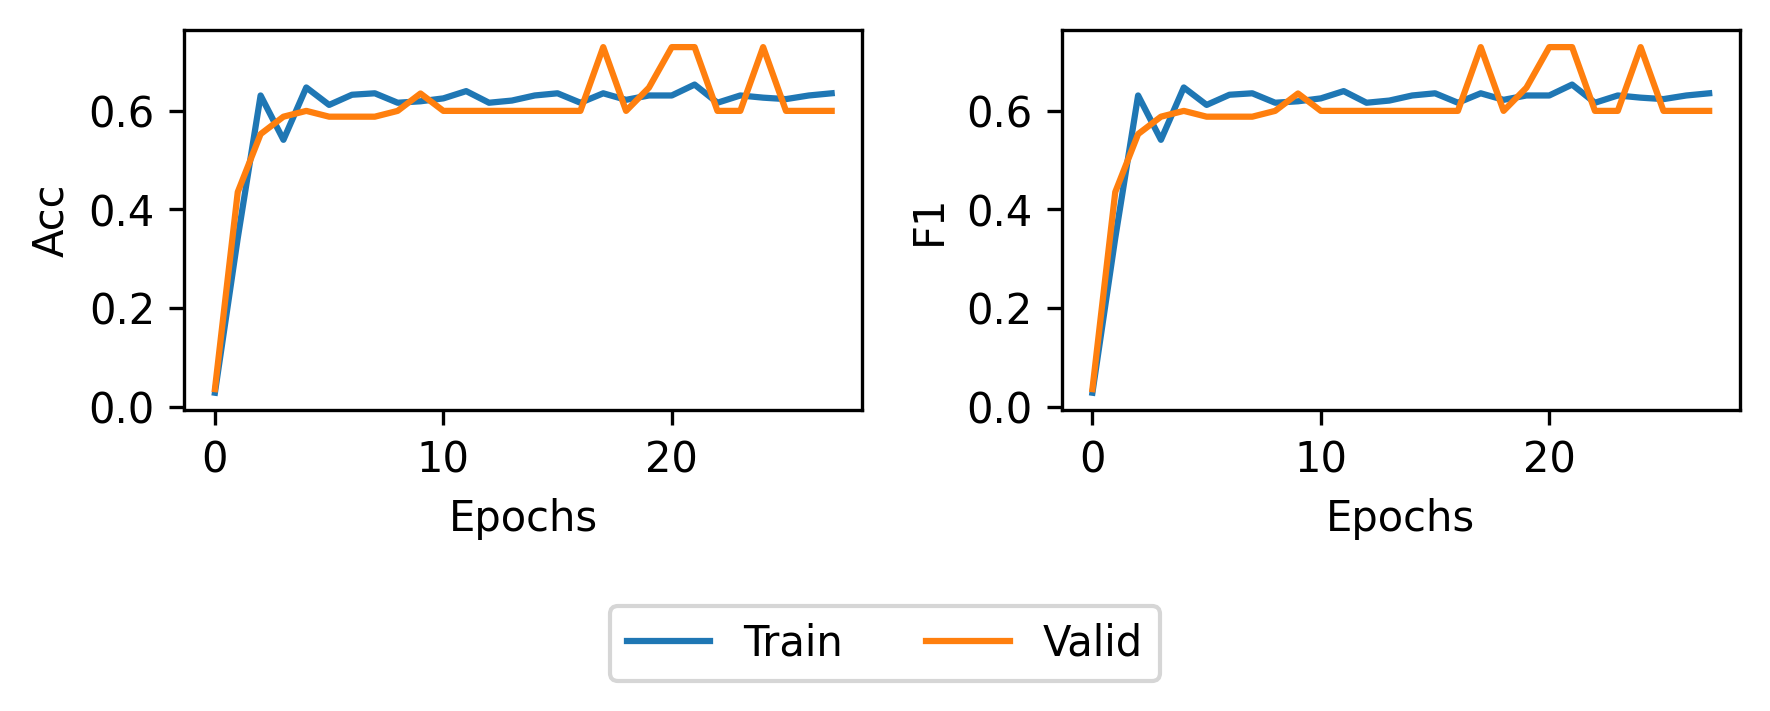

Current Param: {'cat_emb_dim': 2, 'n_a': 2, 'n_d': 4}, Best Valid Acc: 0.72941, Lastest Valid Acc: 0.72941:   6%|▌         | 1/18 [01:17<22:02, 77.81s/it]

{'cat_emb_dim': 2, 'n_a': 2, 'n_d': 4}


=== Epoch 0, Time Taken: 3.3s, Time Left: 1648.7s ===
- Train: Acc: 0.06785, F1: 0.06785
- Valid: Acc: 0.34118, F1: 0.34118


=== Epoch 1, Time Taken: 2.5s, Time Left: 1269.0s ===
- Train: Acc: 0.40265, F1: 0.40265
- Valid: Acc: 0.37647, F1: 0.37647


=== Epoch 2, Time Taken: 2.9s, Time Left: 1431.0s ===
- Train: Acc: 0.47345, F1: 0.47345
- Valid: Acc: 0.48235, F1: 0.48235


=== Epoch 3, Time Taken: 3.0s, Time Left: 1471.5s ===
- Train: Acc: 0.53687, F1: 0.53687
- Valid: Acc: 0.62353, F1: 0.62353


=== Epoch 4, Time Taken: 3.1s, Time Left: 1522.2s ===
- Train: Acc: 0.65044, F1: 0.65044
- Valid: Acc: 0.51765, F1: 0.51765


=== Epoch 5, Time Taken: 3.0s, Time Left: 1489.7s ===
- Train: Acc: 0.62684, F1: 0.62684
- Valid: Acc: 0.61176, F1: 0.61176


=== Epoch 6, Time Taken: 3.1s, Time Left: 1533.6s ===
- Train: Acc: 0.65782, F1: 0.65782
- Valid: Acc: 0.60000, F1: 0.60000


=== Epoch 7, Time Taken: 2.9s, Time Left: 1445.8s ===
- Train: Acc: 0.65192, F1: 0.65192
- Valid: Acc: 0.60000, F1: 0.60000


=== Epoch 8, Time Taken: 2.9s, Time Left: 1429.9s ===
- Train: Acc: 0.66519, F1: 0.66519
- Valid: Acc: 0.60000, F1: 0.60000


=== Epoch 9, Time Taken: 3.0s, Time Left: 1489.7s ===
- Train: Acc: 0.67699, F1: 0.67699
- Valid: Acc: 0.76471, F1: 0.76471


=== Epoch 10, Time Taken: 3.0s, Time Left: 1466.2s ===
- Train: Acc: 0.73451, F1: 0.73451
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 11, Time Taken: 2.8s, Time Left: 1368.9s ===
- Train: Acc: 0.75221, F1: 0.75221
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 12, Time Taken: 2.5s, Time Left: 1204.6s ===
- Train: Acc: 0.74926, F1: 0.74926
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 13, Time Taken: 2.8s, Time Left: 1344.4s ===
- Train: Acc: 0.75516, F1: 0.75516
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 14, Time Taken: 3.0s, Time Left: 1477.7s ===
- Train: Acc: 0.75074, F1: 0.75074
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 15, Time Taken: 3.1s, Time Left: 1476.7s ===
- Train: Acc: 0.75221, F1: 0.75221
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 16, Time Taken: 3.6s, Time Left: 1722.9s ===
- Train: Acc: 0.74926, F1: 0.74926
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 17, Time Taken: 3.1s, Time Left: 1497.0s ===
- Train: Acc: 0.75516, F1: 0.75516
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 18, Time Taken: 2.8s, Time Left: 1359.4s ===
- Train: Acc: 0.75664, F1: 0.75664
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 19, Time Taken: 3.4s, Time Left: 1616.0s ===
- Train: Acc: 0.75369, F1: 0.75369
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 20, Time Taken: 3.2s, Time Left: 1509.5s ===
- Train: Acc: 0.75664, F1: 0.75664
- Valid: Acc: 0.77647, F1: 0.77647
Early Stopping at Epoch 20, Best Validation Acc (0.78824) at Epoch 10.


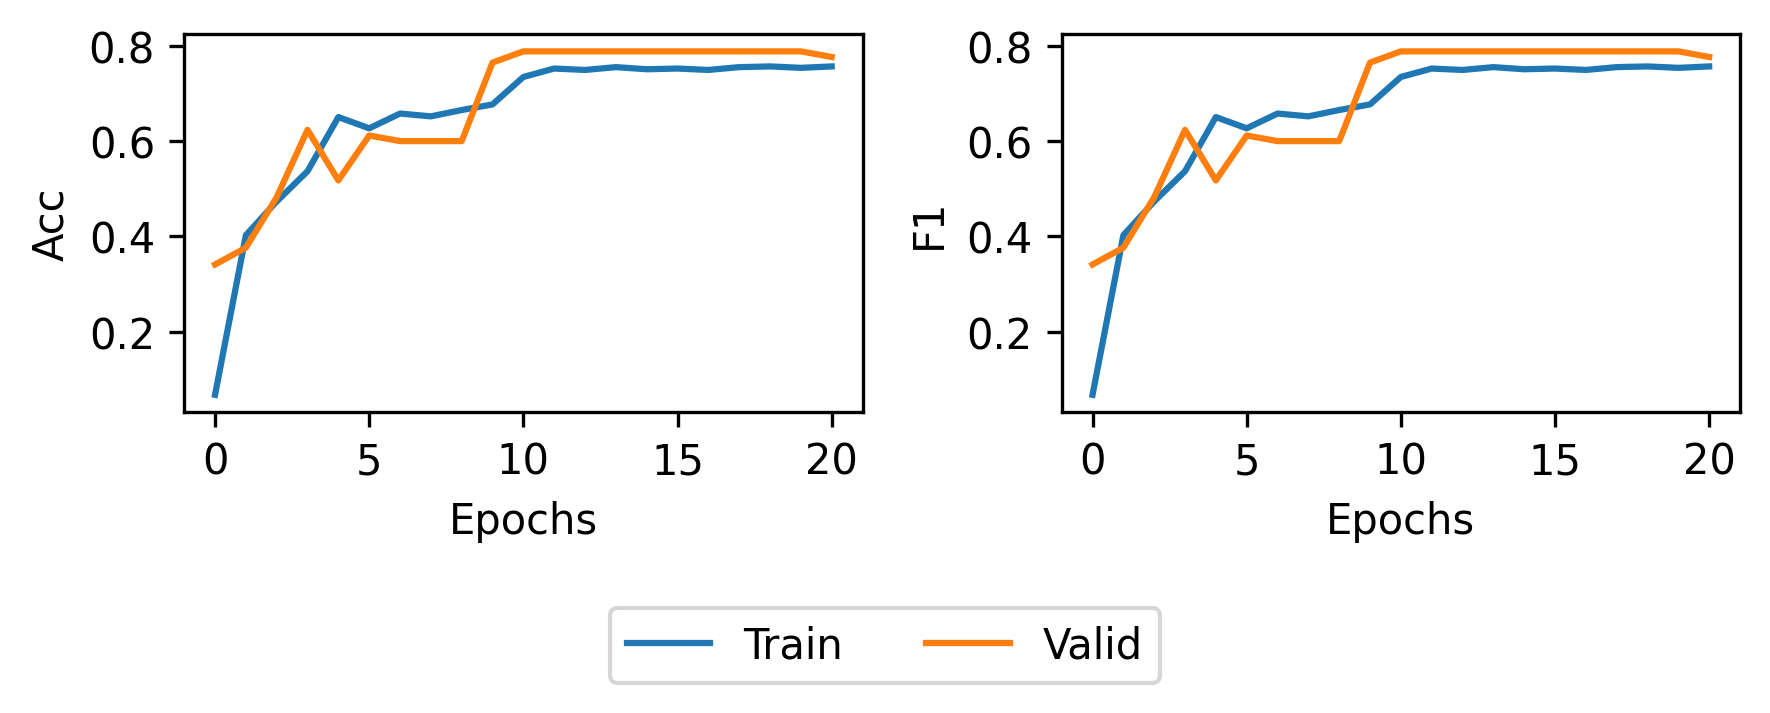

Current Param: {'cat_emb_dim': 2, 'n_a': 2, 'n_d': 8}, Best Valid Acc: 0.78824, Lastest Valid Acc: 0.78824:  11%|█         | 2/18 [02:21<18:29, 69.32s/it]

{'cat_emb_dim': 2, 'n_a': 2, 'n_d': 8}


=== Epoch 0, Time Taken: 3.0s, Time Left: 1481.5s ===
- Train: Acc: 0.27139, F1: 0.27139
- Valid: Acc: 0.31765, F1: 0.31765


=== Epoch 1, Time Taken: 2.9s, Time Left: 1433.4s ===
- Train: Acc: 0.43363, F1: 0.43363
- Valid: Acc: 0.56471, F1: 0.56471


=== Epoch 2, Time Taken: 2.8s, Time Left: 1409.4s ===
- Train: Acc: 0.66372, F1: 0.66372
- Valid: Acc: 0.74118, F1: 0.74118


=== Epoch 3, Time Taken: 2.9s, Time Left: 1438.2s ===
- Train: Acc: 0.72419, F1: 0.72419
- Valid: Acc: 0.72941, F1: 0.72941


=== Epoch 4, Time Taken: 2.9s, Time Left: 1427.5s ===
- Train: Acc: 0.73451, F1: 0.73451
- Valid: Acc: 0.76471, F1: 0.76471


=== Epoch 5, Time Taken: 3.3s, Time Left: 1606.8s ===
- Train: Acc: 0.72566, F1: 0.72566
- Valid: Acc: 0.74118, F1: 0.74118


=== Epoch 6, Time Taken: 2.9s, Time Left: 1411.9s ===
- Train: Acc: 0.73746, F1: 0.73746
- Valid: Acc: 0.76471, F1: 0.76471


=== Epoch 7, Time Taken: 3.4s, Time Left: 1691.5s ===
- Train: Acc: 0.74336, F1: 0.74336
- Valid: Acc: 0.72941, F1: 0.72941


=== Epoch 8, Time Taken: 3.5s, Time Left: 1714.9s ===
- Train: Acc: 0.73009, F1: 0.73009
- Valid: Acc: 0.72941, F1: 0.72941


=== Epoch 9, Time Taken: 3.2s, Time Left: 1579.2s ===
- Train: Acc: 0.73009, F1: 0.73009
- Valid: Acc: 0.72941, F1: 0.72941


=== Epoch 10, Time Taken: 2.9s, Time Left: 1428.0s ===
- Train: Acc: 0.73156, F1: 0.73156
- Valid: Acc: 0.72941, F1: 0.72941


=== Epoch 11, Time Taken: 3.3s, Time Left: 1613.3s ===
- Train: Acc: 0.73599, F1: 0.73599
- Valid: Acc: 0.76471, F1: 0.76471


=== Epoch 12, Time Taken: 3.3s, Time Left: 1608.3s ===
- Train: Acc: 0.73894, F1: 0.73894
- Valid: Acc: 0.76471, F1: 0.76471


=== Epoch 13, Time Taken: 3.1s, Time Left: 1506.6s ===
- Train: Acc: 0.73746, F1: 0.73746
- Valid: Acc: 0.76471, F1: 0.76471


=== Epoch 14, Time Taken: 3.2s, Time Left: 1536.1s ===
- Train: Acc: 0.74484, F1: 0.74484
- Valid: Acc: 0.77647, F1: 0.77647


=== Epoch 15, Time Taken: 3.9s, Time Left: 1896.8s ===
- Train: Acc: 0.74189, F1: 0.74189
- Valid: Acc: 0.76471, F1: 0.76471


=== Epoch 16, Time Taken: 7.8s, Time Left: 3770.5s ===
- Train: Acc: 0.74631, F1: 0.74631
- Valid: Acc: 0.76471, F1: 0.76471


=== Epoch 17, Time Taken: 7.7s, Time Left: 3691.6s ===
- Train: Acc: 0.75074, F1: 0.75074
- Valid: Acc: 0.76471, F1: 0.76471


=== Epoch 18, Time Taken: 8.2s, Time Left: 3943.5s ===
- Train: Acc: 0.75369, F1: 0.75369
- Valid: Acc: 0.76471, F1: 0.76471


=== Epoch 19, Time Taken: 8.4s, Time Left: 4014.2s ===
- Train: Acc: 0.75516, F1: 0.75516
- Valid: Acc: 0.76471, F1: 0.76471


=== Epoch 20, Time Taken: 7.0s, Time Left: 3331.8s ===
- Train: Acc: 0.75664, F1: 0.75664
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 21, Time Taken: 8.2s, Time Left: 3917.4s ===
- Train: Acc: 0.75369, F1: 0.75369
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 22, Time Taken: 8.6s, Time Left: 4110.6s ===
- Train: Acc: 0.75811, F1: 0.75811
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 23, Time Taken: 8.0s, Time Left: 3809.5s ===
- Train: Acc: 0.75369, F1: 0.75369
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 24, Time Taken: 8.4s, Time Left: 3966.3s ===
- Train: Acc: 0.75811, F1: 0.75811
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 25, Time Taken: 6.9s, Time Left: 3270.8s ===
- Train: Acc: 0.75811, F1: 0.75811
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 26, Time Taken: 2.9s, Time Left: 1348.1s ===
- Train: Acc: 0.75811, F1: 0.75811
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 27, Time Taken: 2.9s, Time Left: 1365.3s ===
- Train: Acc: 0.75811, F1: 0.75811
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 28, Time Taken: 2.7s, Time Left: 1282.0s ===
- Train: Acc: 0.75811, F1: 0.75811
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 29, Time Taken: 2.7s, Time Left: 1246.0s ===
- Train: Acc: 0.75811, F1: 0.75811
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 30, Time Taken: 2.6s, Time Left: 1197.0s ===
- Train: Acc: 0.75811, F1: 0.75811
- Valid: Acc: 0.78824, F1: 0.78824
Early Stopping at Epoch 30, Best Validation Acc (0.78824) at Epoch 20.


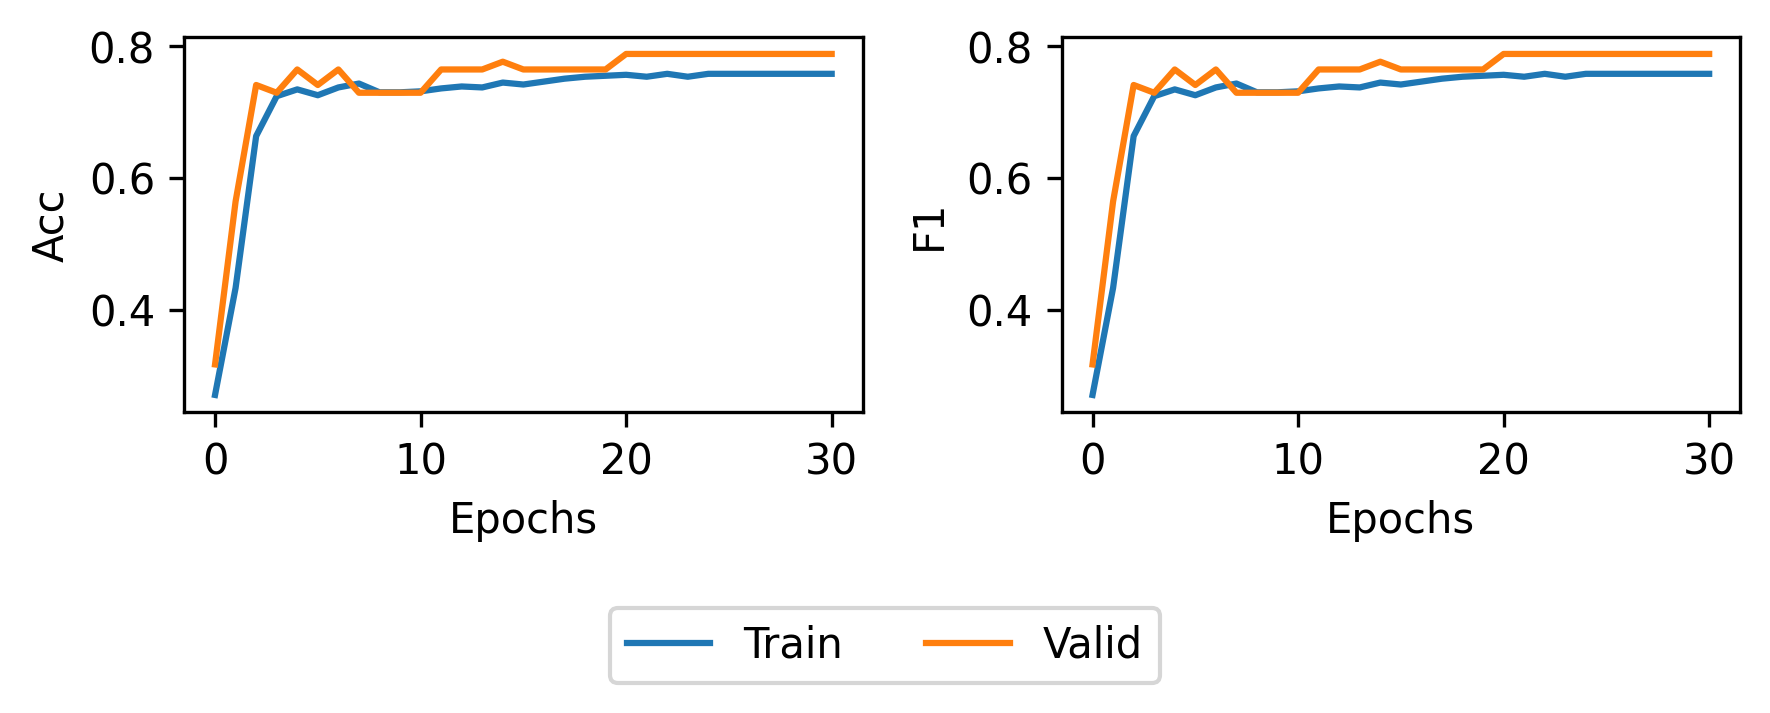

Current Param: {'cat_emb_dim': 2, 'n_a': 4, 'n_d': 2}, Best Valid Acc: 0.78824, Lastest Valid Acc: 0.78824:  17%|█▋        | 3/18 [04:44<25:48, 103.24s/it]

{'cat_emb_dim': 2, 'n_a': 4, 'n_d': 2}


=== Epoch 0, Time Taken: 3.0s, Time Left: 1511.3s ===
- Train: Acc: 0.11947, F1: 0.11947
- Valid: Acc: 0.16471, F1: 0.16471


=== Epoch 1, Time Taken: 3.7s, Time Left: 1850.5s ===
- Train: Acc: 0.42330, F1: 0.42330
- Valid: Acc: 0.45882, F1: 0.45882


=== Epoch 2, Time Taken: 3.6s, Time Left: 1768.4s ===
- Train: Acc: 0.44248, F1: 0.44248
- Valid: Acc: 0.50588, F1: 0.50588


=== Epoch 3, Time Taken: 3.0s, Time Left: 1466.5s ===
- Train: Acc: 0.59145, F1: 0.59145
- Valid: Acc: 0.60000, F1: 0.60000


=== Epoch 4, Time Taken: 3.2s, Time Left: 1605.2s ===
- Train: Acc: 0.60914, F1: 0.60914
- Valid: Acc: 0.61176, F1: 0.61176


=== Epoch 5, Time Taken: 2.9s, Time Left: 1449.8s ===
- Train: Acc: 0.61062, F1: 0.61062
- Valid: Acc: 0.65882, F1: 0.65882


=== Epoch 6, Time Taken: 2.8s, Time Left: 1372.9s ===
- Train: Acc: 0.61504, F1: 0.61504
- Valid: Acc: 0.64706, F1: 0.64706


=== Epoch 7, Time Taken: 2.6s, Time Left: 1300.7s ===
- Train: Acc: 0.64159, F1: 0.64159
- Valid: Acc: 0.63529, F1: 0.63529


=== Epoch 8, Time Taken: 2.7s, Time Left: 1314.4s ===
- Train: Acc: 0.59882, F1: 0.59882
- Valid: Acc: 0.61176, F1: 0.61176


=== Epoch 9, Time Taken: 3.1s, Time Left: 1500.7s ===
- Train: Acc: 0.61652, F1: 0.61652
- Valid: Acc: 0.65882, F1: 0.65882


=== Epoch 10, Time Taken: 3.2s, Time Left: 1541.5s ===
- Train: Acc: 0.60177, F1: 0.60177
- Valid: Acc: 0.64706, F1: 0.64706


=== Epoch 11, Time Taken: 3.0s, Time Left: 1457.3s ===
- Train: Acc: 0.63422, F1: 0.63422
- Valid: Acc: 0.47059, F1: 0.47059


=== Epoch 12, Time Taken: 2.8s, Time Left: 1359.0s ===
- Train: Acc: 0.56785, F1: 0.56785
- Valid: Acc: 0.55294, F1: 0.55294


=== Epoch 13, Time Taken: 2.7s, Time Left: 1305.8s ===
- Train: Acc: 0.61947, F1: 0.61947
- Valid: Acc: 0.63529, F1: 0.63529


=== Epoch 14, Time Taken: 2.9s, Time Left: 1430.2s ===
- Train: Acc: 0.65339, F1: 0.65339
- Valid: Acc: 0.64706, F1: 0.64706


=== Epoch 15, Time Taken: 2.9s, Time Left: 1421.5s ===
- Train: Acc: 0.62979, F1: 0.62979
- Valid: Acc: 0.54118, F1: 0.54118
Early Stopping at Epoch 15, Best Validation Acc (0.65882) at Epoch 5.


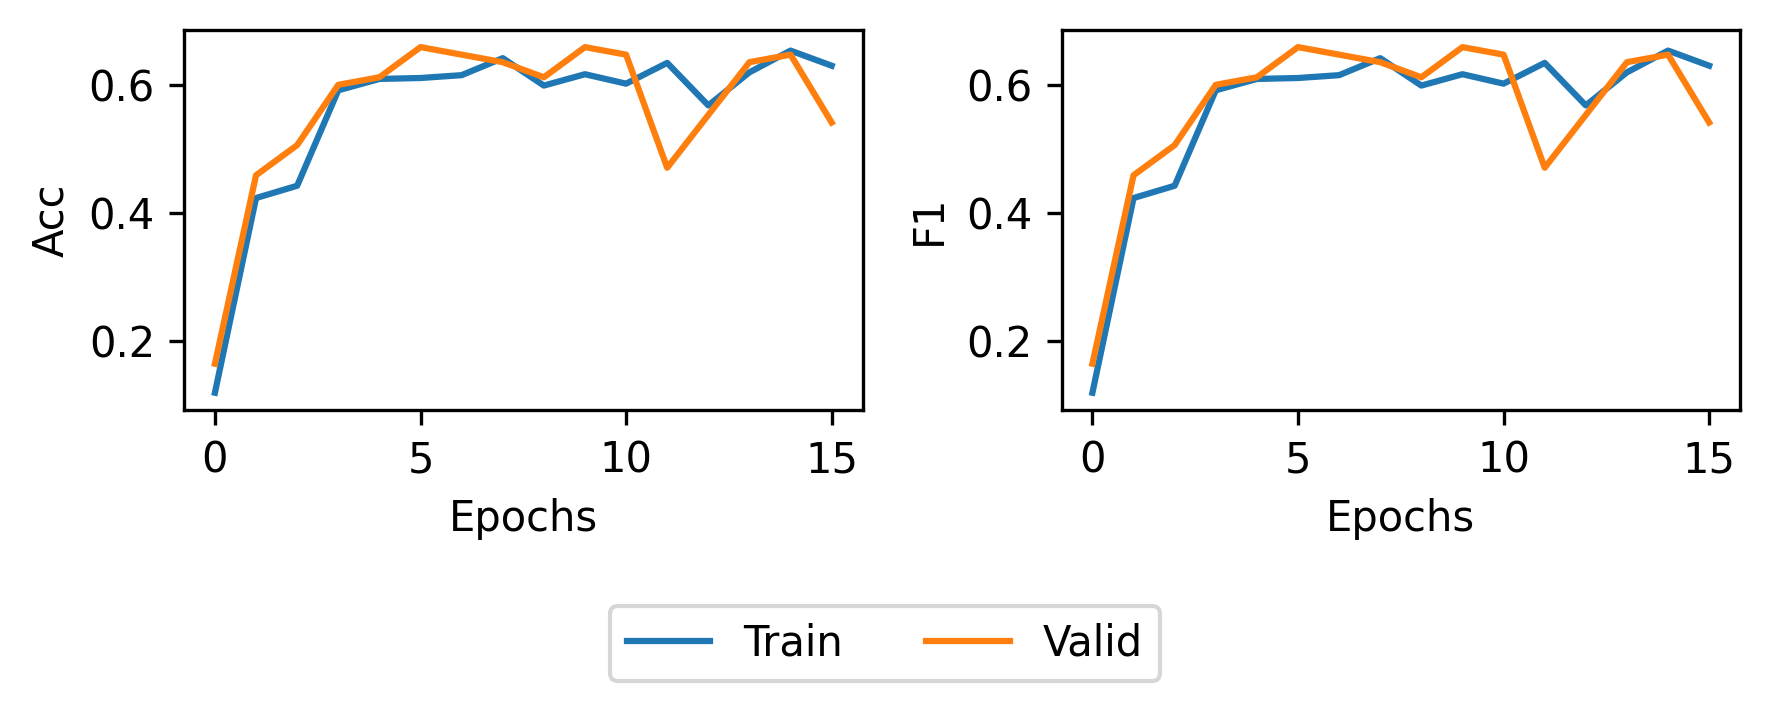

Current Param: {'cat_emb_dim': 2, 'n_a': 4, 'n_d': 4}, Best Valid Acc: 0.78824, Lastest Valid Acc: 0.65882:  22%|██▏       | 4/18 [05:33<19:02, 81.64s/it] 

{'cat_emb_dim': 2, 'n_a': 4, 'n_d': 4}


=== Epoch 0, Time Taken: 3.3s, Time Left: 1644.9s ===
- Train: Acc: 0.03097, F1: 0.03097
- Valid: Acc: 0.02353, F1: 0.02353


=== Epoch 1, Time Taken: 3.3s, Time Left: 1628.3s ===
- Train: Acc: 0.48968, F1: 0.48968
- Valid: Acc: 0.72941, F1: 0.72941


=== Epoch 2, Time Taken: 3.4s, Time Left: 1712.8s ===
- Train: Acc: 0.69322, F1: 0.69322
- Valid: Acc: 0.72941, F1: 0.72941


=== Epoch 3, Time Taken: 2.9s, Time Left: 1419.6s ===
- Train: Acc: 0.71976, F1: 0.71976
- Valid: Acc: 0.72941, F1: 0.72941


=== Epoch 4, Time Taken: 2.6s, Time Left: 1288.4s ===
- Train: Acc: 0.72566, F1: 0.72566
- Valid: Acc: 0.72941, F1: 0.72941


=== Epoch 5, Time Taken: 3.2s, Time Left: 1589.0s ===
- Train: Acc: 0.72861, F1: 0.72861
- Valid: Acc: 0.72941, F1: 0.72941


=== Epoch 6, Time Taken: 4.5s, Time Left: 2231.2s ===
- Train: Acc: 0.72861, F1: 0.72861
- Valid: Acc: 0.72941, F1: 0.72941


=== Epoch 7, Time Taken: 7.7s, Time Left: 3774.4s ===
- Train: Acc: 0.72861, F1: 0.72861
- Valid: Acc: 0.72941, F1: 0.72941


=== Epoch 8, Time Taken: 7.9s, Time Left: 3897.3s ===
- Train: Acc: 0.73156, F1: 0.73156
- Valid: Acc: 0.72941, F1: 0.72941


=== Epoch 9, Time Taken: 7.4s, Time Left: 3623.9s ===
- Train: Acc: 0.71681, F1: 0.71681
- Valid: Acc: 0.72941, F1: 0.72941


=== Epoch 10, Time Taken: 7.4s, Time Left: 3636.7s ===
- Train: Acc: 0.72861, F1: 0.72861
- Valid: Acc: 0.72941, F1: 0.72941


=== Epoch 11, Time Taken: 7.4s, Time Left: 3608.1s ===
- Train: Acc: 0.72861, F1: 0.72861
- Valid: Acc: 0.72941, F1: 0.72941
Early Stopping at Epoch 11, Best Validation Acc (0.72941) at Epoch 1.


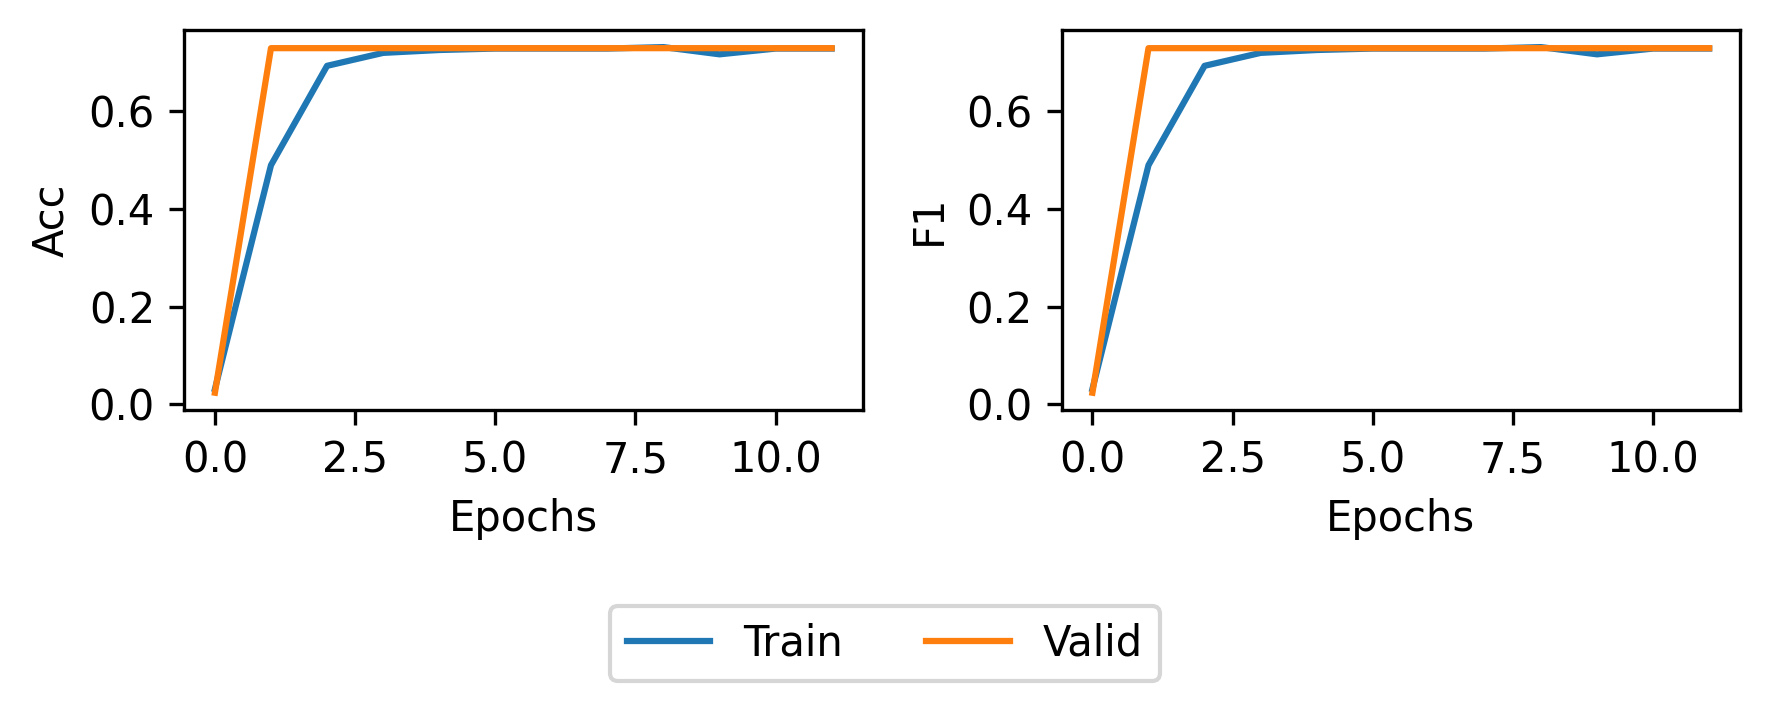

Current Param: {'cat_emb_dim': 2, 'n_a': 4, 'n_d': 8}, Best Valid Acc: 0.78824, Lastest Valid Acc: 0.72941:  28%|██▊       | 5/18 [06:35<16:09, 74.60s/it]

{'cat_emb_dim': 2, 'n_a': 4, 'n_d': 8}


=== Epoch 0, Time Taken: 8.2s, Time Left: 4108.0s ===
- Train: Acc: 0.01917, F1: 0.01917
- Valid: Acc: 0.05882, F1: 0.05882


=== Epoch 1, Time Taken: 7.6s, Time Left: 3766.0s ===
- Train: Acc: 0.40708, F1: 0.40708
- Valid: Acc: 0.44706, F1: 0.44706


=== Epoch 2, Time Taken: 7.5s, Time Left: 3751.6s ===
- Train: Acc: 0.61357, F1: 0.61357
- Valid: Acc: 0.61176, F1: 0.61176


=== Epoch 3, Time Taken: 6.8s, Time Left: 3386.9s ===
- Train: Acc: 0.71534, F1: 0.71534
- Valid: Acc: 0.65882, F1: 0.65882


=== Epoch 4, Time Taken: 7.5s, Time Left: 3717.5s ===
- Train: Acc: 0.72419, F1: 0.72419
- Valid: Acc: 0.72941, F1: 0.72941


=== Epoch 5, Time Taken: 8.1s, Time Left: 4003.8s ===
- Train: Acc: 0.72861, F1: 0.72861
- Valid: Acc: 0.72941, F1: 0.72941


=== Epoch 6, Time Taken: 8.0s, Time Left: 3932.2s ===
- Train: Acc: 0.72861, F1: 0.72861
- Valid: Acc: 0.72941, F1: 0.72941


=== Epoch 7, Time Taken: 7.3s, Time Left: 3592.0s ===
- Train: Acc: 0.72861, F1: 0.72861
- Valid: Acc: 0.71765, F1: 0.71765


=== Epoch 8, Time Taken: 7.2s, Time Left: 3536.1s ===
- Train: Acc: 0.72861, F1: 0.72861
- Valid: Acc: 0.72941, F1: 0.72941


=== Epoch 9, Time Taken: 7.3s, Time Left: 3554.5s ===
- Train: Acc: 0.72861, F1: 0.72861
- Valid: Acc: 0.72941, F1: 0.72941


=== Epoch 10, Time Taken: 7.5s, Time Left: 3672.7s ===
- Train: Acc: 0.72861, F1: 0.72861
- Valid: Acc: 0.72941, F1: 0.72941


=== Epoch 11, Time Taken: 7.1s, Time Left: 3479.7s ===
- Train: Acc: 0.72861, F1: 0.72861
- Valid: Acc: 0.72941, F1: 0.72941


=== Epoch 12, Time Taken: 8.5s, Time Left: 4157.5s ===
- Train: Acc: 0.72861, F1: 0.72861
- Valid: Acc: 0.72941, F1: 0.72941


=== Epoch 13, Time Taken: 7.1s, Time Left: 3448.9s ===
- Train: Acc: 0.72861, F1: 0.72861
- Valid: Acc: 0.72941, F1: 0.72941


=== Epoch 14, Time Taken: 8.4s, Time Left: 4050.2s ===
- Train: Acc: 0.72861, F1: 0.72861
- Valid: Acc: 0.72941, F1: 0.72941
Early Stopping at Epoch 14, Best Validation Acc (0.72941) at Epoch 4.


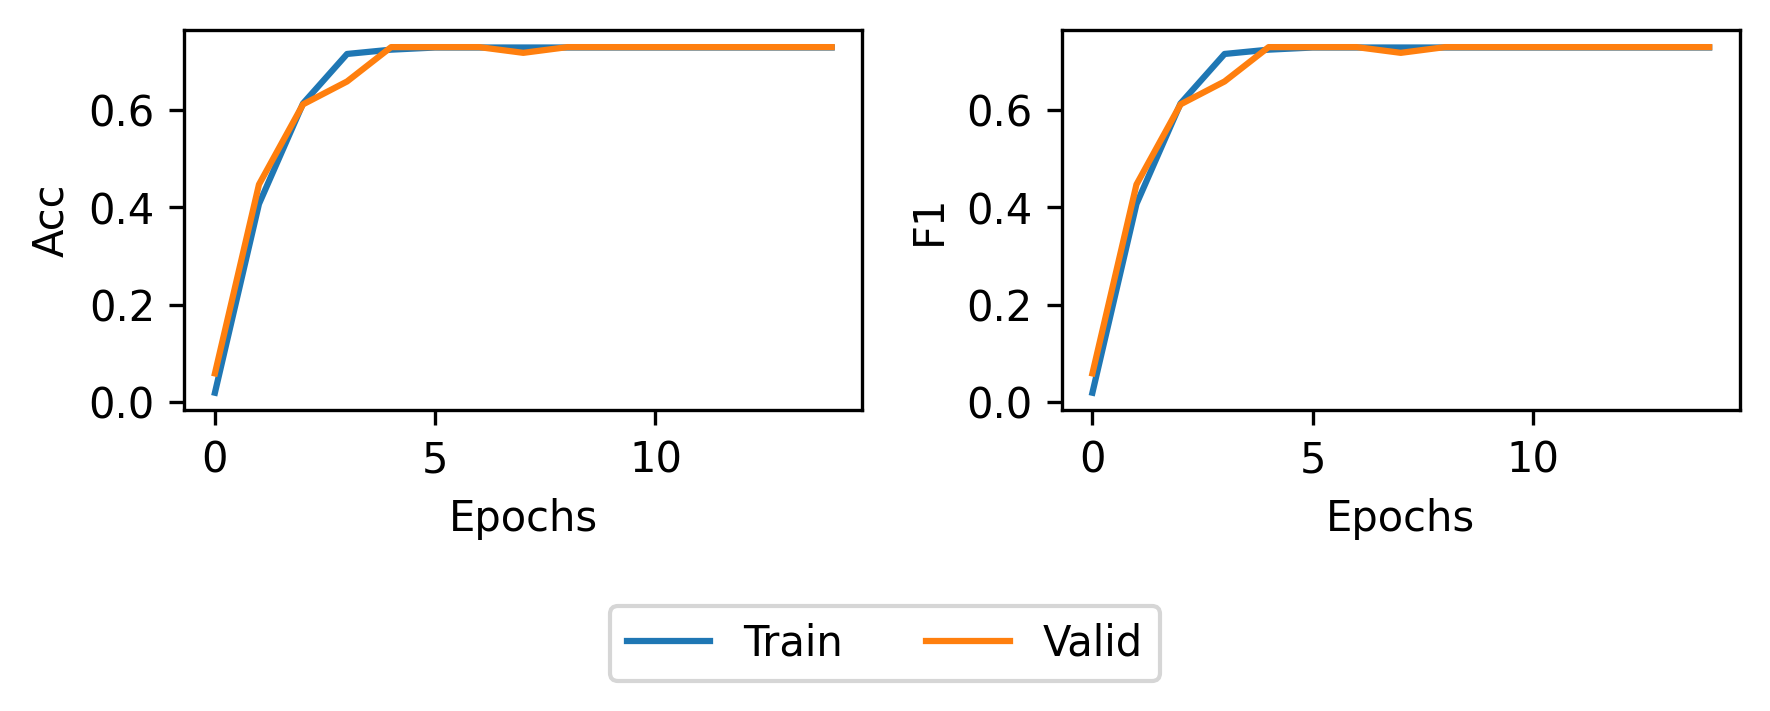

Current Param: {'cat_emb_dim': 2, 'n_a': 8, 'n_d': 2}, Best Valid Acc: 0.78824, Lastest Valid Acc: 0.72941:  33%|███▎      | 6/18 [08:30<17:40, 88.36s/it]

{'cat_emb_dim': 2, 'n_a': 8, 'n_d': 2}


=== Epoch 0, Time Taken: 9.3s, Time Left: 4623.2s ===
- Train: Acc: 0.00147, F1: 0.00147
- Valid: Acc: 0.00000, F1: 0.00000


=== Epoch 1, Time Taken: 7.3s, Time Left: 3651.9s ===
- Train: Acc: 0.00000, F1: 0.00000
- Valid: Acc: 0.00000, F1: 0.00000


=== Epoch 2, Time Taken: 8.0s, Time Left: 3987.0s ===
- Train: Acc: 0.00000, F1: 0.00000
- Valid: Acc: 0.00000, F1: 0.00000


=== Epoch 3, Time Taken: 8.4s, Time Left: 4187.2s ===
- Train: Acc: 0.00000, F1: 0.00000
- Valid: Acc: 0.00000, F1: 0.00000


=== Epoch 4, Time Taken: 7.9s, Time Left: 3911.6s ===
- Train: Acc: 0.00000, F1: 0.00000
- Valid: Acc: 0.00000, F1: 0.00000


=== Epoch 5, Time Taken: 7.3s, Time Left: 3604.0s ===
- Train: Acc: 0.00000, F1: 0.00000
- Valid: Acc: 0.00000, F1: 0.00000


=== Epoch 6, Time Taken: 7.1s, Time Left: 3492.9s ===
- Train: Acc: 0.00000, F1: 0.00000
- Valid: Acc: 0.00000, F1: 0.00000


=== Epoch 7, Time Taken: 7.7s, Time Left: 3775.8s ===
- Train: Acc: 0.00000, F1: 0.00000
- Valid: Acc: 0.00000, F1: 0.00000


=== Epoch 8, Time Taken: 7.6s, Time Left: 3755.2s ===
- Train: Acc: 0.00000, F1: 0.00000
- Valid: Acc: 0.00000, F1: 0.00000


=== Epoch 9, Time Taken: 7.7s, Time Left: 3763.7s ===
- Train: Acc: 0.00000, F1: 0.00000
- Valid: Acc: 0.00000, F1: 0.00000


=== Epoch 10, Time Taken: 7.7s, Time Left: 3743.8s ===
- Train: Acc: 0.00000, F1: 0.00000
- Valid: Acc: 0.00000, F1: 0.00000
Early Stopping at Epoch 10, Best Validation Acc (0.00000) at Epoch 0.


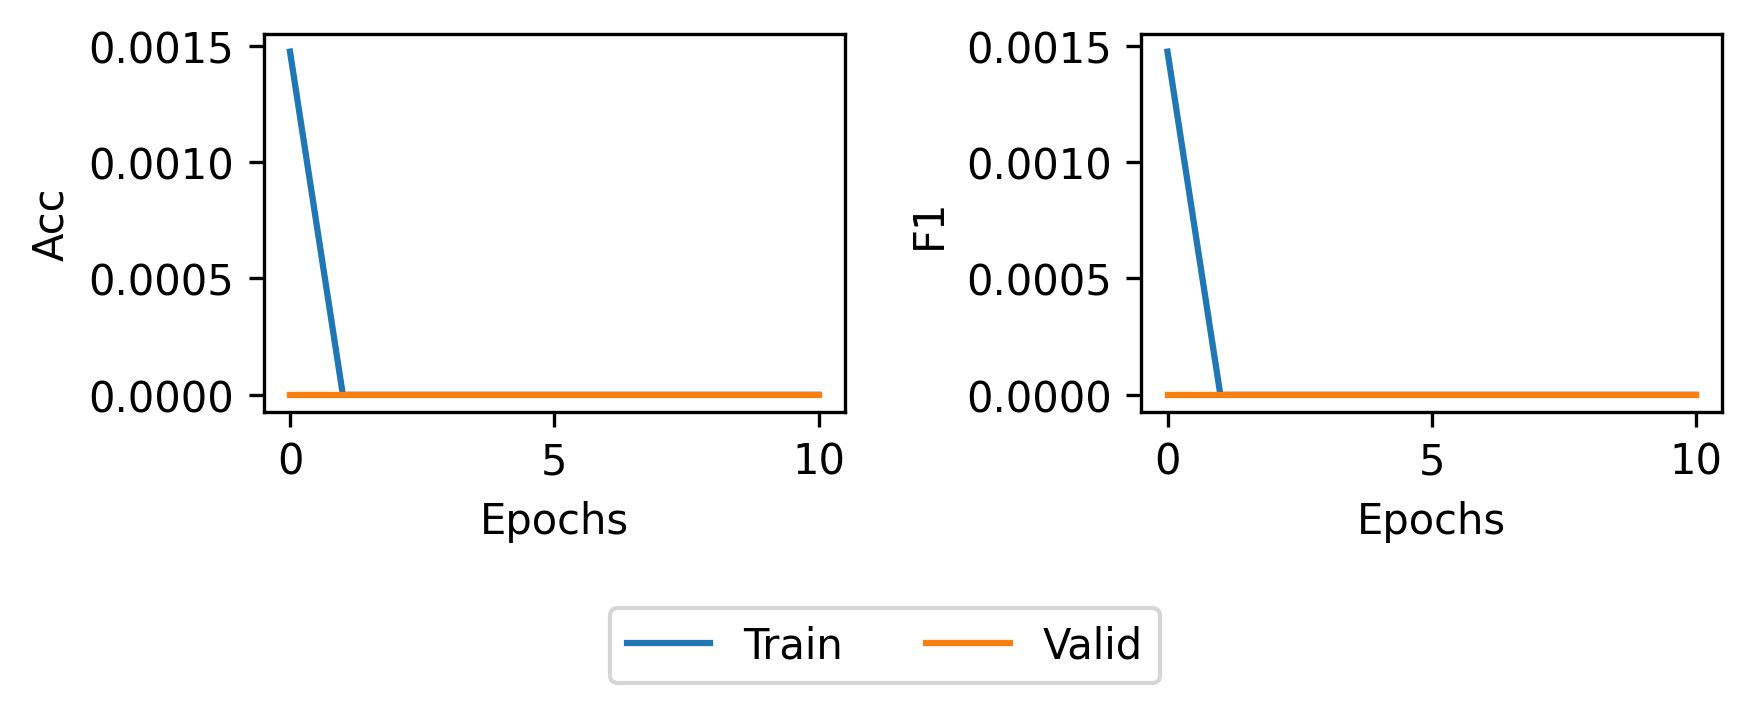

Current Param: {'cat_emb_dim': 2, 'n_a': 8, 'n_d': 4}, Best Valid Acc: 0.78824, Lastest Valid Acc: 0.00000:  39%|███▉      | 7/18 [09:57<16:07, 87.97s/it]

{'cat_emb_dim': 2, 'n_a': 8, 'n_d': 4}


=== Epoch 0, Time Taken: 9.1s, Time Left: 4552.8s ===
- Train: Acc: 0.14454, F1: 0.14454
- Valid: Acc: 0.20000, F1: 0.20000


=== Epoch 1, Time Taken: 7.9s, Time Left: 3926.0s ===
- Train: Acc: 0.59145, F1: 0.59145
- Valid: Acc: 0.72941, F1: 0.72941


=== Epoch 2, Time Taken: 8.3s, Time Left: 4138.8s ===
- Train: Acc: 0.73451, F1: 0.73451
- Valid: Acc: 0.72941, F1: 0.72941


=== Epoch 3, Time Taken: 3.2s, Time Left: 1567.7s ===
- Train: Acc: 0.72861, F1: 0.72861
- Valid: Acc: 0.72941, F1: 0.72941


=== Epoch 4, Time Taken: 3.0s, Time Left: 1461.2s ===
- Train: Acc: 0.72861, F1: 0.72861
- Valid: Acc: 0.67059, F1: 0.67059


=== Epoch 5, Time Taken: 2.8s, Time Left: 1405.9s ===
- Train: Acc: 0.73009, F1: 0.73009
- Valid: Acc: 0.72941, F1: 0.72941


=== Epoch 6, Time Taken: 2.7s, Time Left: 1350.3s ===
- Train: Acc: 0.73009, F1: 0.73009
- Valid: Acc: 0.72941, F1: 0.72941


=== Epoch 7, Time Taken: 2.6s, Time Left: 1269.1s ===
- Train: Acc: 0.73156, F1: 0.73156
- Valid: Acc: 0.72941, F1: 0.72941


=== Epoch 8, Time Taken: 2.8s, Time Left: 1383.1s ===
- Train: Acc: 0.73599, F1: 0.73599
- Valid: Acc: 0.76471, F1: 0.76471


=== Epoch 9, Time Taken: 2.9s, Time Left: 1437.5s ===
- Train: Acc: 0.74041, F1: 0.74041
- Valid: Acc: 0.76471, F1: 0.76471


=== Epoch 10, Time Taken: 2.9s, Time Left: 1401.0s ===
- Train: Acc: 0.74336, F1: 0.74336
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 11, Time Taken: 2.8s, Time Left: 1378.5s ===
- Train: Acc: 0.74189, F1: 0.74189
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 12, Time Taken: 3.0s, Time Left: 1462.5s ===
- Train: Acc: 0.75074, F1: 0.75074
- Valid: Acc: 0.75294, F1: 0.75294


=== Epoch 13, Time Taken: 2.8s, Time Left: 1381.9s ===
- Train: Acc: 0.74926, F1: 0.74926
- Valid: Acc: 0.76471, F1: 0.76471


=== Epoch 14, Time Taken: 2.7s, Time Left: 1295.0s ===
- Train: Acc: 0.74779, F1: 0.74779
- Valid: Acc: 0.76471, F1: 0.76471


=== Epoch 15, Time Taken: 2.6s, Time Left: 1274.7s ===
- Train: Acc: 0.74926, F1: 0.74926
- Valid: Acc: 0.77647, F1: 0.77647


=== Epoch 16, Time Taken: 2.9s, Time Left: 1423.8s ===
- Train: Acc: 0.74189, F1: 0.74189
- Valid: Acc: 0.74118, F1: 0.74118


=== Epoch 17, Time Taken: 3.0s, Time Left: 1439.9s ===
- Train: Acc: 0.74189, F1: 0.74189
- Valid: Acc: 0.75294, F1: 0.75294


=== Epoch 18, Time Taken: 2.8s, Time Left: 1339.6s ===
- Train: Acc: 0.74189, F1: 0.74189
- Valid: Acc: 0.72941, F1: 0.72941


=== Epoch 19, Time Taken: 3.1s, Time Left: 1466.8s ===
- Train: Acc: 0.73599, F1: 0.73599
- Valid: Acc: 0.63529, F1: 0.63529


=== Epoch 20, Time Taken: 2.9s, Time Left: 1391.9s ===
- Train: Acc: 0.74189, F1: 0.74189
- Valid: Acc: 0.74118, F1: 0.74118
Early Stopping at Epoch 20, Best Validation Acc (0.78824) at Epoch 10.


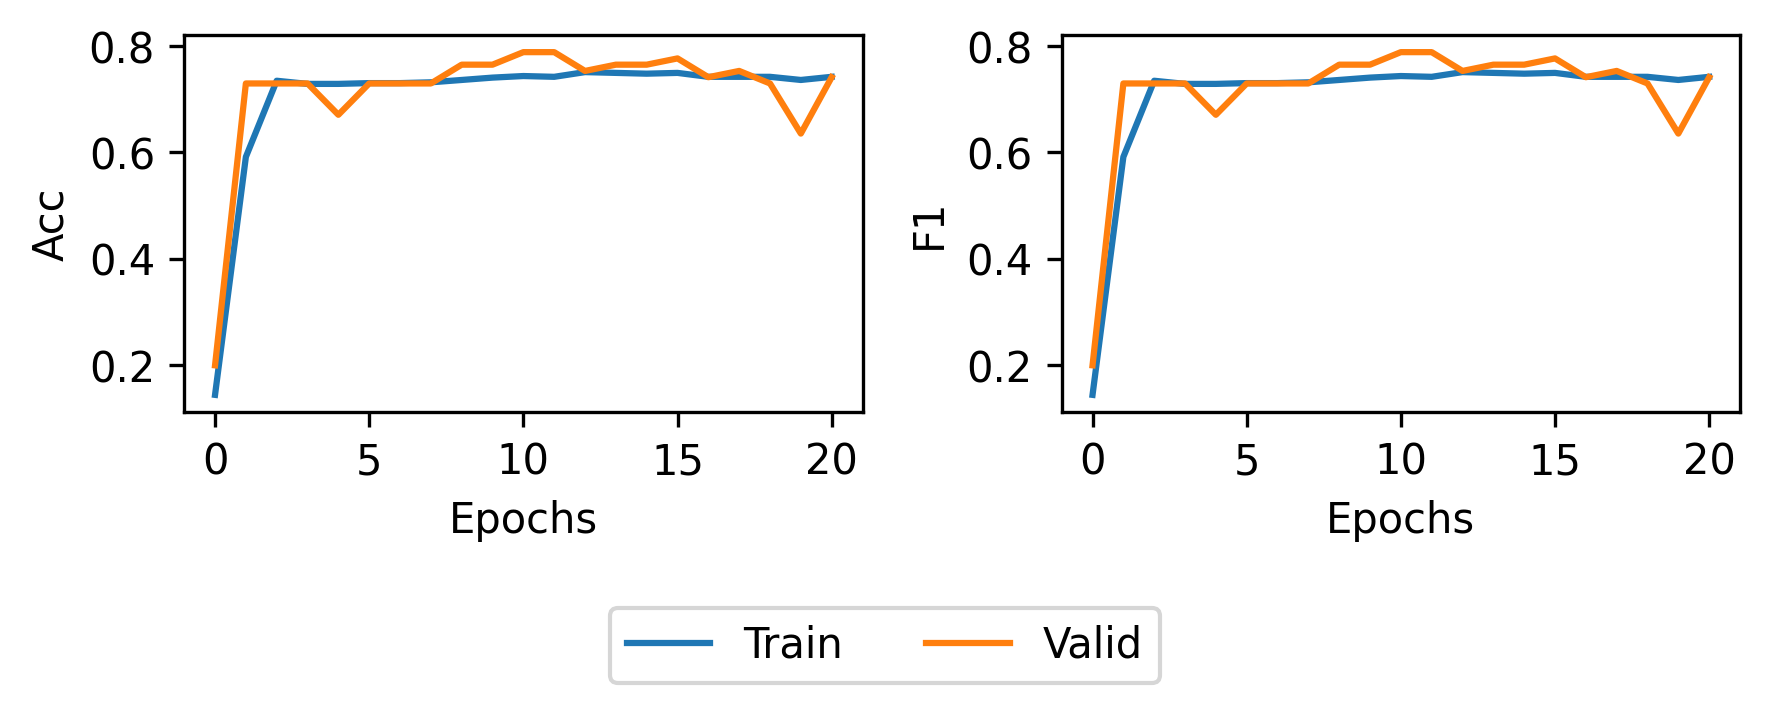

Current Param: {'cat_emb_dim': 2, 'n_a': 8, 'n_d': 8}, Best Valid Acc: 0.78824, Lastest Valid Acc: 0.78824:  44%|████▍     | 8/18 [11:15<14:06, 84.65s/it]

{'cat_emb_dim': 2, 'n_a': 8, 'n_d': 8}


=== Epoch 0, Time Taken: 2.9s, Time Left: 1463.9s ===
- Train: Acc: 0.02360, F1: 0.02360
- Valid: Acc: 0.01176, F1: 0.01176


=== Epoch 1, Time Taken: 2.8s, Time Left: 1405.8s ===
- Train: Acc: 0.51770, F1: 0.51770
- Valid: Acc: 0.74118, F1: 0.74118


=== Epoch 2, Time Taken: 2.8s, Time Left: 1400.7s ===
- Train: Acc: 0.75221, F1: 0.75221
- Valid: Acc: 0.77647, F1: 0.77647


=== Epoch 3, Time Taken: 2.7s, Time Left: 1349.8s ===
- Train: Acc: 0.73746, F1: 0.73746
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 4, Time Taken: 3.7s, Time Left: 1844.0s ===
- Train: Acc: 0.74631, F1: 0.74631
- Valid: Acc: 0.77647, F1: 0.77647


=== Epoch 5, Time Taken: 3.7s, Time Left: 1804.8s ===
- Train: Acc: 0.73746, F1: 0.73746
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 6, Time Taken: 4.0s, Time Left: 1952.3s ===
- Train: Acc: 0.73894, F1: 0.73894
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 7, Time Taken: 3.2s, Time Left: 1553.2s ===
- Train: Acc: 0.75221, F1: 0.75221
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 8, Time Taken: 3.3s, Time Left: 1644.8s ===
- Train: Acc: 0.75811, F1: 0.75811
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 9, Time Taken: 3.5s, Time Left: 1690.6s ===
- Train: Acc: 0.75811, F1: 0.75811
- Valid: Acc: 0.77647, F1: 0.77647


=== Epoch 10, Time Taken: 3.4s, Time Left: 1669.5s ===
- Train: Acc: 0.75074, F1: 0.75074
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 11, Time Taken: 3.7s, Time Left: 1784.3s ===
- Train: Acc: 0.75221, F1: 0.75221
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 12, Time Taken: 3.5s, Time Left: 1717.9s ===
- Train: Acc: 0.75811, F1: 0.75811
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 13, Time Taken: 3.1s, Time Left: 1515.9s ===
- Train: Acc: 0.75811, F1: 0.75811
- Valid: Acc: 0.78824, F1: 0.78824
Early Stopping at Epoch 13, Best Validation Acc (0.78824) at Epoch 3.


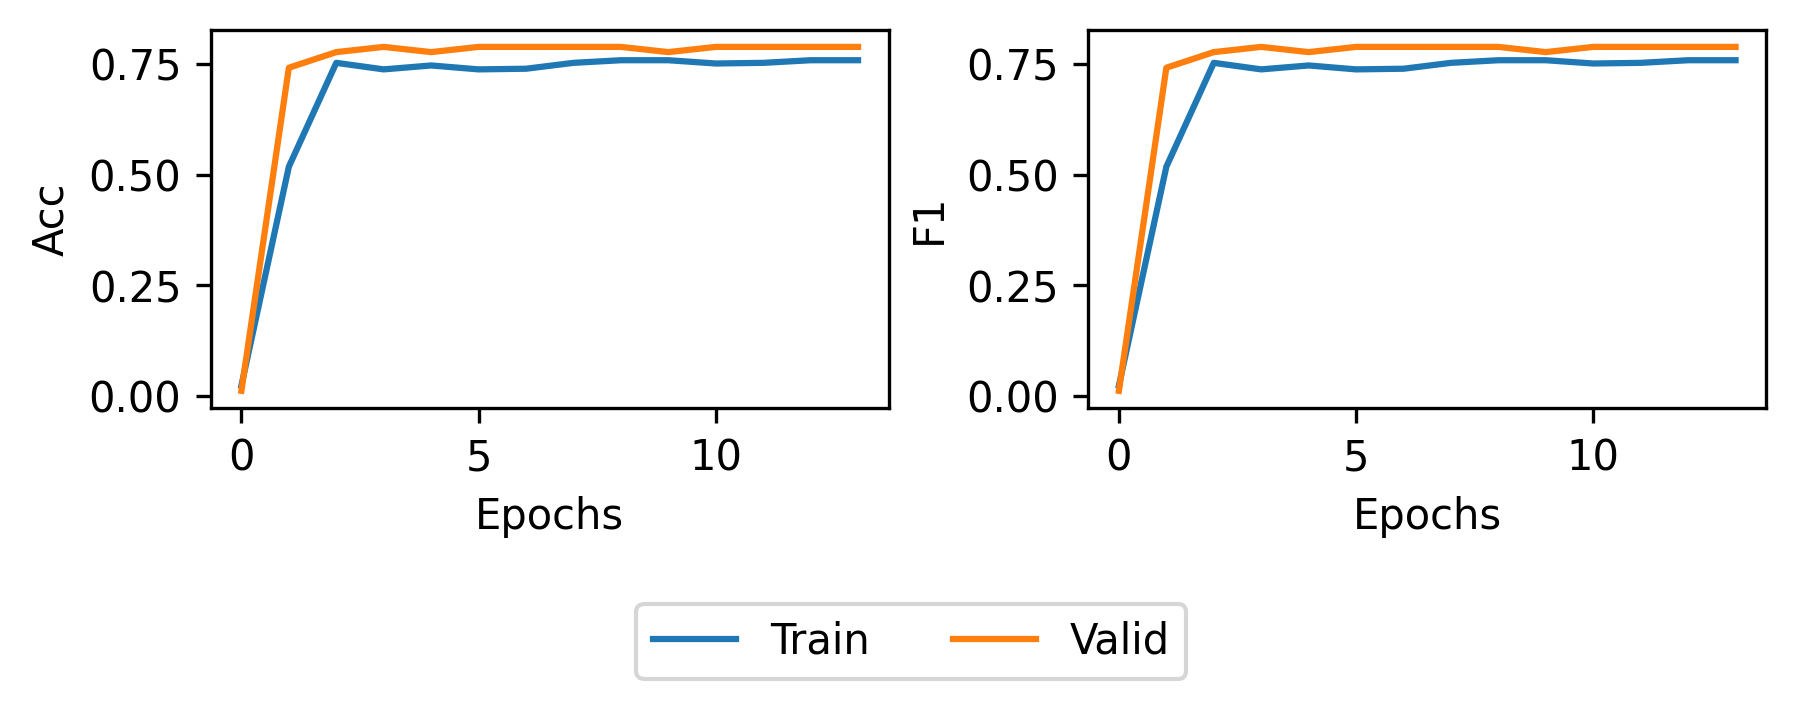

Current Param: {'cat_emb_dim': 4, 'n_a': 2, 'n_d': 2}, Best Valid Acc: 0.78824, Lastest Valid Acc: 0.78824:  50%|█████     | 9/18 [12:01<10:55, 72.80s/it]

{'cat_emb_dim': 4, 'n_a': 2, 'n_d': 2}


=== Epoch 0, Time Taken: 3.8s, Time Left: 1887.7s ===
- Train: Acc: 0.02802, F1: 0.02802
- Valid: Acc: 0.03529, F1: 0.03529


=== Epoch 1, Time Taken: 4.2s, Time Left: 2091.7s ===
- Train: Acc: 0.34218, F1: 0.34218
- Valid: Acc: 0.43529, F1: 0.43529


=== Epoch 2, Time Taken: 3.6s, Time Left: 1799.3s ===
- Train: Acc: 0.63127, F1: 0.63127
- Valid: Acc: 0.55294, F1: 0.55294


=== Epoch 3, Time Taken: 3.7s, Time Left: 1830.4s ===
- Train: Acc: 0.54130, F1: 0.54130
- Valid: Acc: 0.58824, F1: 0.58824


=== Epoch 4, Time Taken: 3.4s, Time Left: 1690.0s ===
- Train: Acc: 0.64749, F1: 0.64749
- Valid: Acc: 0.60000, F1: 0.60000


=== Epoch 5, Time Taken: 3.7s, Time Left: 1844.3s ===
- Train: Acc: 0.61209, F1: 0.61209
- Valid: Acc: 0.58824, F1: 0.58824


=== Epoch 6, Time Taken: 3.5s, Time Left: 1725.3s ===
- Train: Acc: 0.63274, F1: 0.63274
- Valid: Acc: 0.58824, F1: 0.58824


=== Epoch 7, Time Taken: 3.4s, Time Left: 1654.2s ===
- Train: Acc: 0.63569, F1: 0.63569
- Valid: Acc: 0.58824, F1: 0.58824


=== Epoch 8, Time Taken: 3.4s, Time Left: 1653.9s ===
- Train: Acc: 0.61652, F1: 0.61652
- Valid: Acc: 0.60000, F1: 0.60000


=== Epoch 9, Time Taken: 3.1s, Time Left: 1512.0s ===
- Train: Acc: 0.61947, F1: 0.61947
- Valid: Acc: 0.63529, F1: 0.63529


=== Epoch 10, Time Taken: 3.2s, Time Left: 1561.4s ===
- Train: Acc: 0.62537, F1: 0.62537
- Valid: Acc: 0.60000, F1: 0.60000


=== Epoch 11, Time Taken: 3.4s, Time Left: 1654.5s ===
- Train: Acc: 0.64012, F1: 0.64012
- Valid: Acc: 0.60000, F1: 0.60000


=== Epoch 12, Time Taken: 3.5s, Time Left: 1681.5s ===
- Train: Acc: 0.61652, F1: 0.61652
- Valid: Acc: 0.60000, F1: 0.60000


=== Epoch 13, Time Taken: 3.4s, Time Left: 1630.0s ===
- Train: Acc: 0.62094, F1: 0.62094
- Valid: Acc: 0.60000, F1: 0.60000


=== Epoch 14, Time Taken: 3.2s, Time Left: 1528.8s ===
- Train: Acc: 0.63127, F1: 0.63127
- Valid: Acc: 0.60000, F1: 0.60000


=== Epoch 15, Time Taken: 3.2s, Time Left: 1563.9s ===
- Train: Acc: 0.63569, F1: 0.63569
- Valid: Acc: 0.60000, F1: 0.60000


=== Epoch 16, Time Taken: 3.2s, Time Left: 1555.4s ===
- Train: Acc: 0.61652, F1: 0.61652
- Valid: Acc: 0.60000, F1: 0.60000


=== Epoch 17, Time Taken: 3.6s, Time Left: 1727.8s ===
- Train: Acc: 0.63569, F1: 0.63569
- Valid: Acc: 0.72941, F1: 0.72941


=== Epoch 18, Time Taken: 3.6s, Time Left: 1741.4s ===
- Train: Acc: 0.62242, F1: 0.62242
- Valid: Acc: 0.60000, F1: 0.60000


=== Epoch 19, Time Taken: 3.6s, Time Left: 1705.0s ===
- Train: Acc: 0.63127, F1: 0.63127
- Valid: Acc: 0.64706, F1: 0.64706


=== Epoch 20, Time Taken: 3.5s, Time Left: 1689.1s ===
- Train: Acc: 0.63127, F1: 0.63127
- Valid: Acc: 0.72941, F1: 0.72941


=== Epoch 21, Time Taken: 3.2s, Time Left: 1553.0s ===
- Train: Acc: 0.65339, F1: 0.65339
- Valid: Acc: 0.72941, F1: 0.72941


=== Epoch 22, Time Taken: 3.1s, Time Left: 1486.9s ===
- Train: Acc: 0.61652, F1: 0.61652
- Valid: Acc: 0.60000, F1: 0.60000


=== Epoch 23, Time Taken: 3.1s, Time Left: 1456.6s ===
- Train: Acc: 0.63127, F1: 0.63127
- Valid: Acc: 0.60000, F1: 0.60000


=== Epoch 24, Time Taken: 2.6s, Time Left: 1256.1s ===
- Train: Acc: 0.62684, F1: 0.62684
- Valid: Acc: 0.72941, F1: 0.72941


=== Epoch 25, Time Taken: 2.7s, Time Left: 1268.8s ===
- Train: Acc: 0.62389, F1: 0.62389
- Valid: Acc: 0.60000, F1: 0.60000


=== Epoch 26, Time Taken: 3.1s, Time Left: 1450.9s ===
- Train: Acc: 0.63127, F1: 0.63127
- Valid: Acc: 0.60000, F1: 0.60000


=== Epoch 27, Time Taken: 2.9s, Time Left: 1371.1s ===
- Train: Acc: 0.63569, F1: 0.63569
- Valid: Acc: 0.60000, F1: 0.60000
Early Stopping at Epoch 27, Best Validation Acc (0.72941) at Epoch 17.


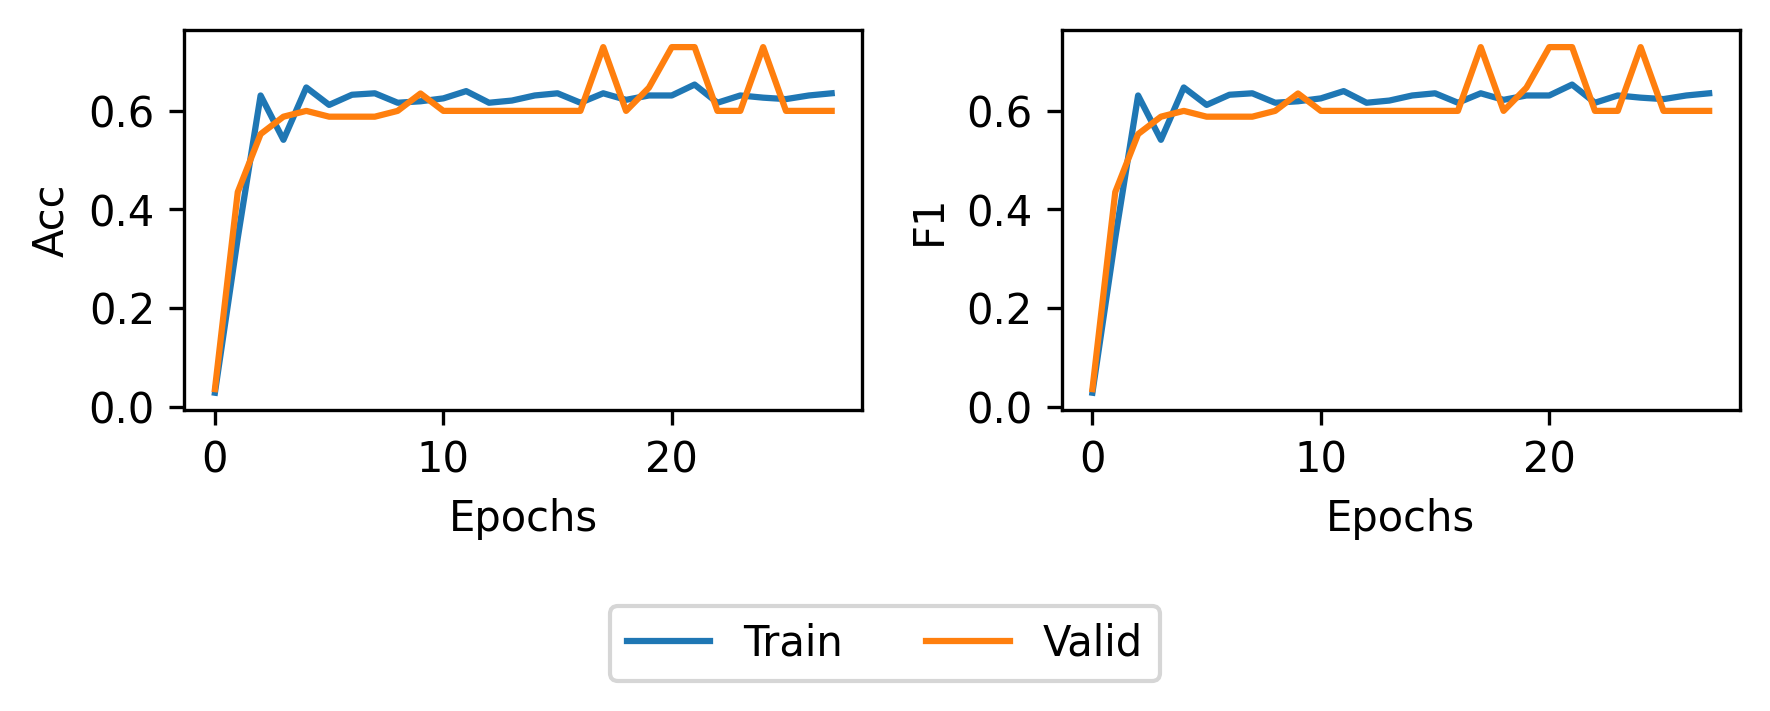

Current Param: {'cat_emb_dim': 4, 'n_a': 2, 'n_d': 4}, Best Valid Acc: 0.78824, Lastest Valid Acc: 0.72941:  56%|█████▌    | 10/18 [13:36<10:35, 79.41s/it]

{'cat_emb_dim': 4, 'n_a': 2, 'n_d': 4}


=== Epoch 0, Time Taken: 3.3s, Time Left: 1628.6s ===
- Train: Acc: 0.06785, F1: 0.06785
- Valid: Acc: 0.34118, F1: 0.34118


=== Epoch 1, Time Taken: 2.7s, Time Left: 1350.3s ===
- Train: Acc: 0.40265, F1: 0.40265
- Valid: Acc: 0.37647, F1: 0.37647


=== Epoch 2, Time Taken: 2.7s, Time Left: 1347.0s ===
- Train: Acc: 0.47345, F1: 0.47345
- Valid: Acc: 0.48235, F1: 0.48235


=== Epoch 3, Time Taken: 2.7s, Time Left: 1336.0s ===
- Train: Acc: 0.53687, F1: 0.53687
- Valid: Acc: 0.62353, F1: 0.62353


=== Epoch 4, Time Taken: 2.9s, Time Left: 1411.9s ===
- Train: Acc: 0.65044, F1: 0.65044
- Valid: Acc: 0.51765, F1: 0.51765


=== Epoch 5, Time Taken: 2.7s, Time Left: 1351.8s ===
- Train: Acc: 0.62684, F1: 0.62684
- Valid: Acc: 0.61176, F1: 0.61176


=== Epoch 6, Time Taken: 2.6s, Time Left: 1272.0s ===
- Train: Acc: 0.65782, F1: 0.65782
- Valid: Acc: 0.60000, F1: 0.60000


=== Epoch 7, Time Taken: 3.0s, Time Left: 1452.0s ===
- Train: Acc: 0.65192, F1: 0.65192
- Valid: Acc: 0.60000, F1: 0.60000


=== Epoch 8, Time Taken: 2.7s, Time Left: 1333.4s ===
- Train: Acc: 0.66519, F1: 0.66519
- Valid: Acc: 0.60000, F1: 0.60000


=== Epoch 9, Time Taken: 3.0s, Time Left: 1451.7s ===
- Train: Acc: 0.67699, F1: 0.67699
- Valid: Acc: 0.76471, F1: 0.76471


=== Epoch 10, Time Taken: 3.0s, Time Left: 1462.9s ===
- Train: Acc: 0.73451, F1: 0.73451
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 11, Time Taken: 3.3s, Time Left: 1616.0s ===
- Train: Acc: 0.75221, F1: 0.75221
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 12, Time Taken: 2.9s, Time Left: 1403.7s ===
- Train: Acc: 0.74926, F1: 0.74926
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 13, Time Taken: 3.7s, Time Left: 1798.6s ===
- Train: Acc: 0.75516, F1: 0.75516
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 14, Time Taken: 3.6s, Time Left: 1764.5s ===
- Train: Acc: 0.75074, F1: 0.75074
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 15, Time Taken: 3.1s, Time Left: 1505.8s ===
- Train: Acc: 0.75221, F1: 0.75221
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 16, Time Taken: 3.0s, Time Left: 1433.7s ===
- Train: Acc: 0.74926, F1: 0.74926
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 17, Time Taken: 3.4s, Time Left: 1631.4s ===
- Train: Acc: 0.75516, F1: 0.75516
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 18, Time Taken: 4.1s, Time Left: 1987.5s ===
- Train: Acc: 0.75664, F1: 0.75664
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 19, Time Taken: 4.0s, Time Left: 1929.6s ===
- Train: Acc: 0.75369, F1: 0.75369
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 20, Time Taken: 4.1s, Time Left: 1966.6s ===
- Train: Acc: 0.75664, F1: 0.75664
- Valid: Acc: 0.77647, F1: 0.77647
Early Stopping at Epoch 20, Best Validation Acc (0.78824) at Epoch 10.


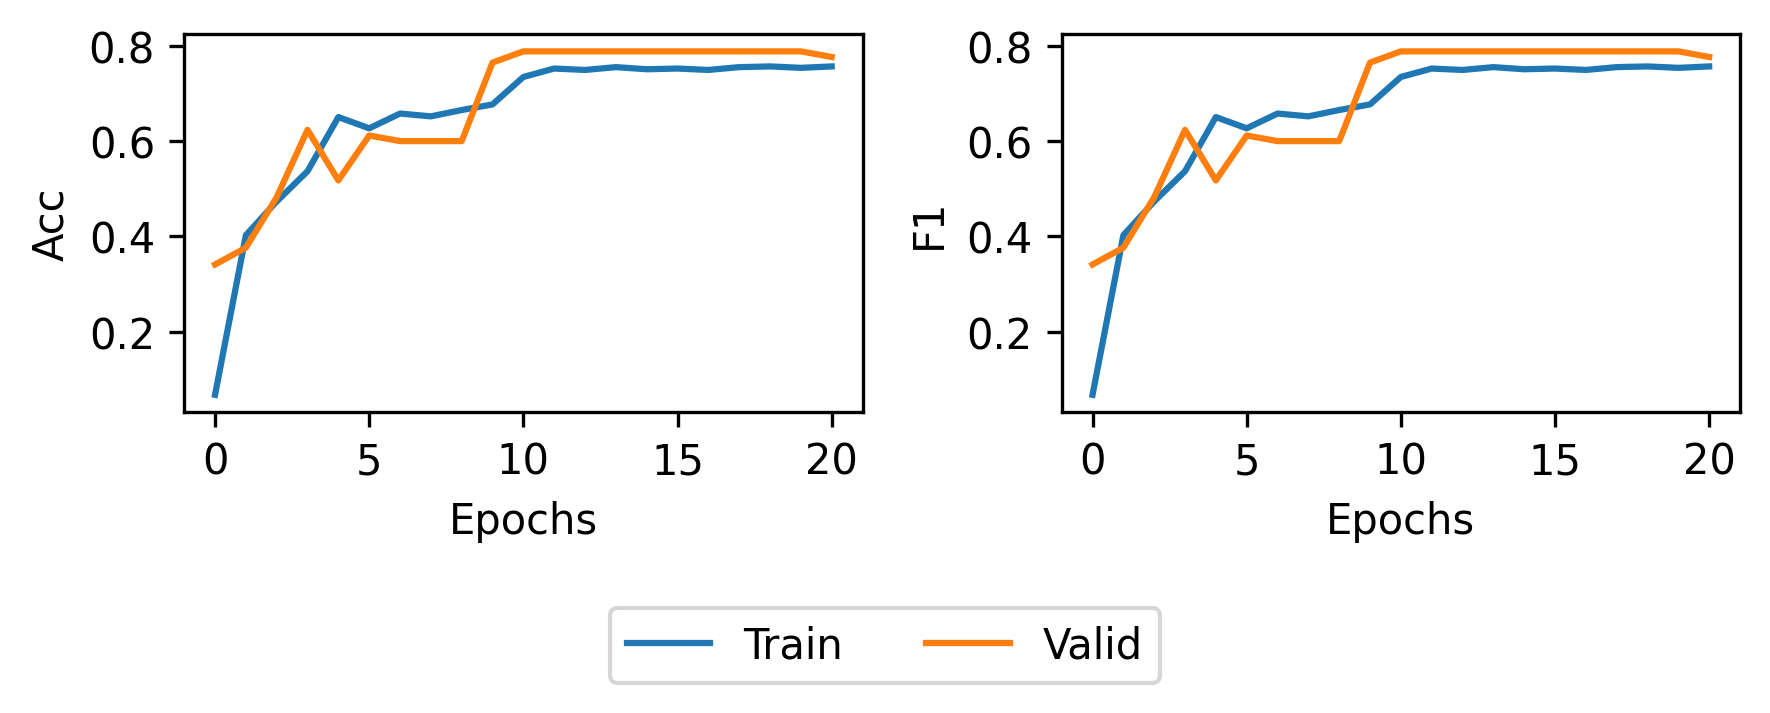

Current Param: {'cat_emb_dim': 4, 'n_a': 2, 'n_d': 8}, Best Valid Acc: 0.78824, Lastest Valid Acc: 0.78824:  61%|██████    | 11/18 [14:43<08:49, 75.60s/it]

{'cat_emb_dim': 4, 'n_a': 2, 'n_d': 8}


=== Epoch 0, Time Taken: 3.5s, Time Left: 1770.4s ===
- Train: Acc: 0.27139, F1: 0.27139
- Valid: Acc: 0.31765, F1: 0.31765


=== Epoch 1, Time Taken: 4.6s, Time Left: 2284.6s ===
- Train: Acc: 0.43363, F1: 0.43363
- Valid: Acc: 0.56471, F1: 0.56471


=== Epoch 2, Time Taken: 4.1s, Time Left: 2020.6s ===
- Train: Acc: 0.66372, F1: 0.66372
- Valid: Acc: 0.74118, F1: 0.74118


=== Epoch 3, Time Taken: 4.0s, Time Left: 2000.6s ===
- Train: Acc: 0.72419, F1: 0.72419
- Valid: Acc: 0.72941, F1: 0.72941


=== Epoch 4, Time Taken: 3.3s, Time Left: 1644.3s ===
- Train: Acc: 0.73451, F1: 0.73451
- Valid: Acc: 0.76471, F1: 0.76471


=== Epoch 5, Time Taken: 3.2s, Time Left: 1601.7s ===
- Train: Acc: 0.72566, F1: 0.72566
- Valid: Acc: 0.74118, F1: 0.74118


=== Epoch 6, Time Taken: 3.8s, Time Left: 1852.3s ===
- Train: Acc: 0.73746, F1: 0.73746
- Valid: Acc: 0.76471, F1: 0.76471


=== Epoch 7, Time Taken: 3.6s, Time Left: 1763.2s ===
- Train: Acc: 0.74336, F1: 0.74336
- Valid: Acc: 0.72941, F1: 0.72941


=== Epoch 8, Time Taken: 3.7s, Time Left: 1840.9s ===
- Train: Acc: 0.73009, F1: 0.73009
- Valid: Acc: 0.72941, F1: 0.72941


=== Epoch 9, Time Taken: 3.7s, Time Left: 1829.4s ===
- Train: Acc: 0.73009, F1: 0.73009
- Valid: Acc: 0.72941, F1: 0.72941


=== Epoch 10, Time Taken: 3.2s, Time Left: 1581.1s ===
- Train: Acc: 0.73156, F1: 0.73156
- Valid: Acc: 0.72941, F1: 0.72941


=== Epoch 11, Time Taken: 3.6s, Time Left: 1733.7s ===
- Train: Acc: 0.73599, F1: 0.73599
- Valid: Acc: 0.76471, F1: 0.76471


=== Epoch 12, Time Taken: 2.6s, Time Left: 1264.5s ===
- Train: Acc: 0.73894, F1: 0.73894
- Valid: Acc: 0.76471, F1: 0.76471


=== Epoch 13, Time Taken: 2.7s, Time Left: 1327.8s ===
- Train: Acc: 0.73746, F1: 0.73746
- Valid: Acc: 0.76471, F1: 0.76471


=== Epoch 14, Time Taken: 3.0s, Time Left: 1446.5s ===
- Train: Acc: 0.74484, F1: 0.74484
- Valid: Acc: 0.77647, F1: 0.77647


=== Epoch 15, Time Taken: 3.1s, Time Left: 1517.0s ===
- Train: Acc: 0.74189, F1: 0.74189
- Valid: Acc: 0.76471, F1: 0.76471


=== Epoch 16, Time Taken: 3.2s, Time Left: 1564.5s ===
- Train: Acc: 0.74631, F1: 0.74631
- Valid: Acc: 0.76471, F1: 0.76471


=== Epoch 17, Time Taken: 3.2s, Time Left: 1537.6s ===
- Train: Acc: 0.75074, F1: 0.75074
- Valid: Acc: 0.76471, F1: 0.76471


=== Epoch 18, Time Taken: 3.3s, Time Left: 1596.5s ===
- Train: Acc: 0.75369, F1: 0.75369
- Valid: Acc: 0.76471, F1: 0.76471


=== Epoch 19, Time Taken: 3.4s, Time Left: 1609.8s ===
- Train: Acc: 0.75516, F1: 0.75516
- Valid: Acc: 0.76471, F1: 0.76471


=== Epoch 20, Time Taken: 3.2s, Time Left: 1553.0s ===
- Train: Acc: 0.75664, F1: 0.75664
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 21, Time Taken: 3.4s, Time Left: 1610.3s ===
- Train: Acc: 0.75369, F1: 0.75369
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 22, Time Taken: 3.7s, Time Left: 1742.7s ===
- Train: Acc: 0.75811, F1: 0.75811
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 23, Time Taken: 3.4s, Time Left: 1606.9s ===
- Train: Acc: 0.75369, F1: 0.75369
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 24, Time Taken: 4.5s, Time Left: 2139.5s ===
- Train: Acc: 0.75811, F1: 0.75811
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 25, Time Taken: 3.5s, Time Left: 1644.7s ===
- Train: Acc: 0.75811, F1: 0.75811
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 26, Time Taken: 2.8s, Time Left: 1322.8s ===
- Train: Acc: 0.75811, F1: 0.75811
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 27, Time Taken: 3.0s, Time Left: 1425.5s ===
- Train: Acc: 0.75811, F1: 0.75811
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 28, Time Taken: 3.1s, Time Left: 1478.6s ===
- Train: Acc: 0.75811, F1: 0.75811
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 29, Time Taken: 3.4s, Time Left: 1593.6s ===
- Train: Acc: 0.75811, F1: 0.75811
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 30, Time Taken: 2.8s, Time Left: 1322.5s ===
- Train: Acc: 0.75811, F1: 0.75811
- Valid: Acc: 0.78824, F1: 0.78824
Early Stopping at Epoch 30, Best Validation Acc (0.78824) at Epoch 20.


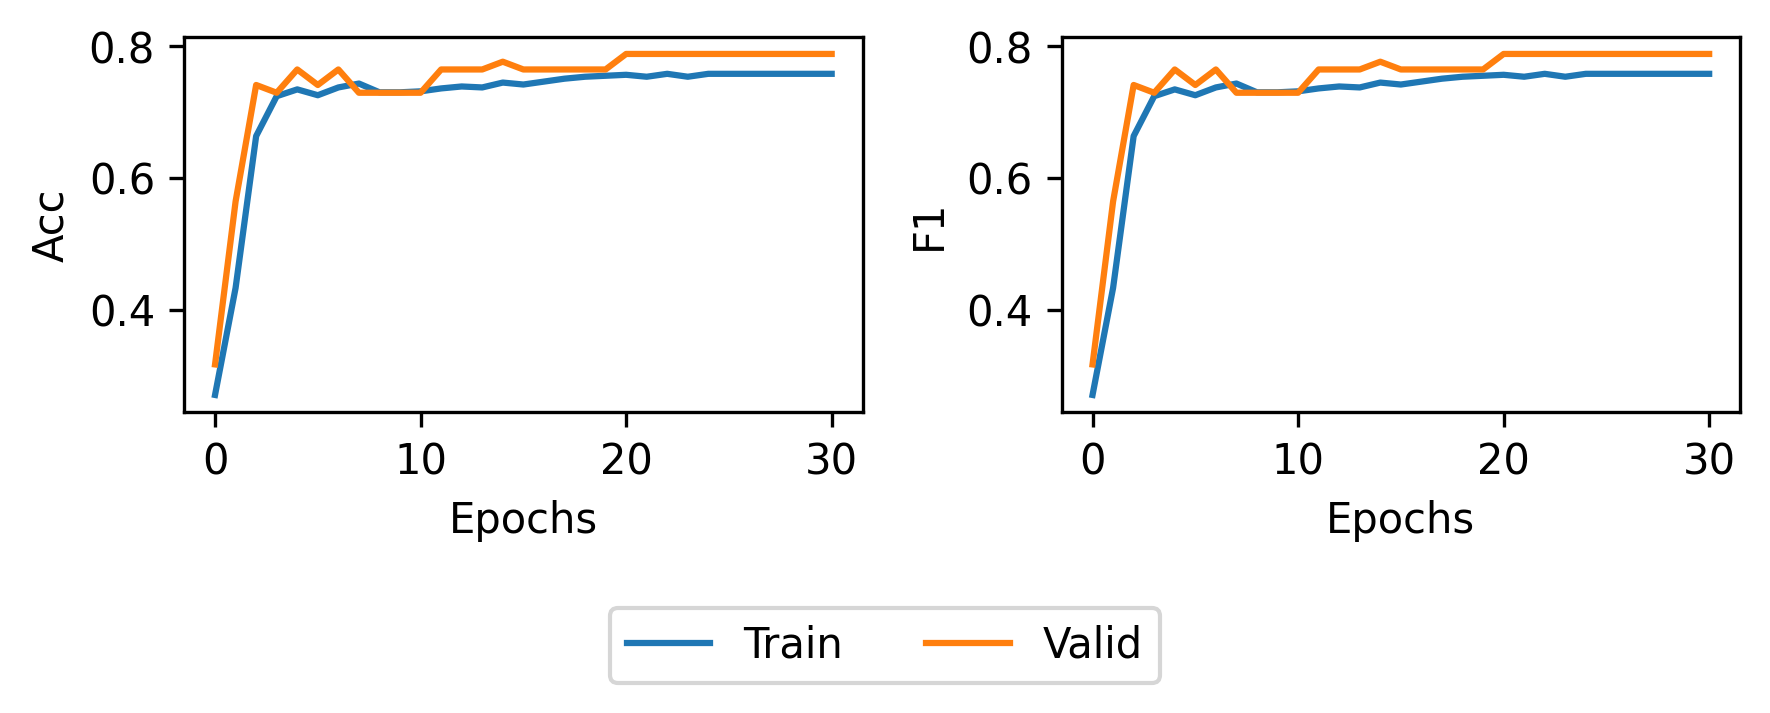

Current Param: {'cat_emb_dim': 4, 'n_a': 4, 'n_d': 2}, Best Valid Acc: 0.78824, Lastest Valid Acc: 0.78824:  67%|██████▋   | 12/18 [16:29<08:29, 84.89s/it]

{'cat_emb_dim': 4, 'n_a': 4, 'n_d': 2}


=== Epoch 0, Time Taken: 3.2s, Time Left: 1574.1s ===
- Train: Acc: 0.11947, F1: 0.11947
- Valid: Acc: 0.16471, F1: 0.16471


=== Epoch 1, Time Taken: 2.9s, Time Left: 1444.0s ===
- Train: Acc: 0.42330, F1: 0.42330
- Valid: Acc: 0.45882, F1: 0.45882


=== Epoch 2, Time Taken: 3.3s, Time Left: 1631.3s ===
- Train: Acc: 0.44248, F1: 0.44248
- Valid: Acc: 0.50588, F1: 0.50588


=== Epoch 3, Time Taken: 3.4s, Time Left: 1680.5s ===
- Train: Acc: 0.59145, F1: 0.59145
- Valid: Acc: 0.60000, F1: 0.60000


=== Epoch 4, Time Taken: 2.8s, Time Left: 1403.5s ===
- Train: Acc: 0.60914, F1: 0.60914
- Valid: Acc: 0.61176, F1: 0.61176


=== Epoch 5, Time Taken: 3.2s, Time Left: 1582.1s ===
- Train: Acc: 0.61062, F1: 0.61062
- Valid: Acc: 0.65882, F1: 0.65882


=== Epoch 6, Time Taken: 3.0s, Time Left: 1489.1s ===
- Train: Acc: 0.61504, F1: 0.61504
- Valid: Acc: 0.64706, F1: 0.64706


=== Epoch 7, Time Taken: 3.5s, Time Left: 1732.3s ===
- Train: Acc: 0.64159, F1: 0.64159
- Valid: Acc: 0.63529, F1: 0.63529


=== Epoch 8, Time Taken: 3.0s, Time Left: 1466.6s ===
- Train: Acc: 0.59882, F1: 0.59882
- Valid: Acc: 0.61176, F1: 0.61176


=== Epoch 9, Time Taken: 3.3s, Time Left: 1617.5s ===
- Train: Acc: 0.61652, F1: 0.61652
- Valid: Acc: 0.65882, F1: 0.65882


=== Epoch 10, Time Taken: 3.0s, Time Left: 1446.5s ===
- Train: Acc: 0.60177, F1: 0.60177
- Valid: Acc: 0.64706, F1: 0.64706


=== Epoch 11, Time Taken: 3.5s, Time Left: 1719.6s ===
- Train: Acc: 0.63422, F1: 0.63422
- Valid: Acc: 0.47059, F1: 0.47059


=== Epoch 12, Time Taken: 3.5s, Time Left: 1698.1s ===
- Train: Acc: 0.56785, F1: 0.56785
- Valid: Acc: 0.55294, F1: 0.55294


=== Epoch 13, Time Taken: 3.5s, Time Left: 1723.5s ===
- Train: Acc: 0.61947, F1: 0.61947
- Valid: Acc: 0.63529, F1: 0.63529


=== Epoch 14, Time Taken: 3.5s, Time Left: 1705.5s ===
- Train: Acc: 0.65339, F1: 0.65339
- Valid: Acc: 0.64706, F1: 0.64706


=== Epoch 15, Time Taken: 3.4s, Time Left: 1641.8s ===
- Train: Acc: 0.62979, F1: 0.62979
- Valid: Acc: 0.54118, F1: 0.54118
Early Stopping at Epoch 15, Best Validation Acc (0.65882) at Epoch 5.


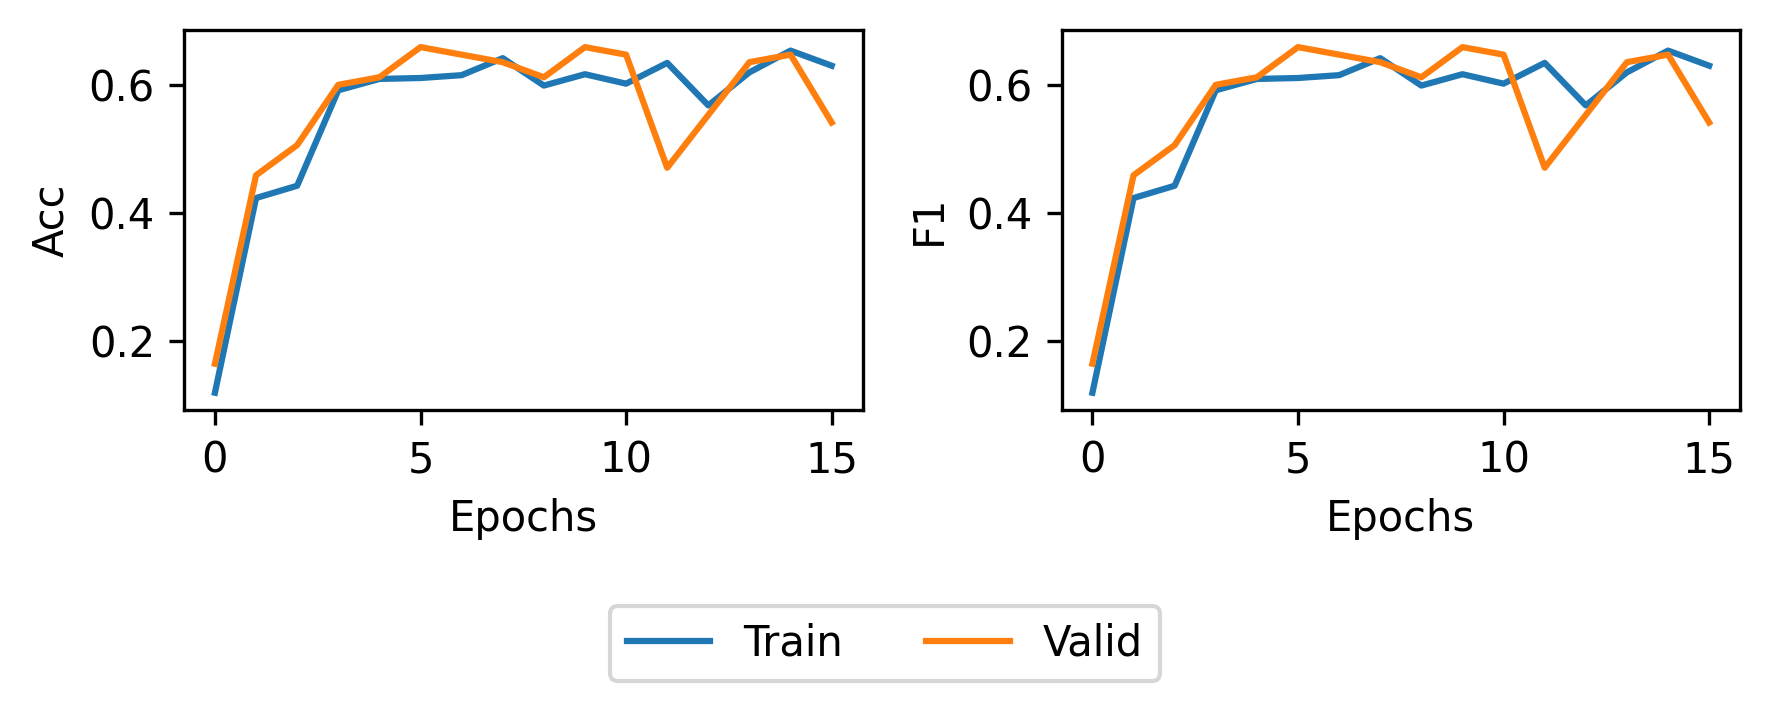

Current Param: {'cat_emb_dim': 4, 'n_a': 4, 'n_d': 4}, Best Valid Acc: 0.78824, Lastest Valid Acc: 0.65882:  72%|███████▏  | 13/18 [17:21<06:15, 75.08s/it]

{'cat_emb_dim': 4, 'n_a': 4, 'n_d': 4}


=== Epoch 0, Time Taken: 3.4s, Time Left: 1695.4s ===
- Train: Acc: 0.03097, F1: 0.03097
- Valid: Acc: 0.02353, F1: 0.02353


=== Epoch 1, Time Taken: 3.4s, Time Left: 1687.6s ===
- Train: Acc: 0.48968, F1: 0.48968
- Valid: Acc: 0.72941, F1: 0.72941


=== Epoch 2, Time Taken: 3.1s, Time Left: 1529.6s ===
- Train: Acc: 0.69322, F1: 0.69322
- Valid: Acc: 0.72941, F1: 0.72941


=== Epoch 3, Time Taken: 2.7s, Time Left: 1320.7s ===
- Train: Acc: 0.71976, F1: 0.71976
- Valid: Acc: 0.72941, F1: 0.72941


=== Epoch 4, Time Taken: 3.2s, Time Left: 1559.8s ===
- Train: Acc: 0.72566, F1: 0.72566
- Valid: Acc: 0.72941, F1: 0.72941


=== Epoch 5, Time Taken: 3.7s, Time Left: 1803.2s ===
- Train: Acc: 0.72861, F1: 0.72861
- Valid: Acc: 0.72941, F1: 0.72941


=== Epoch 6, Time Taken: 3.4s, Time Left: 1683.9s ===
- Train: Acc: 0.72861, F1: 0.72861
- Valid: Acc: 0.72941, F1: 0.72941


=== Epoch 7, Time Taken: 3.5s, Time Left: 1705.7s ===
- Train: Acc: 0.72861, F1: 0.72861
- Valid: Acc: 0.72941, F1: 0.72941


=== Epoch 8, Time Taken: 3.3s, Time Left: 1599.0s ===
- Train: Acc: 0.73156, F1: 0.73156
- Valid: Acc: 0.72941, F1: 0.72941


=== Epoch 9, Time Taken: 3.2s, Time Left: 1572.8s ===
- Train: Acc: 0.71681, F1: 0.71681
- Valid: Acc: 0.72941, F1: 0.72941


=== Epoch 10, Time Taken: 3.3s, Time Left: 1624.5s ===
- Train: Acc: 0.72861, F1: 0.72861
- Valid: Acc: 0.72941, F1: 0.72941


=== Epoch 11, Time Taken: 3.6s, Time Left: 1742.0s ===
- Train: Acc: 0.72861, F1: 0.72861
- Valid: Acc: 0.72941, F1: 0.72941
Early Stopping at Epoch 11, Best Validation Acc (0.72941) at Epoch 1.


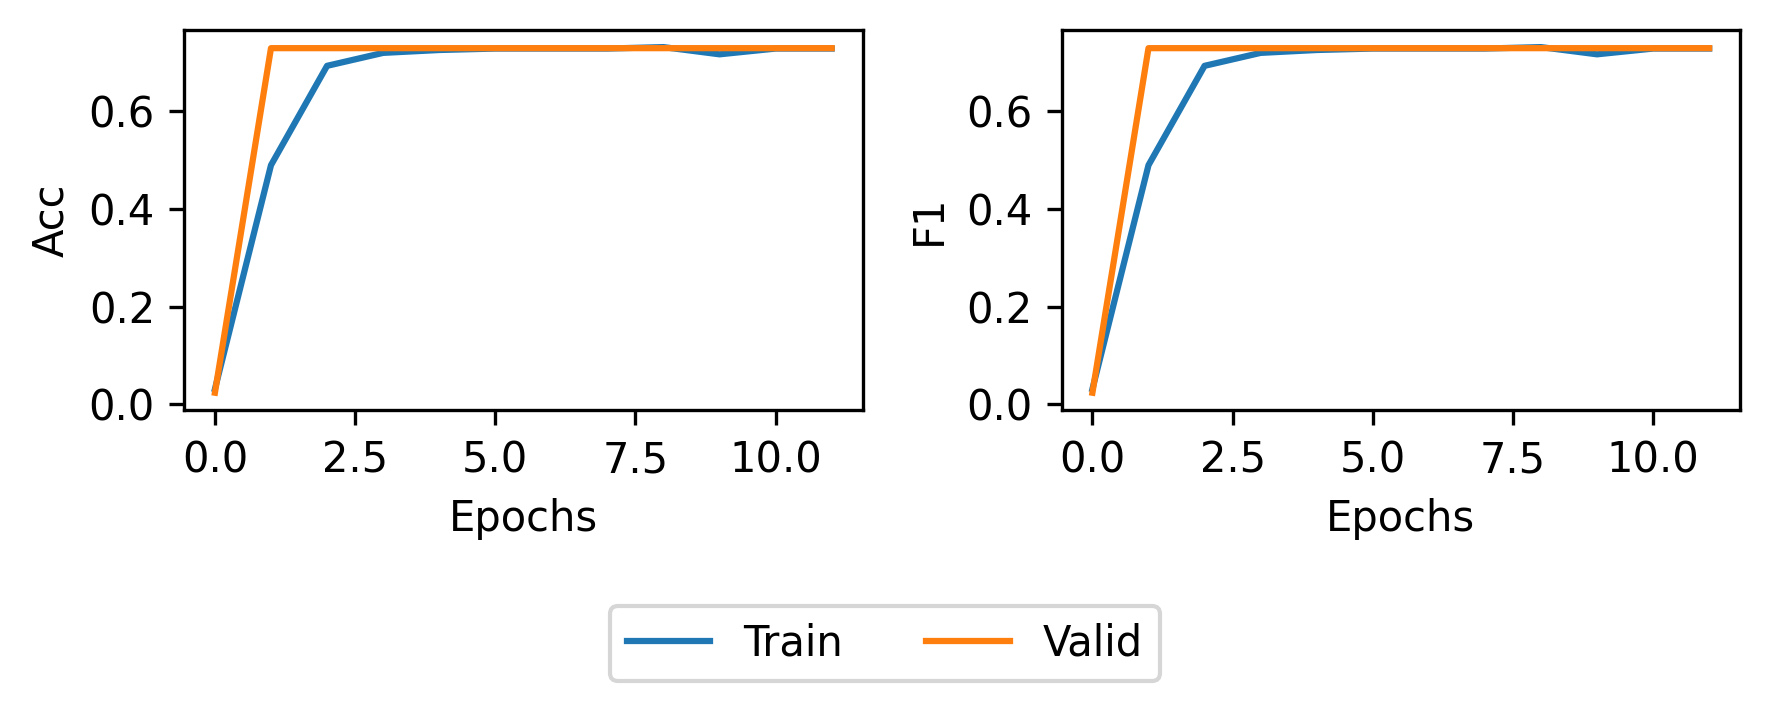

Current Param: {'cat_emb_dim': 4, 'n_a': 4, 'n_d': 8}, Best Valid Acc: 0.78824, Lastest Valid Acc: 0.72941:  78%|███████▊  | 14/18 [18:01<04:18, 64.51s/it]

{'cat_emb_dim': 4, 'n_a': 4, 'n_d': 8}


=== Epoch 0, Time Taken: 3.5s, Time Left: 1756.8s ===
- Train: Acc: 0.01917, F1: 0.01917
- Valid: Acc: 0.05882, F1: 0.05882


=== Epoch 1, Time Taken: 2.8s, Time Left: 1416.4s ===
- Train: Acc: 0.40708, F1: 0.40708
- Valid: Acc: 0.44706, F1: 0.44706


=== Epoch 2, Time Taken: 3.2s, Time Left: 1607.5s ===
- Train: Acc: 0.61357, F1: 0.61357
- Valid: Acc: 0.61176, F1: 0.61176


=== Epoch 3, Time Taken: 3.1s, Time Left: 1518.7s ===
- Train: Acc: 0.71534, F1: 0.71534
- Valid: Acc: 0.65882, F1: 0.65882


=== Epoch 4, Time Taken: 3.3s, Time Left: 1617.1s ===
- Train: Acc: 0.72419, F1: 0.72419
- Valid: Acc: 0.72941, F1: 0.72941


=== Epoch 5, Time Taken: 3.2s, Time Left: 1585.4s ===
- Train: Acc: 0.72861, F1: 0.72861
- Valid: Acc: 0.72941, F1: 0.72941


=== Epoch 6, Time Taken: 3.2s, Time Left: 1593.8s ===
- Train: Acc: 0.72861, F1: 0.72861
- Valid: Acc: 0.72941, F1: 0.72941


=== Epoch 7, Time Taken: 3.1s, Time Left: 1502.0s ===
- Train: Acc: 0.72861, F1: 0.72861
- Valid: Acc: 0.71765, F1: 0.71765


=== Epoch 8, Time Taken: 3.2s, Time Left: 1553.8s ===
- Train: Acc: 0.72861, F1: 0.72861
- Valid: Acc: 0.72941, F1: 0.72941


=== Epoch 9, Time Taken: 3.6s, Time Left: 1747.2s ===
- Train: Acc: 0.72861, F1: 0.72861
- Valid: Acc: 0.72941, F1: 0.72941


=== Epoch 10, Time Taken: 3.1s, Time Left: 1540.2s ===
- Train: Acc: 0.72861, F1: 0.72861
- Valid: Acc: 0.72941, F1: 0.72941


=== Epoch 11, Time Taken: 3.1s, Time Left: 1532.1s ===
- Train: Acc: 0.72861, F1: 0.72861
- Valid: Acc: 0.72941, F1: 0.72941


=== Epoch 12, Time Taken: 3.4s, Time Left: 1670.5s ===
- Train: Acc: 0.72861, F1: 0.72861
- Valid: Acc: 0.72941, F1: 0.72941


=== Epoch 13, Time Taken: 3.1s, Time Left: 1491.8s ===
- Train: Acc: 0.72861, F1: 0.72861
- Valid: Acc: 0.72941, F1: 0.72941


=== Epoch 14, Time Taken: 3.0s, Time Left: 1476.4s ===
- Train: Acc: 0.72861, F1: 0.72861
- Valid: Acc: 0.72941, F1: 0.72941
Early Stopping at Epoch 14, Best Validation Acc (0.72941) at Epoch 4.


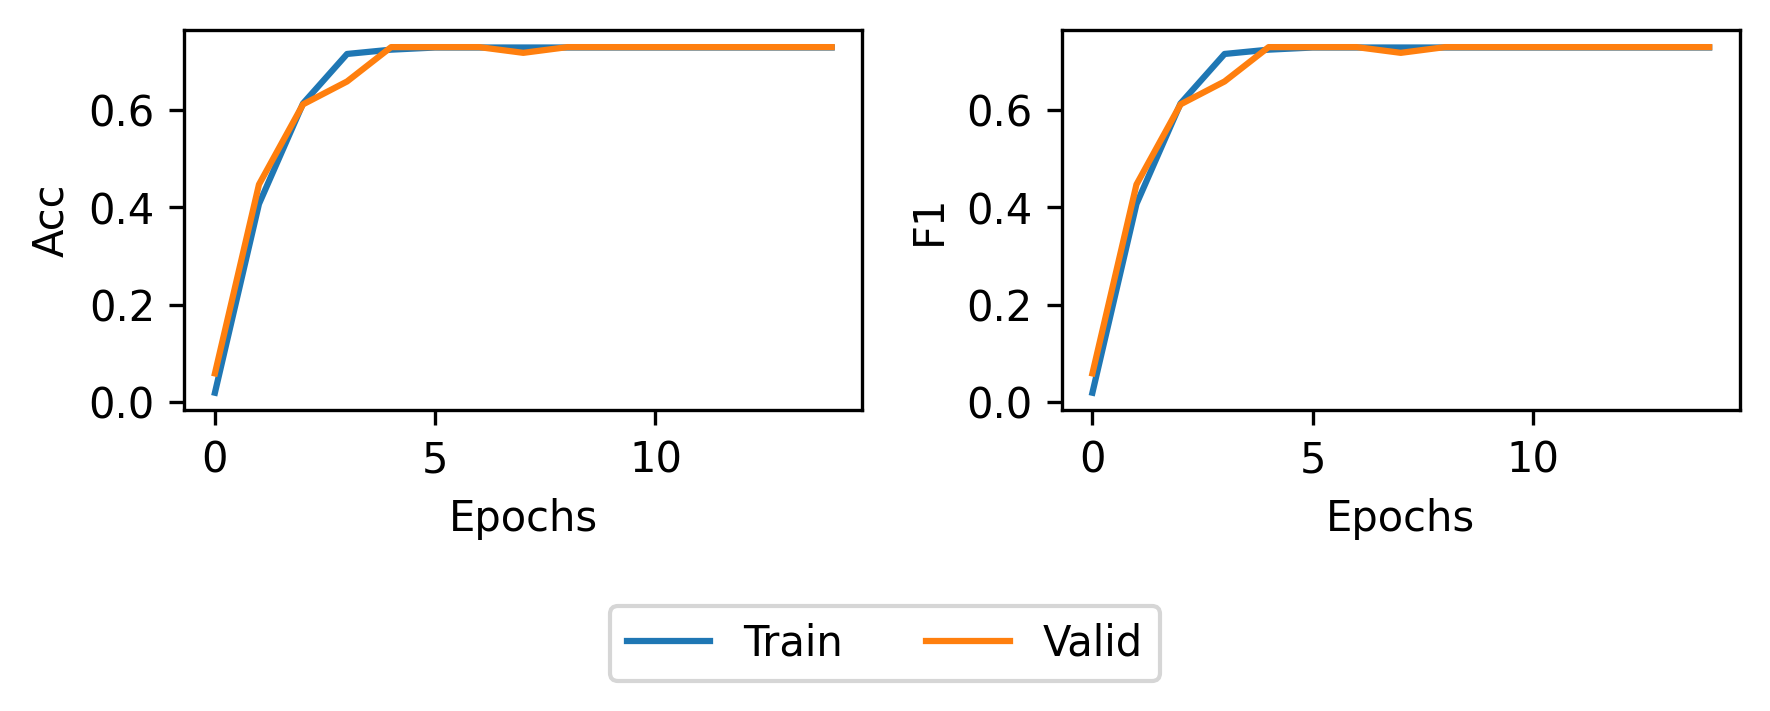

Current Param: {'cat_emb_dim': 4, 'n_a': 8, 'n_d': 2}, Best Valid Acc: 0.78824, Lastest Valid Acc: 0.72941:  83%|████████▎ | 15/18 [18:50<02:58, 59.65s/it]

{'cat_emb_dim': 4, 'n_a': 8, 'n_d': 2}


=== Epoch 0, Time Taken: 3.7s, Time Left: 1852.1s ===
- Train: Acc: 0.00147, F1: 0.00147
- Valid: Acc: 0.00000, F1: 0.00000


=== Epoch 1, Time Taken: 3.6s, Time Left: 1808.5s ===
- Train: Acc: 0.00000, F1: 0.00000
- Valid: Acc: 0.00000, F1: 0.00000


=== Epoch 2, Time Taken: 3.3s, Time Left: 1632.1s ===
- Train: Acc: 0.00000, F1: 0.00000
- Valid: Acc: 0.00000, F1: 0.00000


=== Epoch 3, Time Taken: 3.3s, Time Left: 1643.0s ===
- Train: Acc: 0.00000, F1: 0.00000
- Valid: Acc: 0.00000, F1: 0.00000


=== Epoch 4, Time Taken: 3.5s, Time Left: 1732.1s ===
- Train: Acc: 0.00000, F1: 0.00000
- Valid: Acc: 0.00000, F1: 0.00000


=== Epoch 5, Time Taken: 3.3s, Time Left: 1647.6s ===
- Train: Acc: 0.00000, F1: 0.00000
- Valid: Acc: 0.00000, F1: 0.00000


=== Epoch 6, Time Taken: 3.8s, Time Left: 1851.1s ===
- Train: Acc: 0.00000, F1: 0.00000
- Valid: Acc: 0.00000, F1: 0.00000


=== Epoch 7, Time Taken: 3.4s, Time Left: 1686.0s ===
- Train: Acc: 0.00000, F1: 0.00000
- Valid: Acc: 0.00000, F1: 0.00000


=== Epoch 8, Time Taken: 2.8s, Time Left: 1398.9s ===
- Train: Acc: 0.00000, F1: 0.00000
- Valid: Acc: 0.00000, F1: 0.00000


=== Epoch 9, Time Taken: 3.0s, Time Left: 1486.4s ===
- Train: Acc: 0.00000, F1: 0.00000
- Valid: Acc: 0.00000, F1: 0.00000


=== Epoch 10, Time Taken: 3.1s, Time Left: 1536.8s ===
- Train: Acc: 0.00000, F1: 0.00000
- Valid: Acc: 0.00000, F1: 0.00000
Early Stopping at Epoch 10, Best Validation Acc (0.00000) at Epoch 0.


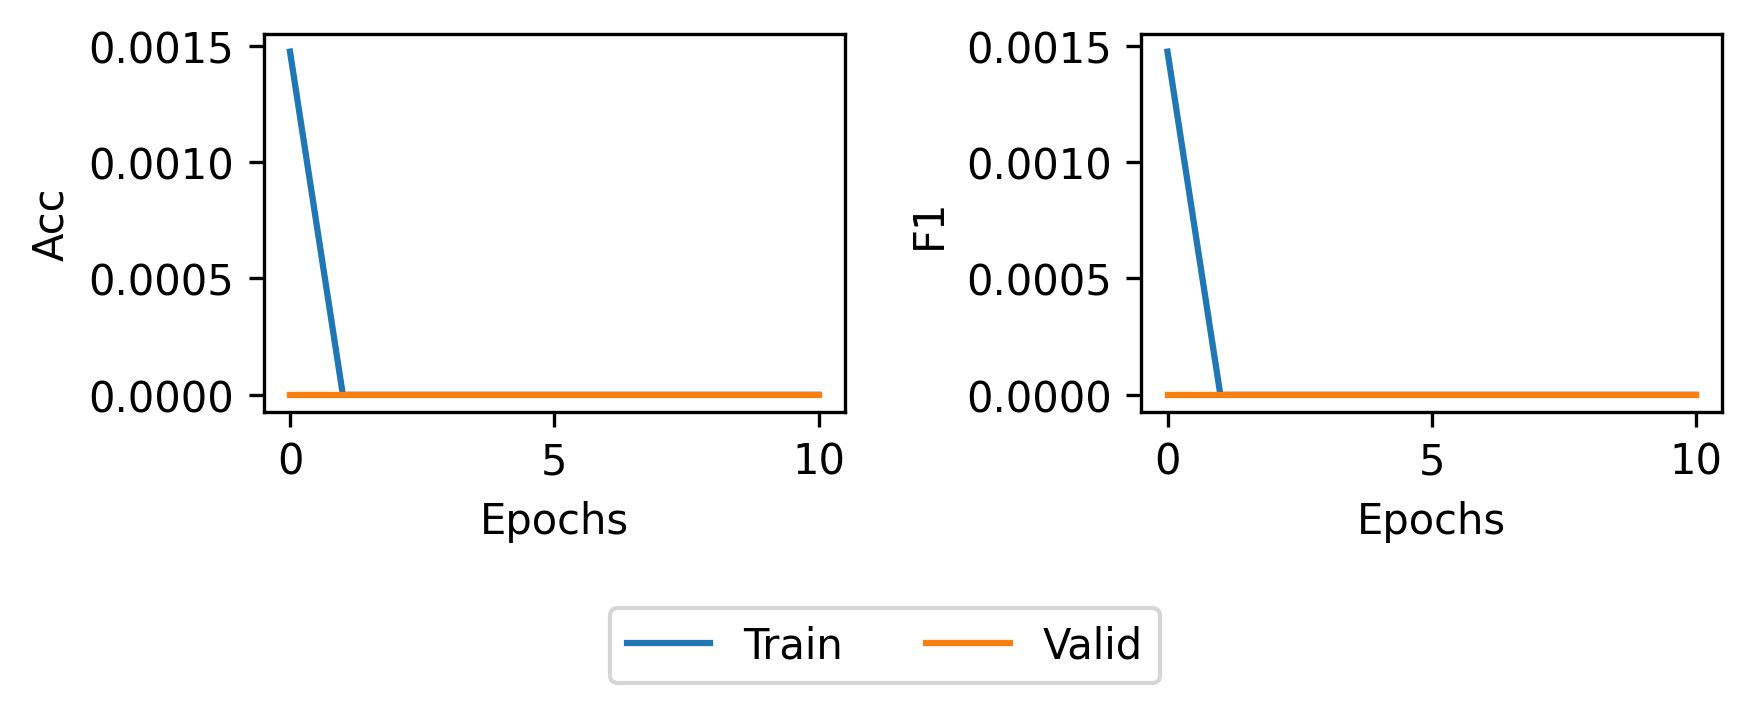

Current Param: {'cat_emb_dim': 4, 'n_a': 8, 'n_d': 4}, Best Valid Acc: 0.78824, Lastest Valid Acc: 0.00000:  89%|████████▉ | 16/18 [19:27<01:45, 52.95s/it]

{'cat_emb_dim': 4, 'n_a': 8, 'n_d': 4}


=== Epoch 0, Time Taken: 3.9s, Time Left: 1963.9s ===
- Train: Acc: 0.14454, F1: 0.14454
- Valid: Acc: 0.20000, F1: 0.20000


=== Epoch 1, Time Taken: 3.9s, Time Left: 1954.1s ===
- Train: Acc: 0.59145, F1: 0.59145
- Valid: Acc: 0.72941, F1: 0.72941


=== Epoch 2, Time Taken: 3.7s, Time Left: 1860.4s ===
- Train: Acc: 0.73451, F1: 0.73451
- Valid: Acc: 0.72941, F1: 0.72941


=== Epoch 3, Time Taken: 3.4s, Time Left: 1686.4s ===
- Train: Acc: 0.72861, F1: 0.72861
- Valid: Acc: 0.72941, F1: 0.72941


=== Epoch 4, Time Taken: 3.6s, Time Left: 1776.5s ===
- Train: Acc: 0.72861, F1: 0.72861
- Valid: Acc: 0.67059, F1: 0.67059


=== Epoch 5, Time Taken: 3.6s, Time Left: 1775.7s ===
- Train: Acc: 0.73009, F1: 0.73009
- Valid: Acc: 0.72941, F1: 0.72941


=== Epoch 6, Time Taken: 3.4s, Time Left: 1668.2s ===
- Train: Acc: 0.73009, F1: 0.73009
- Valid: Acc: 0.72941, F1: 0.72941


=== Epoch 7, Time Taken: 3.2s, Time Left: 1552.3s ===
- Train: Acc: 0.73156, F1: 0.73156
- Valid: Acc: 0.72941, F1: 0.72941


=== Epoch 8, Time Taken: 3.9s, Time Left: 1927.8s ===
- Train: Acc: 0.73599, F1: 0.73599
- Valid: Acc: 0.76471, F1: 0.76471


=== Epoch 9, Time Taken: 3.5s, Time Left: 1730.0s ===
- Train: Acc: 0.74041, F1: 0.74041
- Valid: Acc: 0.76471, F1: 0.76471


=== Epoch 10, Time Taken: 3.6s, Time Left: 1779.6s ===
- Train: Acc: 0.74336, F1: 0.74336
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 11, Time Taken: 3.6s, Time Left: 1759.5s ===
- Train: Acc: 0.74189, F1: 0.74189
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 12, Time Taken: 3.7s, Time Left: 1823.1s ===
- Train: Acc: 0.75074, F1: 0.75074
- Valid: Acc: 0.75294, F1: 0.75294


=== Epoch 13, Time Taken: 3.3s, Time Left: 1606.6s ===
- Train: Acc: 0.74926, F1: 0.74926
- Valid: Acc: 0.76471, F1: 0.76471


=== Epoch 14, Time Taken: 3.5s, Time Left: 1689.6s ===
- Train: Acc: 0.74779, F1: 0.74779
- Valid: Acc: 0.76471, F1: 0.76471


=== Epoch 15, Time Taken: 3.5s, Time Left: 1685.3s ===
- Train: Acc: 0.74926, F1: 0.74926
- Valid: Acc: 0.77647, F1: 0.77647


=== Epoch 16, Time Taken: 3.2s, Time Left: 1531.1s ===
- Train: Acc: 0.74189, F1: 0.74189
- Valid: Acc: 0.74118, F1: 0.74118


=== Epoch 17, Time Taken: 2.8s, Time Left: 1339.8s ===
- Train: Acc: 0.74189, F1: 0.74189
- Valid: Acc: 0.75294, F1: 0.75294


=== Epoch 18, Time Taken: 3.0s, Time Left: 1446.0s ===
- Train: Acc: 0.74189, F1: 0.74189
- Valid: Acc: 0.72941, F1: 0.72941


=== Epoch 19, Time Taken: 3.2s, Time Left: 1525.0s ===
- Train: Acc: 0.73599, F1: 0.73599
- Valid: Acc: 0.63529, F1: 0.63529


=== Epoch 20, Time Taken: 3.4s, Time Left: 1645.1s ===
- Train: Acc: 0.74189, F1: 0.74189
- Valid: Acc: 0.74118, F1: 0.74118
Early Stopping at Epoch 20, Best Validation Acc (0.78824) at Epoch 10.


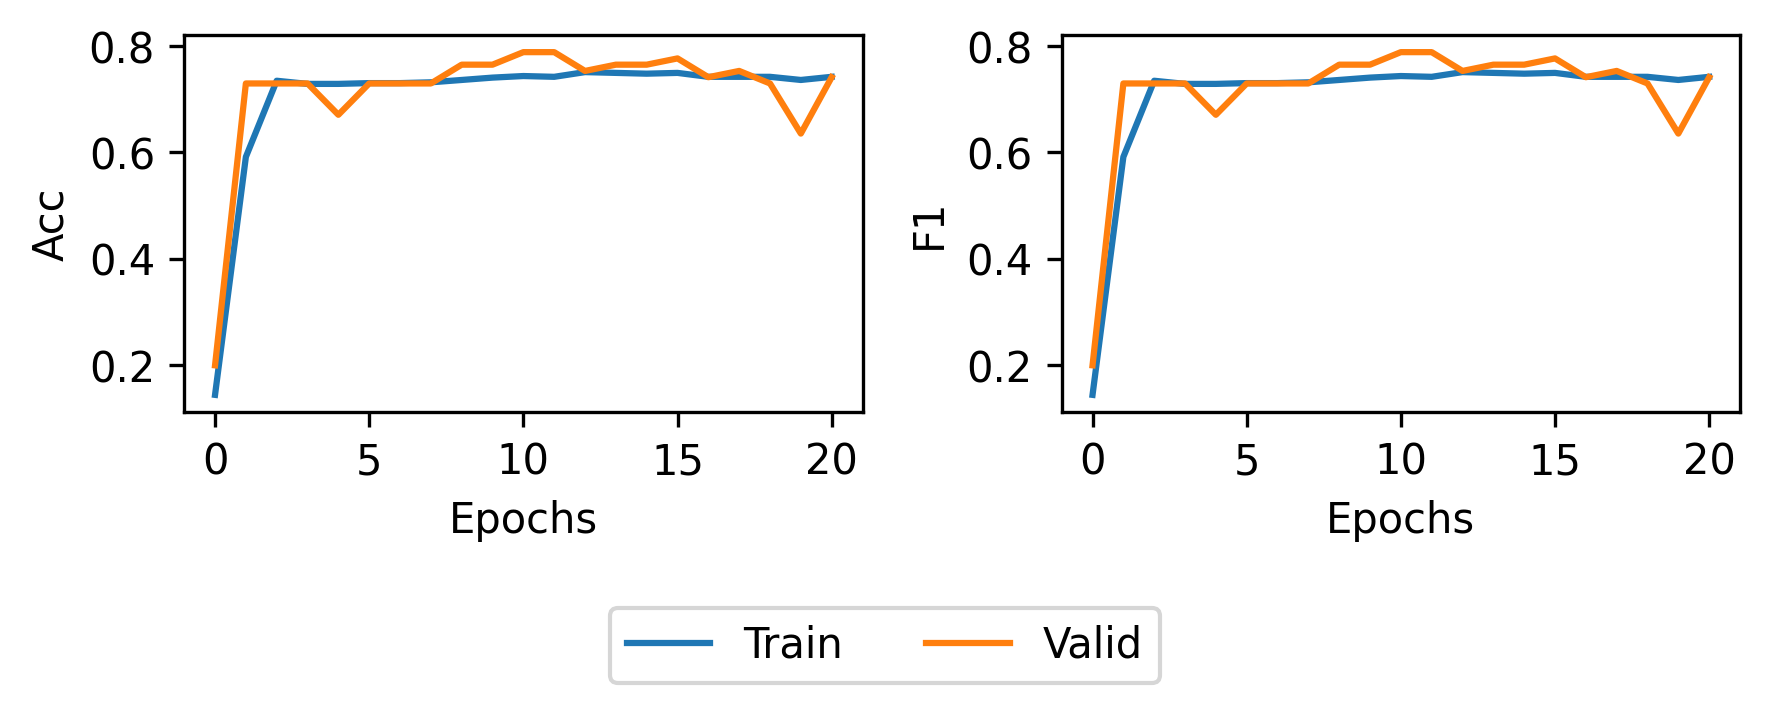

Current Param: {'cat_emb_dim': 4, 'n_a': 8, 'n_d': 8}, Best Valid Acc: 0.78824, Lastest Valid Acc: 0.78824:  94%|█████████▍| 17/18 [20:41<00:59, 59.14s/it]

{'cat_emb_dim': 4, 'n_a': 8, 'n_d': 8}


=== Epoch 0, Time Taken: 3.7s, Time Left: 1862.1s ===
- Train: Acc: 0.02360, F1: 0.02360
- Valid: Acc: 0.01176, F1: 0.01176


=== Epoch 1, Time Taken: 3.4s, Time Left: 1701.6s ===
- Train: Acc: 0.51770, F1: 0.51770
- Valid: Acc: 0.74118, F1: 0.74118


=== Epoch 2, Time Taken: 2.9s, Time Left: 1463.3s ===
- Train: Acc: 0.75221, F1: 0.75221
- Valid: Acc: 0.77647, F1: 0.77647


=== Epoch 3, Time Taken: 3.0s, Time Left: 1503.3s ===
- Train: Acc: 0.73746, F1: 0.73746
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 4, Time Taken: 3.2s, Time Left: 1563.8s ===
- Train: Acc: 0.74631, F1: 0.74631
- Valid: Acc: 0.77647, F1: 0.77647


=== Epoch 5, Time Taken: 2.9s, Time Left: 1428.7s ===
- Train: Acc: 0.73746, F1: 0.73746
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 6, Time Taken: 3.1s, Time Left: 1508.1s ===
- Train: Acc: 0.73894, F1: 0.73894
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 7, Time Taken: 3.1s, Time Left: 1507.7s ===
- Train: Acc: 0.75221, F1: 0.75221
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 8, Time Taken: 2.8s, Time Left: 1352.0s ===
- Train: Acc: 0.75811, F1: 0.75811
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 9, Time Taken: 2.8s, Time Left: 1372.2s ===
- Train: Acc: 0.75811, F1: 0.75811
- Valid: Acc: 0.77647, F1: 0.77647


=== Epoch 10, Time Taken: 2.8s, Time Left: 1392.5s ===
- Train: Acc: 0.75074, F1: 0.75074
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 11, Time Taken: 2.8s, Time Left: 1365.8s ===
- Train: Acc: 0.75221, F1: 0.75221
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 12, Time Taken: 2.7s, Time Left: 1298.8s ===
- Train: Acc: 0.75811, F1: 0.75811
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 13, Time Taken: 3.5s, Time Left: 1684.7s ===
- Train: Acc: 0.75811, F1: 0.75811
- Valid: Acc: 0.78824, F1: 0.78824
Early Stopping at Epoch 13, Best Validation Acc (0.78824) at Epoch 3.


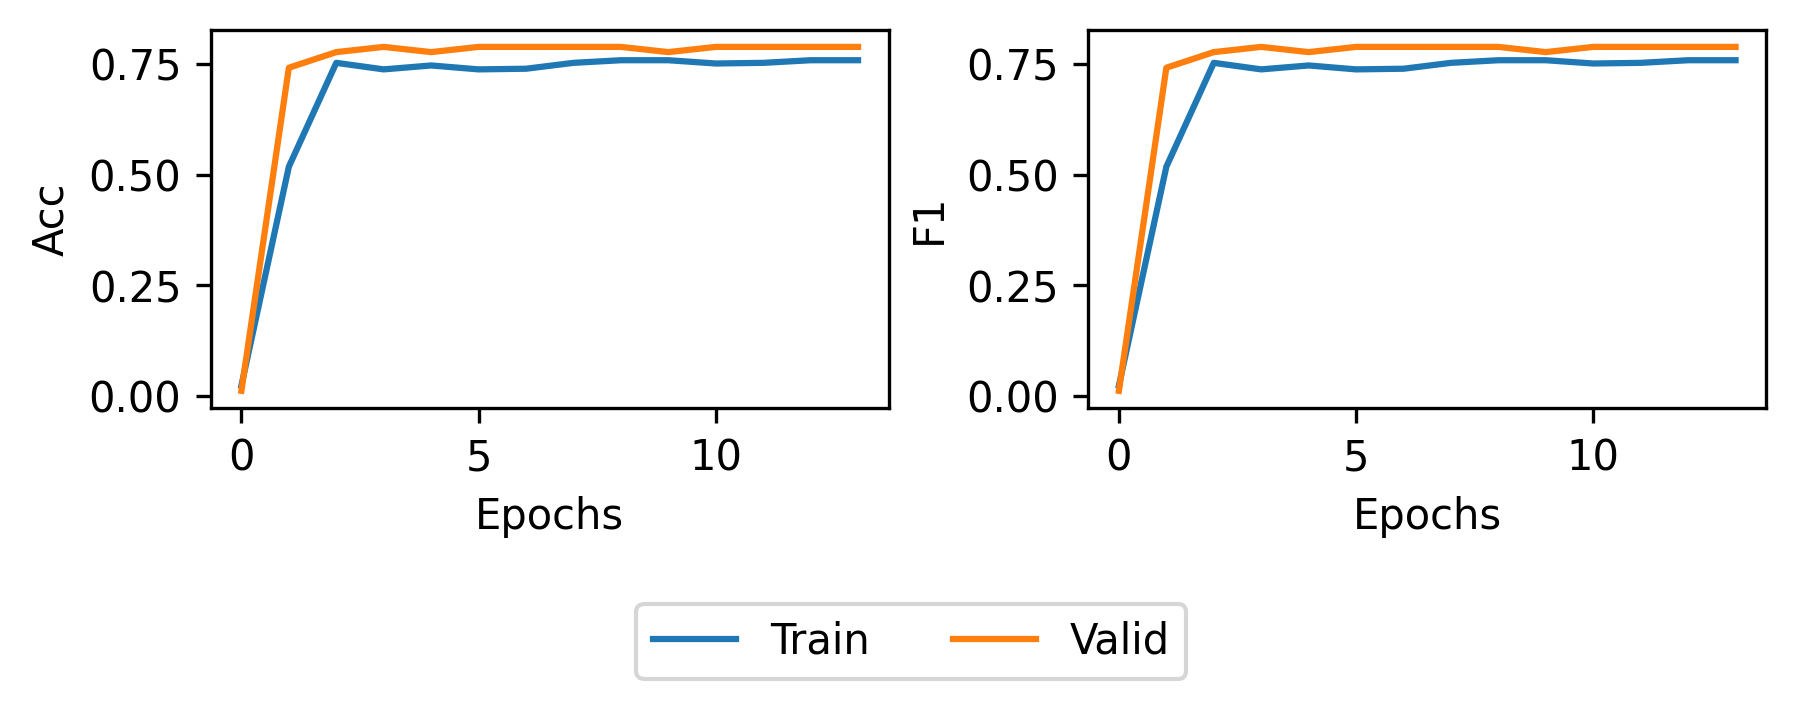

Current Param: {'cat_emb_dim': 4, 'n_a': 8, 'n_d': 8}, Best Valid Acc: 0.78824, Lastest Valid Acc: 0.78824: 100%|██████████| 18/18 [21:24<00:00, 71.35s/it]


In [ ]:
params = dict(
    ModelClass=TabNetBilateralClassifier,
    data_dict=data_dfs_ordinal, col_info=col_info_ordinal,
    batch_size=batch_size,
    eval_batch_size=batch_size,
    train_model_func=train_mlp_bilateral,
    metric_to_monitor="acc",
    maximise=True,
    train_param_dict = dict(max_epochs=500, lr=0.01, weight_decay=0.005, patience=10),
    seed=seed_no,
    fp_model = join(fp_tabnet_bilateral_model_checkpoint, "model.pt"),
    fp_history = join(fp_tabnet_bilateral_model_checkpoint, "history.jpg"),
)
tuning_df, best_param = tune_model(
    param_grid={
        "n_d":[2, 4, 8], 
        "n_a":[2, 4, 8], 
        "cat_emb_dim":[2, 4], 
    }, **params
)

In [6]:
display(tuning_df)
print(best_param)

,cat_emb_dim,n_a,n_d,Epochs,Train Acc,Train F1,Valid Acc,Valid F1,Time/s,best_hyperparameter
0,2,2,2,17,0.635693,0.635693,0.729412,0.729412,77.771228,False
1,2,2,4,10,0.734513,0.734513,0.788235,0.788235,63.385620,True
2,2,2,8,20,0.756637,0.756637,0.788235,0.788235,143.601682,False
3,2,4,2,5,0.610619,0.610619,0.658824,0.658824,48.498613,False
4,2,4,4,1,0.489676,0.489676,0.729412,0.729412,62.121934,False
5,2,4,8,4,0.724189,0.724189,0.729412,0.729412,115.046284,False
6,2,8,2,0,0.001475,0.001475,0.000000,0.000000,87.110792,False
7,2,8,4,10,0.743363,0.743363,0.788235,0.788235,77.497234,False
8,2,8,8,3,0.737463,0.737463,0.788235,0.788235,46.762759,False
9,4,2,2,17,0.635693,0.635693,0.729412,0.729412,94.182413,False


{'cat_emb_dim': 2, 'n_a': 2, 'n_d': 4}


#### Training

=== Epoch 0, Time Taken: 3.2s, Time Left: 1593.7s ===
- Train: Acc: 0.06785, F1: 0.06785
- Valid: Acc: 0.34118, F1: 0.34118


=== Epoch 1, Time Taken: 3.3s, Time Left: 1619.0s ===
- Train: Acc: 0.40265, F1: 0.40265
- Valid: Acc: 0.37647, F1: 0.37647


=== Epoch 2, Time Taken: 3.3s, Time Left: 1636.7s ===
- Train: Acc: 0.47345, F1: 0.47345
- Valid: Acc: 0.48235, F1: 0.48235


=== Epoch 3, Time Taken: 3.0s, Time Left: 1496.3s ===
- Train: Acc: 0.53687, F1: 0.53687
- Valid: Acc: 0.62353, F1: 0.62353


=== Epoch 4, Time Taken: 3.7s, Time Left: 1806.9s ===
- Train: Acc: 0.65044, F1: 0.65044
- Valid: Acc: 0.51765, F1: 0.51765


=== Epoch 5, Time Taken: 2.9s, Time Left: 1432.7s ===
- Train: Acc: 0.62684, F1: 0.62684
- Valid: Acc: 0.61176, F1: 0.61176


=== Epoch 6, Time Taken: 3.1s, Time Left: 1508.5s ===
- Train: Acc: 0.65782, F1: 0.65782
- Valid: Acc: 0.60000, F1: 0.60000


=== Epoch 7, Time Taken: 3.1s, Time Left: 1534.6s ===
- Train: Acc: 0.65192, F1: 0.65192
- Valid: Acc: 0.60000, F1: 0.60000


=== Epoch 8, Time Taken: 3.3s, Time Left: 1627.9s ===
- Train: Acc: 0.66519, F1: 0.66519
- Valid: Acc: 0.60000, F1: 0.60000


=== Epoch 9, Time Taken: 3.2s, Time Left: 1592.1s ===
- Train: Acc: 0.67699, F1: 0.67699
- Valid: Acc: 0.76471, F1: 0.76471


=== Epoch 10, Time Taken: 3.3s, Time Left: 1622.2s ===
- Train: Acc: 0.73451, F1: 0.73451
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 11, Time Taken: 3.1s, Time Left: 1494.7s ===
- Train: Acc: 0.75221, F1: 0.75221
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 12, Time Taken: 3.7s, Time Left: 1781.0s ===
- Train: Acc: 0.74926, F1: 0.74926
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 13, Time Taken: 3.6s, Time Left: 1747.1s ===
- Train: Acc: 0.75516, F1: 0.75516
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 14, Time Taken: 3.3s, Time Left: 1617.9s ===
- Train: Acc: 0.75074, F1: 0.75074
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 15, Time Taken: 3.1s, Time Left: 1491.2s ===
- Train: Acc: 0.75221, F1: 0.75221
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 16, Time Taken: 3.0s, Time Left: 1461.7s ===
- Train: Acc: 0.74926, F1: 0.74926
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 17, Time Taken: 2.8s, Time Left: 1336.3s ===
- Train: Acc: 0.75516, F1: 0.75516
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 18, Time Taken: 3.0s, Time Left: 1439.4s ===
- Train: Acc: 0.75664, F1: 0.75664
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 19, Time Taken: 3.1s, Time Left: 1484.1s ===
- Train: Acc: 0.75369, F1: 0.75369
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 20, Time Taken: 3.3s, Time Left: 1604.6s ===
- Train: Acc: 0.75664, F1: 0.75664
- Valid: Acc: 0.77647, F1: 0.77647
Early Stopping at Epoch 20, Best Validation Acc (0.78824) at Epoch 10.


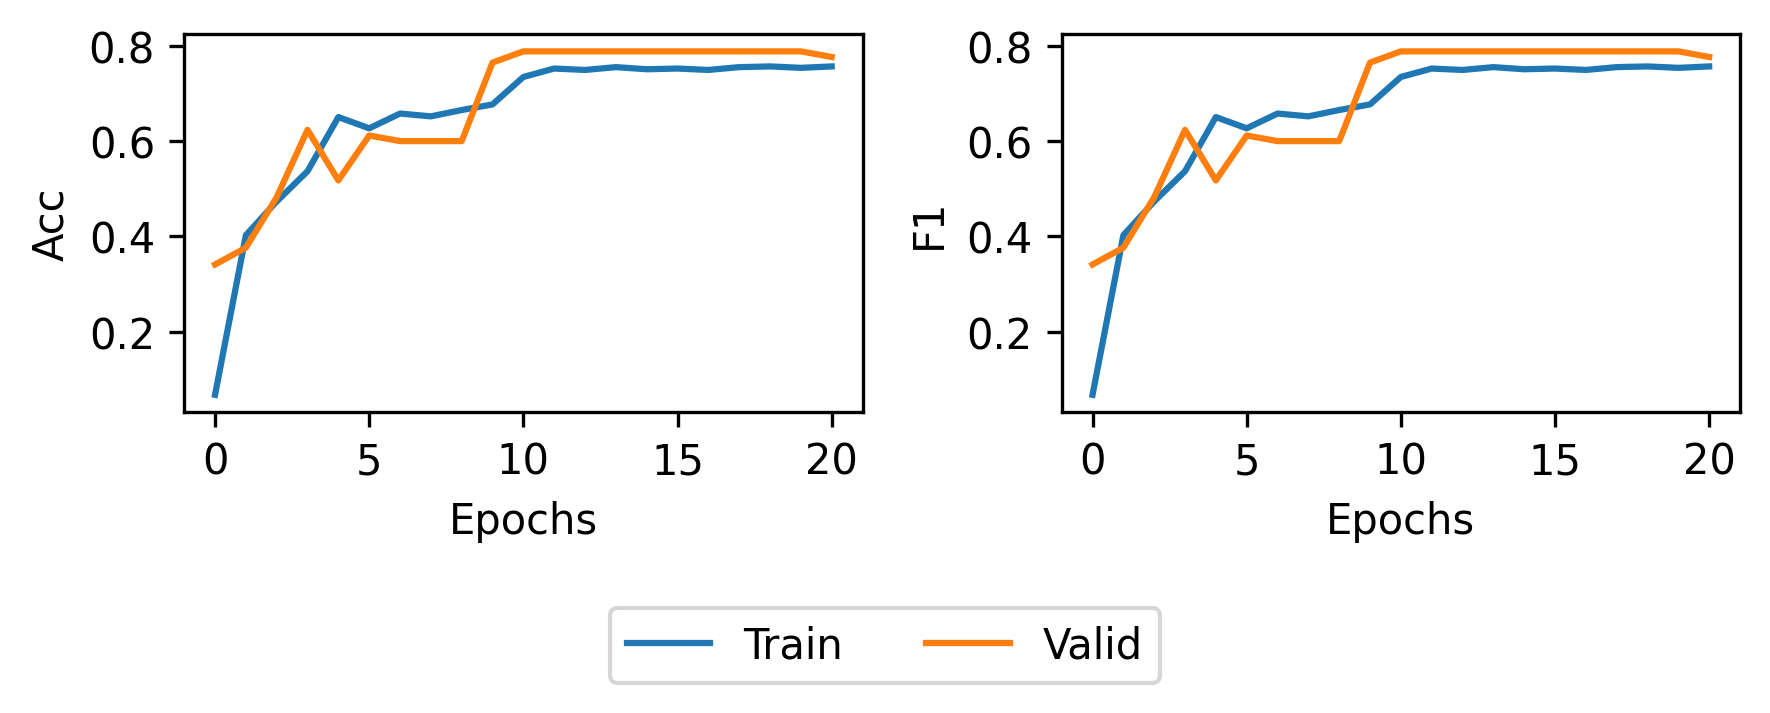

In [7]:
tabnet_bilateral = train_model_w_best_param(
    **params, best_param=best_param,  
)

In [8]:
tabnet_bilateral = torch.load(join(fp_tabnet_bilateral_model_checkpoint, "model.pt"), weights_only=False)

In [ ]:
pred_df, perf_df = evaluate_baseline_bilteral_models(
    data_dfs=data_dfs_ordinal, col_info=col_info_ordinal, model=tabnet_bilateral, 
    batch_size=batch_size, eval_batch_size=batch_size*4, seed=seed_no
)
perf_df

,train,valid,test
Accuracy,0.754,0.788,0.788
Accuracy Total_Time >= 1.0,0.000,0.000,NaN
Accuracy Total_Time >= 13.0,0.009,0.000,0.167
Accuracy Total_Time >= 26.0,0.962,1.000,1.000
Accuracy Total_Time >= 4.33,0.000,0.000,0.000
Accuracy Total_Time >= 52.0,1.000,1.000,1.000
Total_Time >= 1.0 Proportion,0.004,0.002,0.000
Total_Time >= 13.0 Proportion,0.131,0.013,0.014
Total_Time >= 26.0 Proportion,0.215,0.033,0.032
Total_Time >= 4.33 Proportion,0.055,0.006,0.009


### MLP

In [11]:
params = dict(
    ModelClass=MLPBilateralClassifier,
    data_dict=data_dfs_ordinal, col_info=col_info_ordinal,
    batch_size=batch_size,
    eval_batch_size=batch_size,
    train_model_func=train_mlp_bilateral,
    metric_to_monitor="acc",
    maximise=True,
    train_param_dict = dict(max_epochs=500, lr=0.01, weight_decay=0.005, patience=10),
    seed=seed_no,
    fp_model = join(fp_mlp_bilateral_model_checkpoint, "model.pt"),
    fp_history = join(fp_mlp_bilateral_model_checkpoint, "history.jpg"),
)

#### Tuning

Current Param: {'intermediate_width': 32, 'num_hidden_layers': 2}:   0%|          | 0/9 [00:00<?, ?it/s]

{'intermediate_width': 32, 'num_hidden_layers': 2}


=== Epoch 0, Time Taken: 1.1s, Time Left: 555.2s ===
- Train: Acc: 0.42330, F1: 0.42330
- Valid: Acc: 0.72941, F1: 0.72941


=== Epoch 1, Time Taken: 1.1s, Time Left: 557.5s ===
- Train: Acc: 0.71239, F1: 0.71239
- Valid: Acc: 0.72941, F1: 0.72941


=== Epoch 2, Time Taken: 1.1s, Time Left: 529.0s ===
- Train: Acc: 0.73746, F1: 0.73746
- Valid: Acc: 0.72941, F1: 0.72941


=== Epoch 3, Time Taken: 1.2s, Time Left: 571.0s ===
- Train: Acc: 0.73156, F1: 0.73156
- Valid: Acc: 0.76471, F1: 0.76471


=== Epoch 4, Time Taken: 1.3s, Time Left: 636.0s ===
- Train: Acc: 0.74336, F1: 0.74336
- Valid: Acc: 0.67059, F1: 0.67059


=== Epoch 5, Time Taken: 1.1s, Time Left: 562.6s ===
- Train: Acc: 0.77286, F1: 0.77286
- Valid: Acc: 0.72941, F1: 0.72941


=== Epoch 6, Time Taken: 1.2s, Time Left: 589.8s ===
- Train: Acc: 0.76549, F1: 0.76549
- Valid: Acc: 0.76471, F1: 0.76471


=== Epoch 7, Time Taken: 1.2s, Time Left: 579.0s ===
- Train: Acc: 0.79351, F1: 0.79351
- Valid: Acc: 0.80000, F1: 0.80000


=== Epoch 8, Time Taken: 1.1s, Time Left: 526.5s ===
- Train: Acc: 0.80088, F1: 0.80088
- Valid: Acc: 0.75294, F1: 0.75294


=== Epoch 9, Time Taken: 1.1s, Time Left: 534.2s ===
- Train: Acc: 0.79794, F1: 0.79794
- Valid: Acc: 0.81176, F1: 0.81176


=== Epoch 10, Time Taken: 1.1s, Time Left: 521.2s ===
- Train: Acc: 0.80236, F1: 0.80236
- Valid: Acc: 0.82353, F1: 0.82353


=== Epoch 11, Time Taken: 1.3s, Time Left: 632.5s ===
- Train: Acc: 0.80973, F1: 0.80973
- Valid: Acc: 0.81176, F1: 0.81176


=== Epoch 12, Time Taken: 1.2s, Time Left: 579.9s ===
- Train: Acc: 0.79646, F1: 0.79646
- Valid: Acc: 0.67059, F1: 0.67059


=== Epoch 13, Time Taken: 1.2s, Time Left: 567.7s ===
- Train: Acc: 0.78171, F1: 0.78171
- Valid: Acc: 0.63529, F1: 0.63529


=== Epoch 14, Time Taken: 1.1s, Time Left: 539.6s ===
- Train: Acc: 0.79056, F1: 0.79056
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 15, Time Taken: 1.1s, Time Left: 523.7s ===
- Train: Acc: 0.81268, F1: 0.81268
- Valid: Acc: 0.76471, F1: 0.76471


=== Epoch 16, Time Taken: 1.1s, Time Left: 542.5s ===
- Train: Acc: 0.80678, F1: 0.80678
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 17, Time Taken: 1.2s, Time Left: 558.5s ===
- Train: Acc: 0.80531, F1: 0.80531
- Valid: Acc: 0.71765, F1: 0.71765


=== Epoch 18, Time Taken: 1.1s, Time Left: 545.7s ===
- Train: Acc: 0.80826, F1: 0.80826
- Valid: Acc: 0.81176, F1: 0.81176


=== Epoch 19, Time Taken: 1.2s, Time Left: 552.5s ===
- Train: Acc: 0.80973, F1: 0.80973
- Valid: Acc: 0.81176, F1: 0.81176


=== Epoch 20, Time Taken: 1.2s, Time Left: 553.4s ===
- Train: Acc: 0.79351, F1: 0.79351
- Valid: Acc: 0.75294, F1: 0.75294
Early Stopping at Epoch 20, Best Validation Acc (0.82353) at Epoch 10.


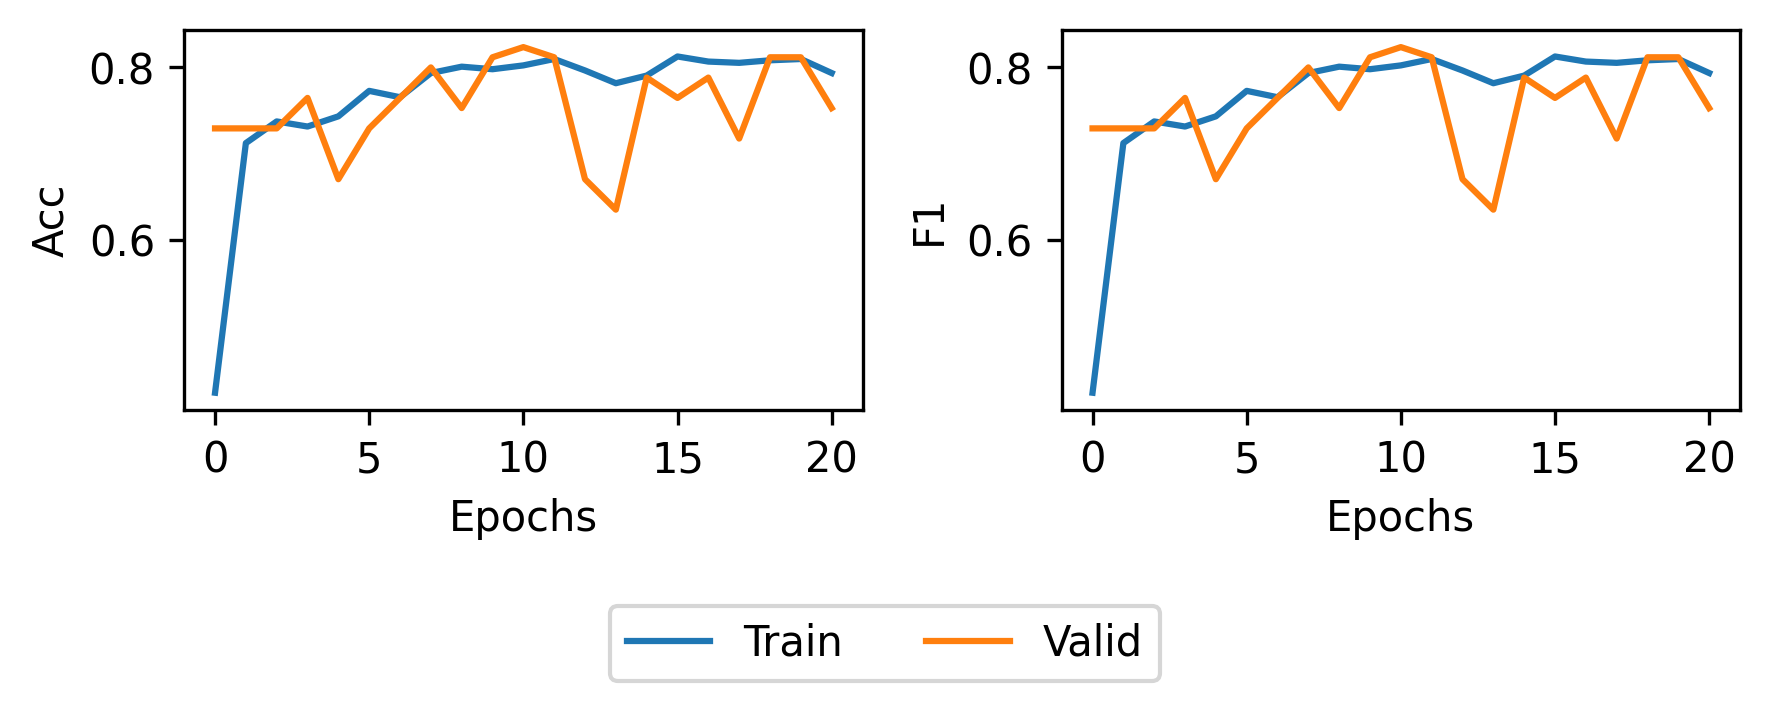

Current Param: {'intermediate_width': 32, 'num_hidden_layers': 3}, Best Valid Acc: 0.82353, Lastest Valid Acc: 0.82353:  11%|█         | 1/9 [00:24<03:16, 24.51s/it]

{'intermediate_width': 32, 'num_hidden_layers': 3}


=== Epoch 0, Time Taken: 1.3s, Time Left: 625.5s ===
- Train: Acc: 0.29794, F1: 0.29794
- Valid: Acc: 0.50588, F1: 0.50588


=== Epoch 1, Time Taken: 1.2s, Time Left: 615.5s ===
- Train: Acc: 0.64159, F1: 0.64159
- Valid: Acc: 0.72941, F1: 0.72941


=== Epoch 2, Time Taken: 1.2s, Time Left: 577.6s ===
- Train: Acc: 0.72566, F1: 0.72566
- Valid: Acc: 0.72941, F1: 0.72941


=== Epoch 3, Time Taken: 1.1s, Time Left: 525.9s ===
- Train: Acc: 0.71829, F1: 0.71829
- Valid: Acc: 0.71765, F1: 0.71765


=== Epoch 4, Time Taken: 1.1s, Time Left: 535.9s ===
- Train: Acc: 0.72861, F1: 0.72861
- Valid: Acc: 0.64706, F1: 0.64706


=== Epoch 5, Time Taken: 1.1s, Time Left: 560.5s ===
- Train: Acc: 0.73009, F1: 0.73009
- Valid: Acc: 0.75294, F1: 0.75294


=== Epoch 6, Time Taken: 1.1s, Time Left: 543.2s ===
- Train: Acc: 0.74779, F1: 0.74779
- Valid: Acc: 0.76471, F1: 0.76471


=== Epoch 7, Time Taken: 1.2s, Time Left: 595.9s ===
- Train: Acc: 0.73894, F1: 0.73894
- Valid: Acc: 0.72941, F1: 0.72941


=== Epoch 8, Time Taken: 1.2s, Time Left: 566.9s ===
- Train: Acc: 0.76254, F1: 0.76254
- Valid: Acc: 0.74118, F1: 0.74118


=== Epoch 9, Time Taken: 1.2s, Time Left: 611.5s ===
- Train: Acc: 0.76549, F1: 0.76549
- Valid: Acc: 0.77647, F1: 0.77647


=== Epoch 10, Time Taken: 1.3s, Time Left: 617.2s ===
- Train: Acc: 0.79056, F1: 0.79056
- Valid: Acc: 0.80000, F1: 0.80000


=== Epoch 11, Time Taken: 1.2s, Time Left: 563.4s ===
- Train: Acc: 0.78466, F1: 0.78466
- Valid: Acc: 0.80000, F1: 0.80000


=== Epoch 12, Time Taken: 1.2s, Time Left: 601.1s ===
- Train: Acc: 0.80531, F1: 0.80531
- Valid: Acc: 0.82353, F1: 0.82353


=== Epoch 13, Time Taken: 1.1s, Time Left: 547.0s ===
- Train: Acc: 0.81563, F1: 0.81563
- Valid: Acc: 0.83529, F1: 0.83529


=== Epoch 14, Time Taken: 1.3s, Time Left: 628.1s ===
- Train: Acc: 0.81711, F1: 0.81711
- Valid: Acc: 0.71765, F1: 0.71765


=== Epoch 15, Time Taken: 1.1s, Time Left: 549.4s ===
- Train: Acc: 0.80678, F1: 0.80678
- Valid: Acc: 0.83529, F1: 0.83529


=== Epoch 16, Time Taken: 1.2s, Time Left: 581.0s ===
- Train: Acc: 0.81711, F1: 0.81711
- Valid: Acc: 0.82353, F1: 0.82353


=== Epoch 17, Time Taken: 1.3s, Time Left: 602.6s ===
- Train: Acc: 0.80826, F1: 0.80826
- Valid: Acc: 0.75294, F1: 0.75294


=== Epoch 18, Time Taken: 1.4s, Time Left: 674.5s ===
- Train: Acc: 0.80826, F1: 0.80826
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 19, Time Taken: 1.1s, Time Left: 547.0s ===
- Train: Acc: 0.80236, F1: 0.80236
- Valid: Acc: 0.81176, F1: 0.81176


=== Epoch 20, Time Taken: 1.2s, Time Left: 590.1s ===
- Train: Acc: 0.80236, F1: 0.80236
- Valid: Acc: 0.81176, F1: 0.81176


=== Epoch 21, Time Taken: 1.2s, Time Left: 583.4s ===
- Train: Acc: 0.79794, F1: 0.79794
- Valid: Acc: 0.82353, F1: 0.82353


=== Epoch 22, Time Taken: 1.1s, Time Left: 506.9s ===
- Train: Acc: 0.81416, F1: 0.81416
- Valid: Acc: 0.82353, F1: 0.82353


=== Epoch 23, Time Taken: 1.2s, Time Left: 565.5s ===
- Train: Acc: 0.81268, F1: 0.81268
- Valid: Acc: 0.82353, F1: 0.82353
Early Stopping at Epoch 23, Best Validation Acc (0.83529) at Epoch 13.


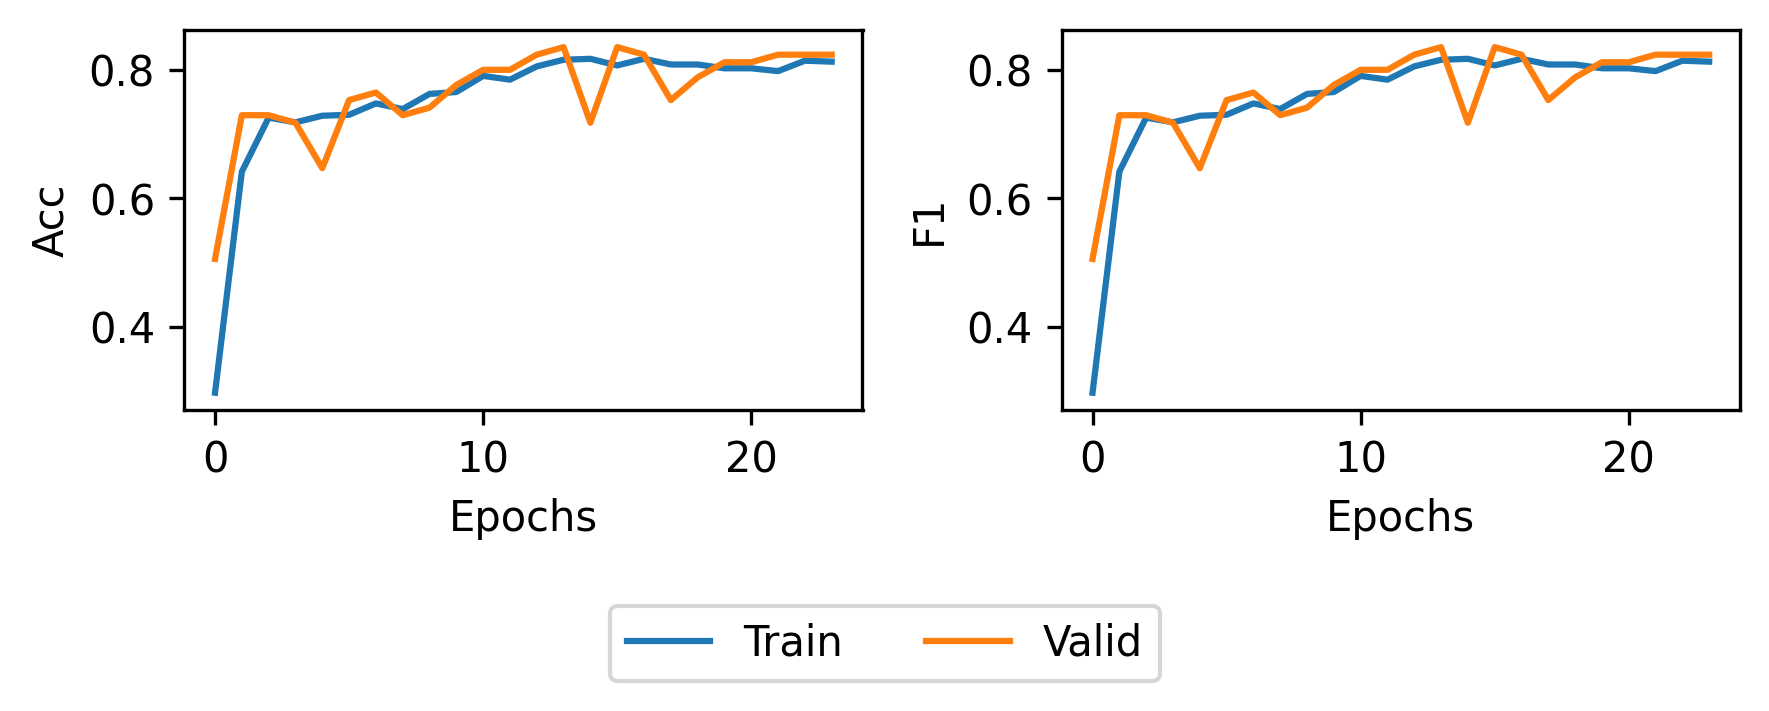

Current Param: {'intermediate_width': 32, 'num_hidden_layers': 4}, Best Valid Acc: 0.83529, Lastest Valid Acc: 0.83529:  22%|██▏       | 2/9 [00:53<03:10, 27.14s/it]

{'intermediate_width': 32, 'num_hidden_layers': 4}


=== Epoch 0, Time Taken: 1.2s, Time Left: 576.5s ===
- Train: Acc: 0.31711, F1: 0.31711
- Valid: Acc: 0.65882, F1: 0.65882


=== Epoch 1, Time Taken: 1.2s, Time Left: 594.2s ===
- Train: Acc: 0.63864, F1: 0.63864
- Valid: Acc: 0.68235, F1: 0.68235


=== Epoch 2, Time Taken: 1.3s, Time Left: 630.0s ===
- Train: Acc: 0.68142, F1: 0.68142
- Valid: Acc: 0.64706, F1: 0.64706


=== Epoch 3, Time Taken: 1.3s, Time Left: 641.8s ===
- Train: Acc: 0.70059, F1: 0.70059
- Valid: Acc: 0.71765, F1: 0.71765


=== Epoch 4, Time Taken: 1.2s, Time Left: 591.3s ===
- Train: Acc: 0.72714, F1: 0.72714
- Valid: Acc: 0.72941, F1: 0.72941


=== Epoch 5, Time Taken: 1.2s, Time Left: 575.7s ===
- Train: Acc: 0.74484, F1: 0.74484
- Valid: Acc: 0.74118, F1: 0.74118


=== Epoch 6, Time Taken: 1.1s, Time Left: 560.3s ===
- Train: Acc: 0.74041, F1: 0.74041
- Valid: Acc: 0.74118, F1: 0.74118


=== Epoch 7, Time Taken: 1.1s, Time Left: 563.9s ===
- Train: Acc: 0.73746, F1: 0.73746
- Valid: Acc: 0.69412, F1: 0.69412


=== Epoch 8, Time Taken: 1.2s, Time Left: 578.4s ===
- Train: Acc: 0.75664, F1: 0.75664
- Valid: Acc: 0.71765, F1: 0.71765


=== Epoch 9, Time Taken: 1.1s, Time Left: 532.8s ===
- Train: Acc: 0.74926, F1: 0.74926
- Valid: Acc: 0.77647, F1: 0.77647


=== Epoch 10, Time Taken: 1.1s, Time Left: 513.5s ===
- Train: Acc: 0.78761, F1: 0.78761
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 11, Time Taken: 1.2s, Time Left: 566.8s ===
- Train: Acc: 0.80678, F1: 0.80678
- Valid: Acc: 0.69412, F1: 0.69412


=== Epoch 12, Time Taken: 1.1s, Time Left: 541.6s ===
- Train: Acc: 0.80236, F1: 0.80236
- Valid: Acc: 0.82353, F1: 0.82353


=== Epoch 13, Time Taken: 1.1s, Time Left: 545.7s ===
- Train: Acc: 0.78761, F1: 0.78761
- Valid: Acc: 0.77647, F1: 0.77647


=== Epoch 14, Time Taken: 1.1s, Time Left: 542.7s ===
- Train: Acc: 0.80383, F1: 0.80383
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 15, Time Taken: 1.1s, Time Left: 516.8s ===
- Train: Acc: 0.80383, F1: 0.80383
- Valid: Acc: 0.75294, F1: 0.75294


=== Epoch 16, Time Taken: 1.1s, Time Left: 545.0s ===
- Train: Acc: 0.81858, F1: 0.81858
- Valid: Acc: 0.82353, F1: 0.82353


=== Epoch 17, Time Taken: 1.2s, Time Left: 570.1s ===
- Train: Acc: 0.82743, F1: 0.82743
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 18, Time Taken: 1.1s, Time Left: 546.2s ===
- Train: Acc: 0.81563, F1: 0.81563
- Valid: Acc: 0.82353, F1: 0.82353


=== Epoch 19, Time Taken: 1.1s, Time Left: 504.7s ===
- Train: Acc: 0.79646, F1: 0.79646
- Valid: Acc: 0.80000, F1: 0.80000


=== Epoch 20, Time Taken: 1.1s, Time Left: 529.9s ===
- Train: Acc: 0.82006, F1: 0.82006
- Valid: Acc: 0.69412, F1: 0.69412


=== Epoch 21, Time Taken: 1.1s, Time Left: 535.9s ===
- Train: Acc: 0.81416, F1: 0.81416
- Valid: Acc: 0.82353, F1: 0.82353


=== Epoch 22, Time Taken: 1.1s, Time Left: 512.3s ===
- Train: Acc: 0.81858, F1: 0.81858
- Valid: Acc: 0.78824, F1: 0.78824
Early Stopping at Epoch 22, Best Validation Acc (0.82353) at Epoch 12.


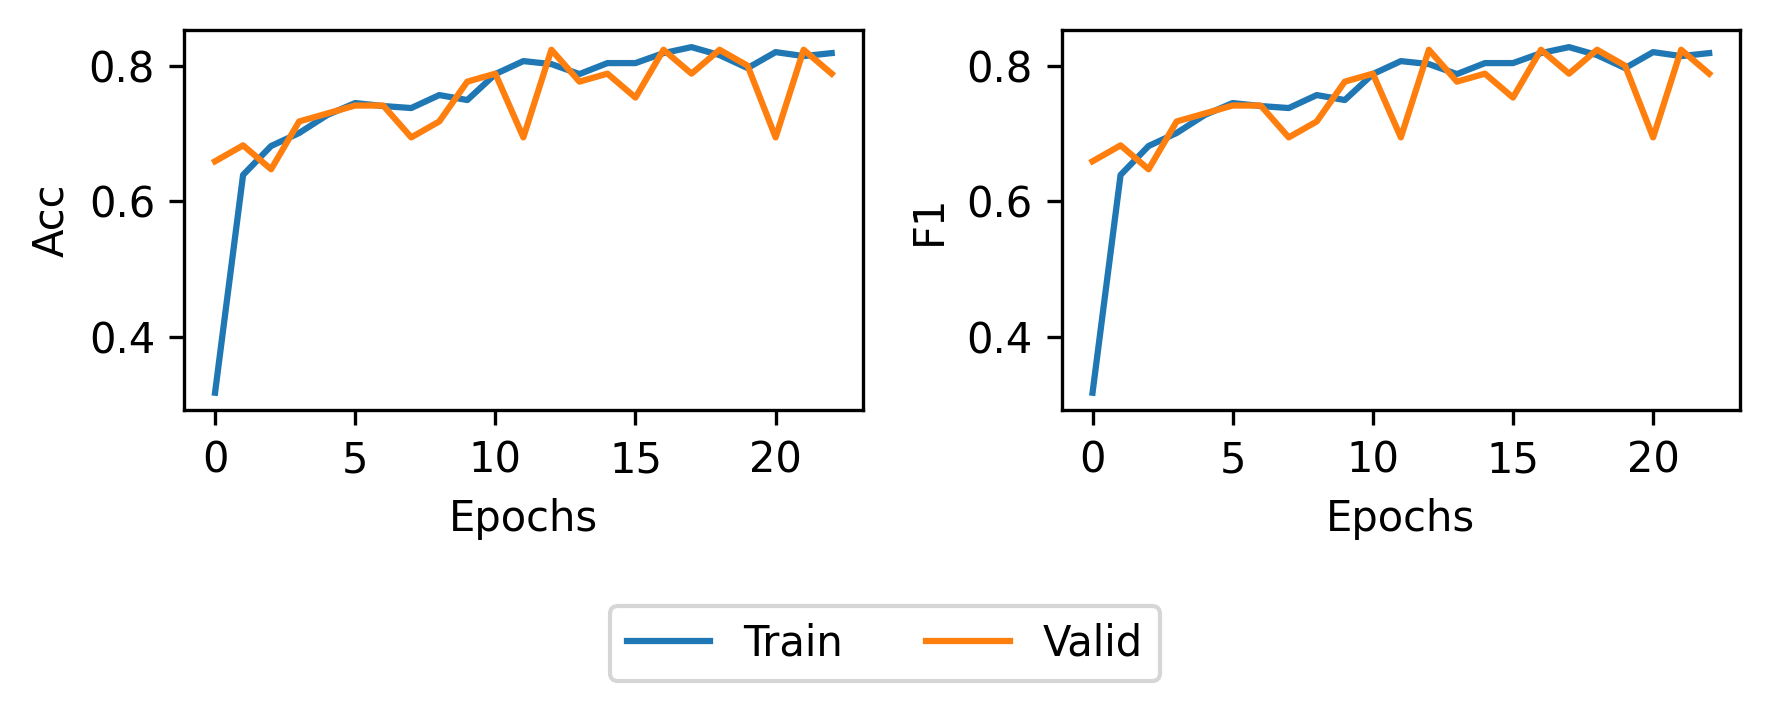

Current Param: {'intermediate_width': 64, 'num_hidden_layers': 2}, Best Valid Acc: 0.83529, Lastest Valid Acc: 0.82353:  33%|███▎      | 3/9 [01:20<02:41, 26.94s/it]

{'intermediate_width': 64, 'num_hidden_layers': 2}


=== Epoch 0, Time Taken: 1.1s, Time Left: 534.1s ===
- Train: Acc: 0.42478, F1: 0.42478
- Valid: Acc: 0.62353, F1: 0.62353


=== Epoch 1, Time Taken: 1.4s, Time Left: 672.4s ===
- Train: Acc: 0.72271, F1: 0.72271
- Valid: Acc: 0.75294, F1: 0.75294


=== Epoch 2, Time Taken: 1.1s, Time Left: 558.8s ===
- Train: Acc: 0.72714, F1: 0.72714
- Valid: Acc: 0.57647, F1: 0.57647


=== Epoch 3, Time Taken: 1.2s, Time Left: 602.1s ===
- Train: Acc: 0.71091, F1: 0.71091
- Valid: Acc: 0.76471, F1: 0.76471


=== Epoch 4, Time Taken: 1.1s, Time Left: 548.1s ===
- Train: Acc: 0.73746, F1: 0.73746
- Valid: Acc: 0.74118, F1: 0.74118


=== Epoch 5, Time Taken: 1.3s, Time Left: 623.9s ===
- Train: Acc: 0.75369, F1: 0.75369
- Valid: Acc: 0.77647, F1: 0.77647


=== Epoch 6, Time Taken: 1.3s, Time Left: 629.7s ===
- Train: Acc: 0.77139, F1: 0.77139
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 7, Time Taken: 1.2s, Time Left: 574.6s ===
- Train: Acc: 0.77286, F1: 0.77286
- Valid: Acc: 0.77647, F1: 0.77647


=== Epoch 8, Time Taken: 1.1s, Time Left: 549.4s ===
- Train: Acc: 0.75369, F1: 0.75369
- Valid: Acc: 0.76471, F1: 0.76471


=== Epoch 9, Time Taken: 1.2s, Time Left: 564.3s ===
- Train: Acc: 0.79351, F1: 0.79351
- Valid: Acc: 0.63529, F1: 0.63529


=== Epoch 10, Time Taken: 1.1s, Time Left: 528.1s ===
- Train: Acc: 0.77286, F1: 0.77286
- Valid: Acc: 0.57647, F1: 0.57647


=== Epoch 11, Time Taken: 1.1s, Time Left: 556.5s ===
- Train: Acc: 0.77581, F1: 0.77581
- Valid: Acc: 0.81176, F1: 0.81176


=== Epoch 12, Time Taken: 1.2s, Time Left: 602.7s ===
- Train: Acc: 0.78614, F1: 0.78614
- Valid: Acc: 0.82353, F1: 0.82353


=== Epoch 13, Time Taken: 1.1s, Time Left: 538.4s ===
- Train: Acc: 0.78761, F1: 0.78761
- Valid: Acc: 0.76471, F1: 0.76471


=== Epoch 14, Time Taken: 1.2s, Time Left: 569.1s ===
- Train: Acc: 0.79056, F1: 0.79056
- Valid: Acc: 0.81176, F1: 0.81176


=== Epoch 15, Time Taken: 1.2s, Time Left: 580.5s ===
- Train: Acc: 0.81858, F1: 0.81858
- Valid: Acc: 0.81176, F1: 0.81176


=== Epoch 16, Time Taken: 1.1s, Time Left: 547.9s ===
- Train: Acc: 0.80973, F1: 0.80973
- Valid: Acc: 0.70588, F1: 0.70588


=== Epoch 17, Time Taken: 1.1s, Time Left: 544.3s ===
- Train: Acc: 0.80236, F1: 0.80236
- Valid: Acc: 0.68235, F1: 0.68235


=== Epoch 18, Time Taken: 1.4s, Time Left: 663.4s ===
- Train: Acc: 0.79499, F1: 0.79499
- Valid: Acc: 0.82353, F1: 0.82353


=== Epoch 19, Time Taken: 1.3s, Time Left: 608.2s ===
- Train: Acc: 0.80826, F1: 0.80826
- Valid: Acc: 0.83529, F1: 0.83529


=== Epoch 20, Time Taken: 1.3s, Time Left: 614.4s ===
- Train: Acc: 0.81563, F1: 0.81563
- Valid: Acc: 0.77647, F1: 0.77647


=== Epoch 21, Time Taken: 1.2s, Time Left: 573.1s ===
- Train: Acc: 0.81858, F1: 0.81858
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 22, Time Taken: 1.2s, Time Left: 576.6s ===
- Train: Acc: 0.80236, F1: 0.80236
- Valid: Acc: 0.77647, F1: 0.77647


=== Epoch 23, Time Taken: 1.1s, Time Left: 538.8s ===
- Train: Acc: 0.81858, F1: 0.81858
- Valid: Acc: 0.80000, F1: 0.80000


=== Epoch 24, Time Taken: 1.2s, Time Left: 546.9s ===
- Train: Acc: 0.80826, F1: 0.80826
- Valid: Acc: 0.82353, F1: 0.82353


=== Epoch 25, Time Taken: 1.2s, Time Left: 547.4s ===
- Train: Acc: 0.77876, F1: 0.77876
- Valid: Acc: 0.77647, F1: 0.77647


=== Epoch 26, Time Taken: 1.4s, Time Left: 673.4s ===
- Train: Acc: 0.80531, F1: 0.80531
- Valid: Acc: 0.83529, F1: 0.83529


=== Epoch 27, Time Taken: 1.1s, Time Left: 535.7s ===
- Train: Acc: 0.79351, F1: 0.79351
- Valid: Acc: 0.72941, F1: 0.72941


=== Epoch 28, Time Taken: 1.1s, Time Left: 525.9s ===
- Train: Acc: 0.82153, F1: 0.82153
- Valid: Acc: 0.80000, F1: 0.80000


=== Epoch 29, Time Taken: 1.2s, Time Left: 544.7s ===
- Train: Acc: 0.81121, F1: 0.81121
- Valid: Acc: 0.82353, F1: 0.82353
Early Stopping at Epoch 29, Best Validation Acc (0.83529) at Epoch 19.


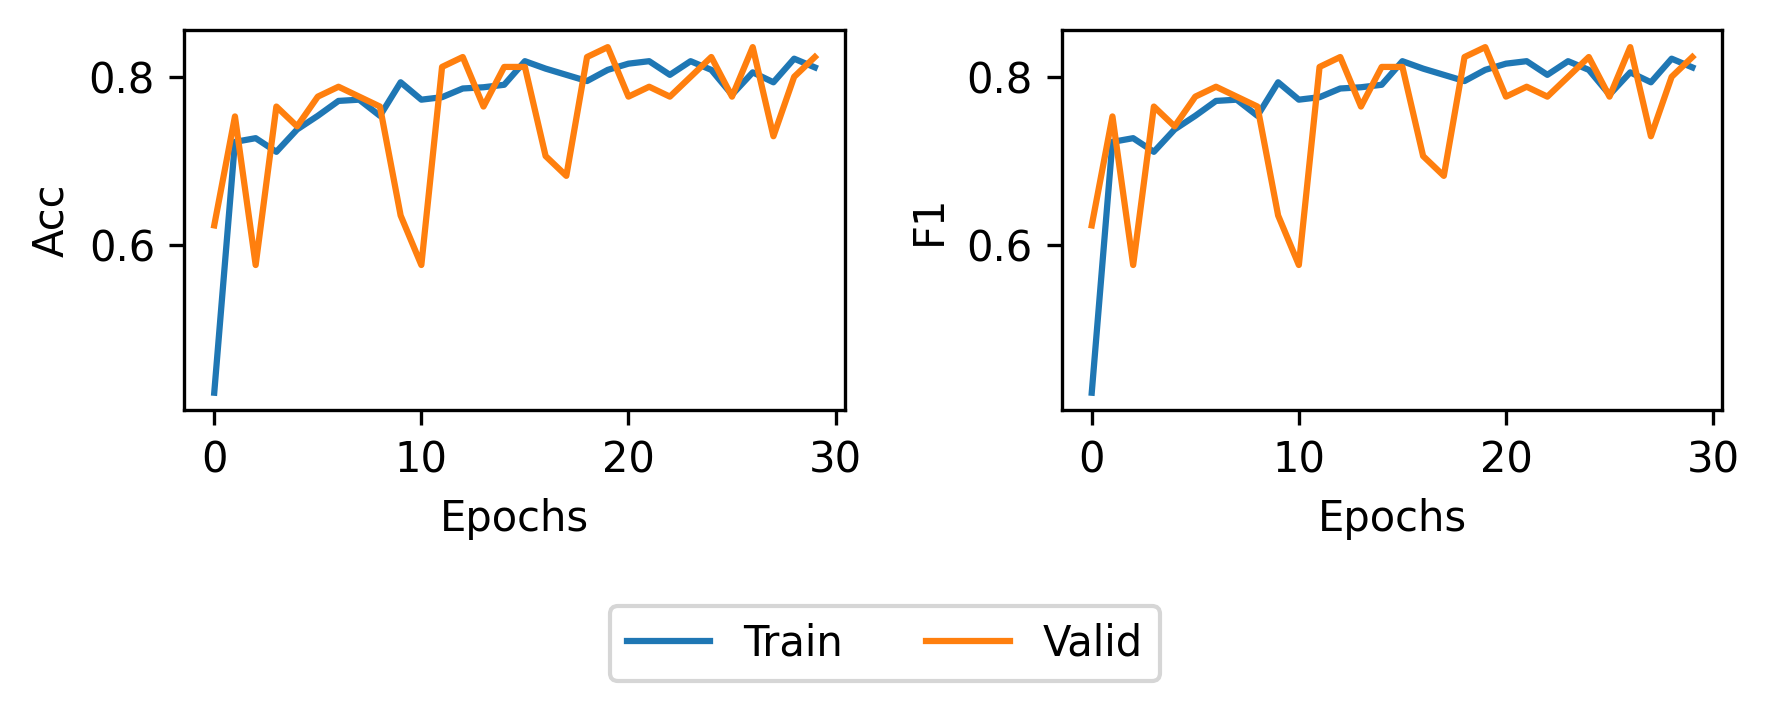

Current Param: {'intermediate_width': 64, 'num_hidden_layers': 3}, Best Valid Acc: 0.83529, Lastest Valid Acc: 0.83529:  44%|████▍     | 4/9 [01:56<02:32, 30.54s/it]

{'intermediate_width': 64, 'num_hidden_layers': 3}


=== Epoch 0, Time Taken: 1.2s, Time Left: 596.5s ===
- Train: Acc: 0.46755, F1: 0.46755
- Valid: Acc: 0.70588, F1: 0.70588


=== Epoch 1, Time Taken: 1.2s, Time Left: 621.7s ===
- Train: Acc: 0.71681, F1: 0.71681
- Valid: Acc: 0.70588, F1: 0.70588


=== Epoch 2, Time Taken: 1.2s, Time Left: 586.7s ===
- Train: Acc: 0.74041, F1: 0.74041
- Valid: Acc: 0.72941, F1: 0.72941


=== Epoch 3, Time Taken: 1.2s, Time Left: 592.3s ===
- Train: Acc: 0.72861, F1: 0.72861
- Valid: Acc: 0.77647, F1: 0.77647


=== Epoch 4, Time Taken: 1.2s, Time Left: 577.9s ===
- Train: Acc: 0.72714, F1: 0.72714
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 5, Time Taken: 1.2s, Time Left: 602.9s ===
- Train: Acc: 0.77434, F1: 0.77434
- Valid: Acc: 0.81176, F1: 0.81176


=== Epoch 6, Time Taken: 1.3s, Time Left: 635.8s ===
- Train: Acc: 0.78466, F1: 0.78466
- Valid: Acc: 0.82353, F1: 0.82353


=== Epoch 7, Time Taken: 1.2s, Time Left: 586.0s ===
- Train: Acc: 0.77581, F1: 0.77581
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 8, Time Taken: 1.2s, Time Left: 609.1s ===
- Train: Acc: 0.77581, F1: 0.77581
- Valid: Acc: 0.80000, F1: 0.80000


=== Epoch 9, Time Taken: 1.1s, Time Left: 547.7s ===
- Train: Acc: 0.78171, F1: 0.78171
- Valid: Acc: 0.81176, F1: 0.81176


=== Epoch 10, Time Taken: 1.1s, Time Left: 549.4s ===
- Train: Acc: 0.80826, F1: 0.80826
- Valid: Acc: 0.84706, F1: 0.84706


=== Epoch 11, Time Taken: 1.2s, Time Left: 609.0s ===
- Train: Acc: 0.81563, F1: 0.81563
- Valid: Acc: 0.82353, F1: 0.82353


=== Epoch 12, Time Taken: 1.2s, Time Left: 589.0s ===
- Train: Acc: 0.77581, F1: 0.77581
- Valid: Acc: 0.77647, F1: 0.77647


=== Epoch 13, Time Taken: 1.2s, Time Left: 592.3s ===
- Train: Acc: 0.81268, F1: 0.81268
- Valid: Acc: 0.83529, F1: 0.83529


=== Epoch 14, Time Taken: 1.3s, Time Left: 607.1s ===
- Train: Acc: 0.79056, F1: 0.79056
- Valid: Acc: 0.80000, F1: 0.80000


=== Epoch 15, Time Taken: 1.3s, Time Left: 619.7s ===
- Train: Acc: 0.80973, F1: 0.80973
- Valid: Acc: 0.82353, F1: 0.82353


=== Epoch 16, Time Taken: 1.3s, Time Left: 621.7s ===
- Train: Acc: 0.82448, F1: 0.82448
- Valid: Acc: 0.81176, F1: 0.81176


=== Epoch 17, Time Taken: 1.2s, Time Left: 568.7s ===
- Train: Acc: 0.82596, F1: 0.82596
- Valid: Acc: 0.82353, F1: 0.82353


=== Epoch 18, Time Taken: 1.3s, Time Left: 630.8s ===
- Train: Acc: 0.80383, F1: 0.80383
- Valid: Acc: 0.81176, F1: 0.81176


=== Epoch 19, Time Taken: 1.1s, Time Left: 547.5s ===
- Train: Acc: 0.80973, F1: 0.80973
- Valid: Acc: 0.82353, F1: 0.82353


=== Epoch 20, Time Taken: 1.1s, Time Left: 550.6s ===
- Train: Acc: 0.81563, F1: 0.81563
- Valid: Acc: 0.81176, F1: 0.81176
Early Stopping at Epoch 20, Best Validation Acc (0.84706) at Epoch 10.


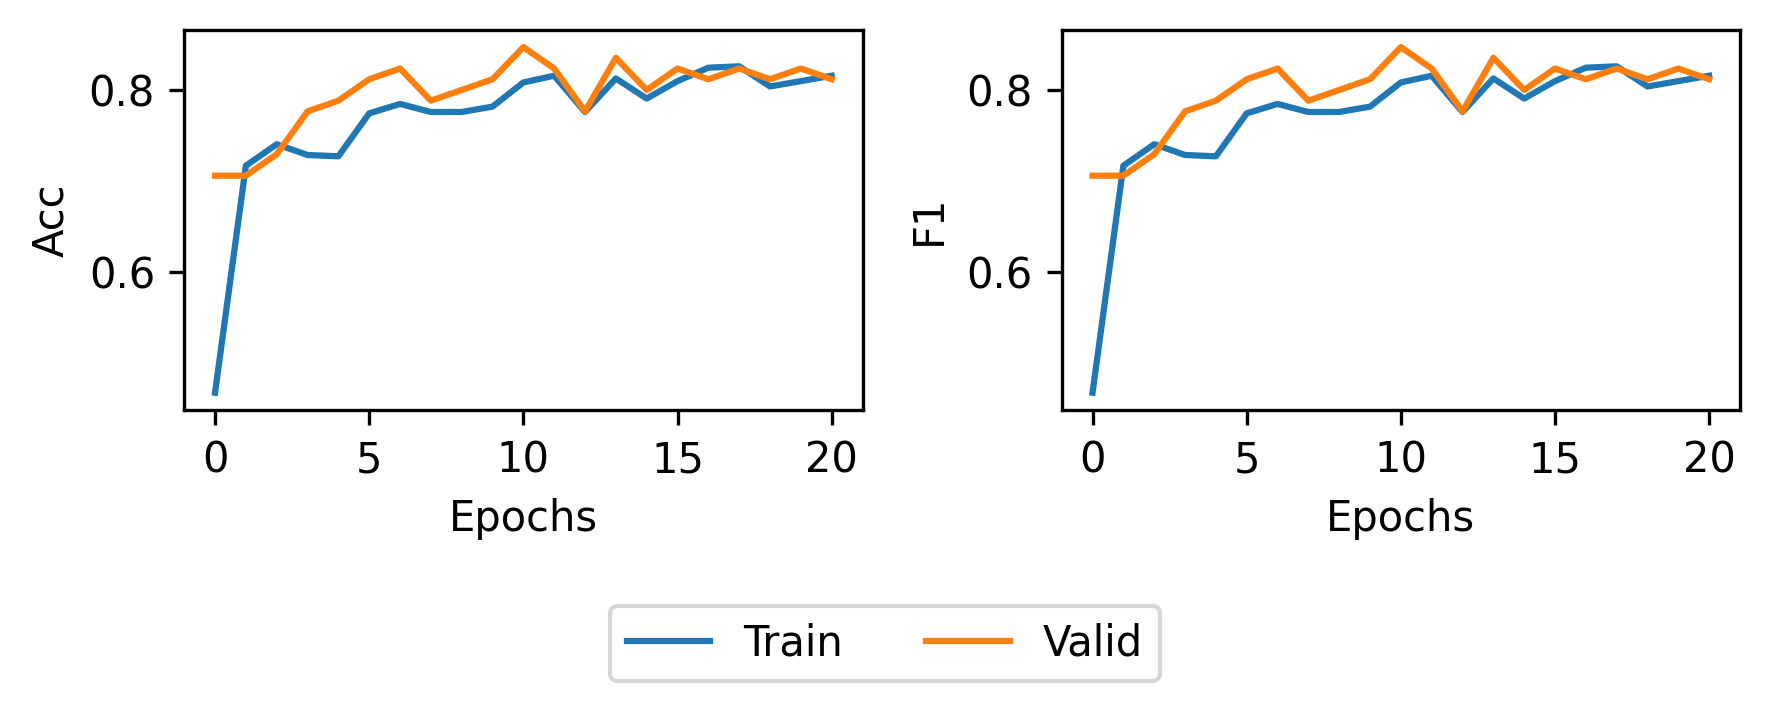

Current Param: {'intermediate_width': 64, 'num_hidden_layers': 4}, Best Valid Acc: 0.84706, Lastest Valid Acc: 0.84706:  56%|█████▌    | 5/9 [02:22<01:55, 28.88s/it]

{'intermediate_width': 64, 'num_hidden_layers': 4}


=== Epoch 0, Time Taken: 1.2s, Time Left: 588.5s ===
- Train: Acc: 0.34513, F1: 0.34513
- Valid: Acc: 0.70588, F1: 0.70588


=== Epoch 1, Time Taken: 1.3s, Time Left: 657.4s ===
- Train: Acc: 0.57965, F1: 0.57965
- Valid: Acc: 0.61176, F1: 0.61176


=== Epoch 2, Time Taken: 1.2s, Time Left: 608.6s ===
- Train: Acc: 0.65634, F1: 0.65634
- Valid: Acc: 0.60000, F1: 0.60000


=== Epoch 3, Time Taken: 1.3s, Time Left: 621.7s ===
- Train: Acc: 0.68142, F1: 0.68142
- Valid: Acc: 0.75294, F1: 0.75294


=== Epoch 4, Time Taken: 1.2s, Time Left: 617.0s ===
- Train: Acc: 0.71386, F1: 0.71386
- Valid: Acc: 0.64706, F1: 0.64706


=== Epoch 5, Time Taken: 1.3s, Time Left: 662.6s ===
- Train: Acc: 0.71681, F1: 0.71681
- Valid: Acc: 0.63529, F1: 0.63529


=== Epoch 6, Time Taken: 1.2s, Time Left: 585.9s ===
- Train: Acc: 0.73156, F1: 0.73156
- Valid: Acc: 0.75294, F1: 0.75294


=== Epoch 7, Time Taken: 1.2s, Time Left: 606.5s ===
- Train: Acc: 0.77876, F1: 0.77876
- Valid: Acc: 0.67059, F1: 0.67059


=== Epoch 8, Time Taken: 1.2s, Time Left: 580.0s ===
- Train: Acc: 0.78466, F1: 0.78466
- Valid: Acc: 0.69412, F1: 0.69412


=== Epoch 9, Time Taken: 1.2s, Time Left: 582.8s ===
- Train: Acc: 0.79499, F1: 0.79499
- Valid: Acc: 0.71765, F1: 0.71765


=== Epoch 10, Time Taken: 1.2s, Time Left: 576.4s ===
- Train: Acc: 0.79499, F1: 0.79499
- Valid: Acc: 0.82353, F1: 0.82353


=== Epoch 11, Time Taken: 1.3s, Time Left: 644.0s ===
- Train: Acc: 0.79499, F1: 0.79499
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 12, Time Taken: 1.3s, Time Left: 616.9s ===
- Train: Acc: 0.78466, F1: 0.78466
- Valid: Acc: 0.72941, F1: 0.72941


=== Epoch 13, Time Taken: 1.3s, Time Left: 615.8s ===
- Train: Acc: 0.82153, F1: 0.82153
- Valid: Acc: 0.76471, F1: 0.76471


=== Epoch 14, Time Taken: 1.3s, Time Left: 642.1s ===
- Train: Acc: 0.81416, F1: 0.81416
- Valid: Acc: 0.75294, F1: 0.75294


=== Epoch 15, Time Taken: 1.2s, Time Left: 571.9s ===
- Train: Acc: 0.80088, F1: 0.80088
- Valid: Acc: 0.81176, F1: 0.81176


=== Epoch 16, Time Taken: 1.3s, Time Left: 628.6s ===
- Train: Acc: 0.83333, F1: 0.83333
- Valid: Acc: 0.82353, F1: 0.82353


=== Epoch 17, Time Taken: 1.3s, Time Left: 615.2s ===
- Train: Acc: 0.81711, F1: 0.81711
- Valid: Acc: 0.80000, F1: 0.80000


=== Epoch 18, Time Taken: 1.3s, Time Left: 634.5s ===
- Train: Acc: 0.82448, F1: 0.82448
- Valid: Acc: 0.83529, F1: 0.83529


=== Epoch 19, Time Taken: 1.2s, Time Left: 564.8s ===
- Train: Acc: 0.81416, F1: 0.81416
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 20, Time Taken: 1.3s, Time Left: 637.7s ===
- Train: Acc: 0.80973, F1: 0.80973
- Valid: Acc: 0.81176, F1: 0.81176


=== Epoch 21, Time Taken: 1.2s, Time Left: 563.9s ===
- Train: Acc: 0.81416, F1: 0.81416
- Valid: Acc: 0.72941, F1: 0.72941


=== Epoch 22, Time Taken: 1.2s, Time Left: 572.6s ===
- Train: Acc: 0.82153, F1: 0.82153
- Valid: Acc: 0.82353, F1: 0.82353


=== Epoch 23, Time Taken: 1.3s, Time Left: 624.0s ===
- Train: Acc: 0.82301, F1: 0.82301
- Valid: Acc: 0.83529, F1: 0.83529


=== Epoch 24, Time Taken: 1.2s, Time Left: 593.3s ===
- Train: Acc: 0.81711, F1: 0.81711
- Valid: Acc: 0.80000, F1: 0.80000


=== Epoch 25, Time Taken: 1.2s, Time Left: 558.8s ===
- Train: Acc: 0.83776, F1: 0.83776
- Valid: Acc: 0.82353, F1: 0.82353


=== Epoch 26, Time Taken: 1.2s, Time Left: 575.2s ===
- Train: Acc: 0.84661, F1: 0.84661
- Valid: Acc: 0.83529, F1: 0.83529


=== Epoch 27, Time Taken: 1.2s, Time Left: 558.5s ===
- Train: Acc: 0.80531, F1: 0.80531
- Valid: Acc: 0.77647, F1: 0.77647


=== Epoch 28, Time Taken: 1.2s, Time Left: 588.6s ===
- Train: Acc: 0.82301, F1: 0.82301
- Valid: Acc: 0.82353, F1: 0.82353
Early Stopping at Epoch 28, Best Validation Acc (0.83529) at Epoch 18.


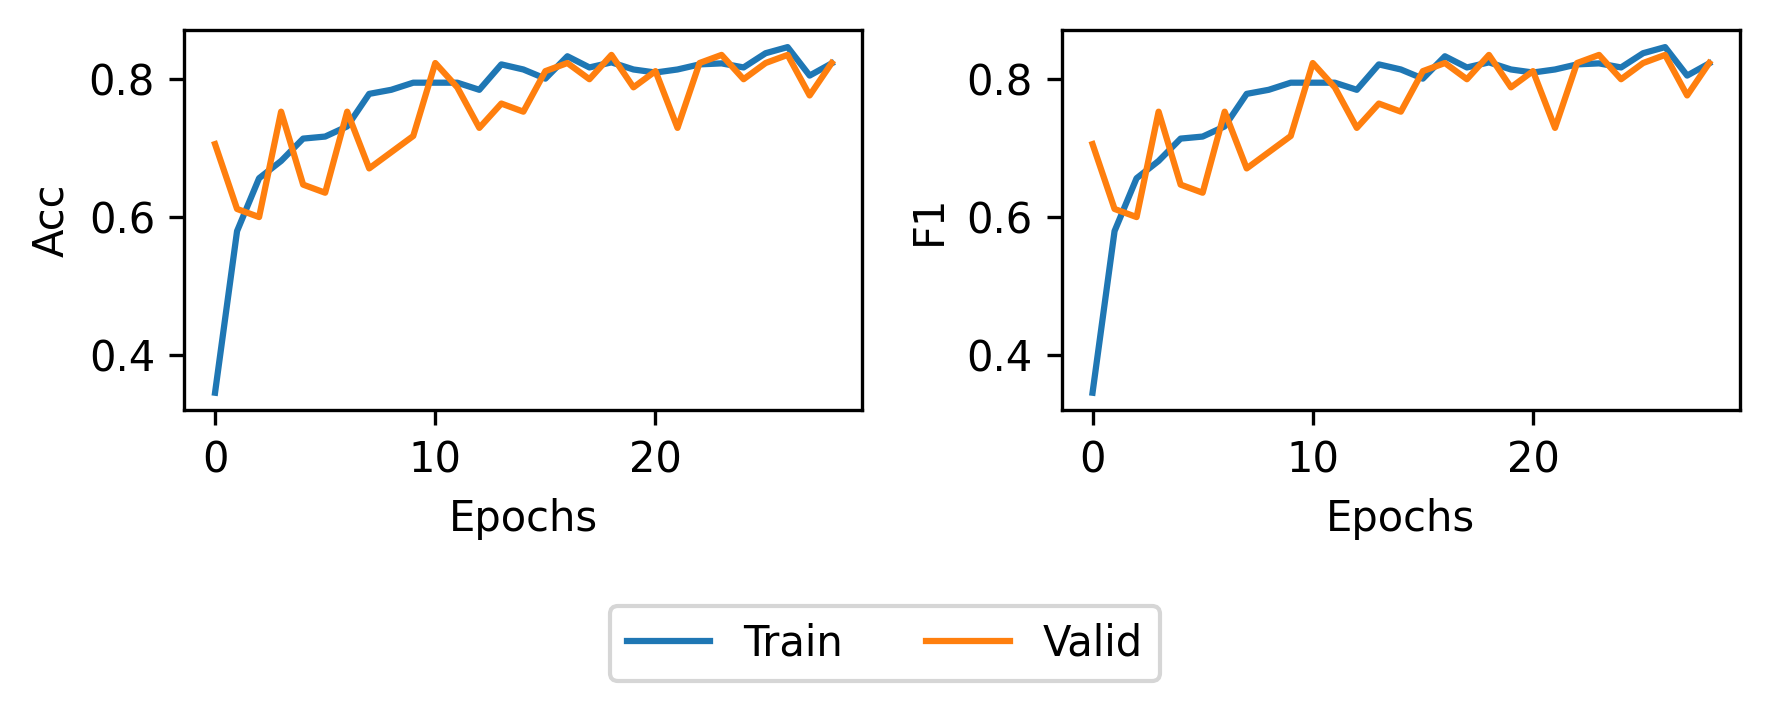

Current Param: {'intermediate_width': 128, 'num_hidden_layers': 2}, Best Valid Acc: 0.84706, Lastest Valid Acc: 0.83529:  67%|██████▋   | 6/9 [02:58<01:34, 31.45s/it]

{'intermediate_width': 128, 'num_hidden_layers': 2}


=== Epoch 0, Time Taken: 1.3s, Time Left: 649.0s ===
- Train: Acc: 0.55900, F1: 0.55900
- Valid: Acc: 0.71765, F1: 0.71765


=== Epoch 1, Time Taken: 1.4s, Time Left: 696.2s ===
- Train: Acc: 0.71829, F1: 0.71829
- Valid: Acc: 0.75294, F1: 0.75294


=== Epoch 2, Time Taken: 1.4s, Time Left: 690.7s ===
- Train: Acc: 0.71681, F1: 0.71681
- Valid: Acc: 0.72941, F1: 0.72941


=== Epoch 3, Time Taken: 1.4s, Time Left: 702.3s ===
- Train: Acc: 0.72861, F1: 0.72861
- Valid: Acc: 0.70588, F1: 0.70588


=== Epoch 4, Time Taken: 1.4s, Time Left: 675.4s ===
- Train: Acc: 0.73746, F1: 0.73746
- Valid: Acc: 0.75294, F1: 0.75294


=== Epoch 5, Time Taken: 1.2s, Time Left: 576.3s ===
- Train: Acc: 0.73746, F1: 0.73746
- Valid: Acc: 0.71765, F1: 0.71765


=== Epoch 6, Time Taken: 1.3s, Time Left: 654.6s ===
- Train: Acc: 0.73451, F1: 0.73451
- Valid: Acc: 0.61176, F1: 0.61176


=== Epoch 7, Time Taken: 1.3s, Time Left: 660.9s ===
- Train: Acc: 0.73304, F1: 0.73304
- Valid: Acc: 0.71765, F1: 0.71765


=== Epoch 8, Time Taken: 1.3s, Time Left: 640.3s ===
- Train: Acc: 0.73894, F1: 0.73894
- Valid: Acc: 0.74118, F1: 0.74118


=== Epoch 9, Time Taken: 1.3s, Time Left: 618.5s ===
- Train: Acc: 0.75074, F1: 0.75074
- Valid: Acc: 0.67059, F1: 0.67059


=== Epoch 10, Time Taken: 1.3s, Time Left: 647.9s ===
- Train: Acc: 0.76696, F1: 0.76696
- Valid: Acc: 0.72941, F1: 0.72941


=== Epoch 11, Time Taken: 1.3s, Time Left: 634.3s ===
- Train: Acc: 0.72714, F1: 0.72714
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 12, Time Taken: 1.4s, Time Left: 664.8s ===
- Train: Acc: 0.76696, F1: 0.76696
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 13, Time Taken: 1.4s, Time Left: 660.3s ===
- Train: Acc: 0.76991, F1: 0.76991
- Valid: Acc: 0.81176, F1: 0.81176


=== Epoch 14, Time Taken: 1.3s, Time Left: 632.6s ===
- Train: Acc: 0.80678, F1: 0.80678
- Valid: Acc: 0.77647, F1: 0.77647


=== Epoch 15, Time Taken: 1.3s, Time Left: 610.9s ===
- Train: Acc: 0.76844, F1: 0.76844
- Valid: Acc: 0.76471, F1: 0.76471


=== Epoch 16, Time Taken: 1.4s, Time Left: 654.2s ===
- Train: Acc: 0.76254, F1: 0.76254
- Valid: Acc: 0.76471, F1: 0.76471


=== Epoch 17, Time Taken: 1.3s, Time Left: 623.7s ===
- Train: Acc: 0.79646, F1: 0.79646
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 18, Time Taken: 1.4s, Time Left: 657.5s ===
- Train: Acc: 0.75811, F1: 0.75811
- Valid: Acc: 0.67059, F1: 0.67059


=== Epoch 19, Time Taken: 1.3s, Time Left: 634.5s ===
- Train: Acc: 0.79646, F1: 0.79646
- Valid: Acc: 0.75294, F1: 0.75294


=== Epoch 20, Time Taken: 1.3s, Time Left: 623.1s ===
- Train: Acc: 0.81858, F1: 0.81858
- Valid: Acc: 0.81176, F1: 0.81176


=== Epoch 21, Time Taken: 1.4s, Time Left: 670.3s ===
- Train: Acc: 0.78909, F1: 0.78909
- Valid: Acc: 0.81176, F1: 0.81176


=== Epoch 22, Time Taken: 1.4s, Time Left: 658.7s ===
- Train: Acc: 0.80973, F1: 0.80973
- Valid: Acc: 0.81176, F1: 0.81176


=== Epoch 23, Time Taken: 1.2s, Time Left: 579.2s ===
- Train: Acc: 0.79646, F1: 0.79646
- Valid: Acc: 0.81176, F1: 0.81176
Early Stopping at Epoch 23, Best Validation Acc (0.81176) at Epoch 13.


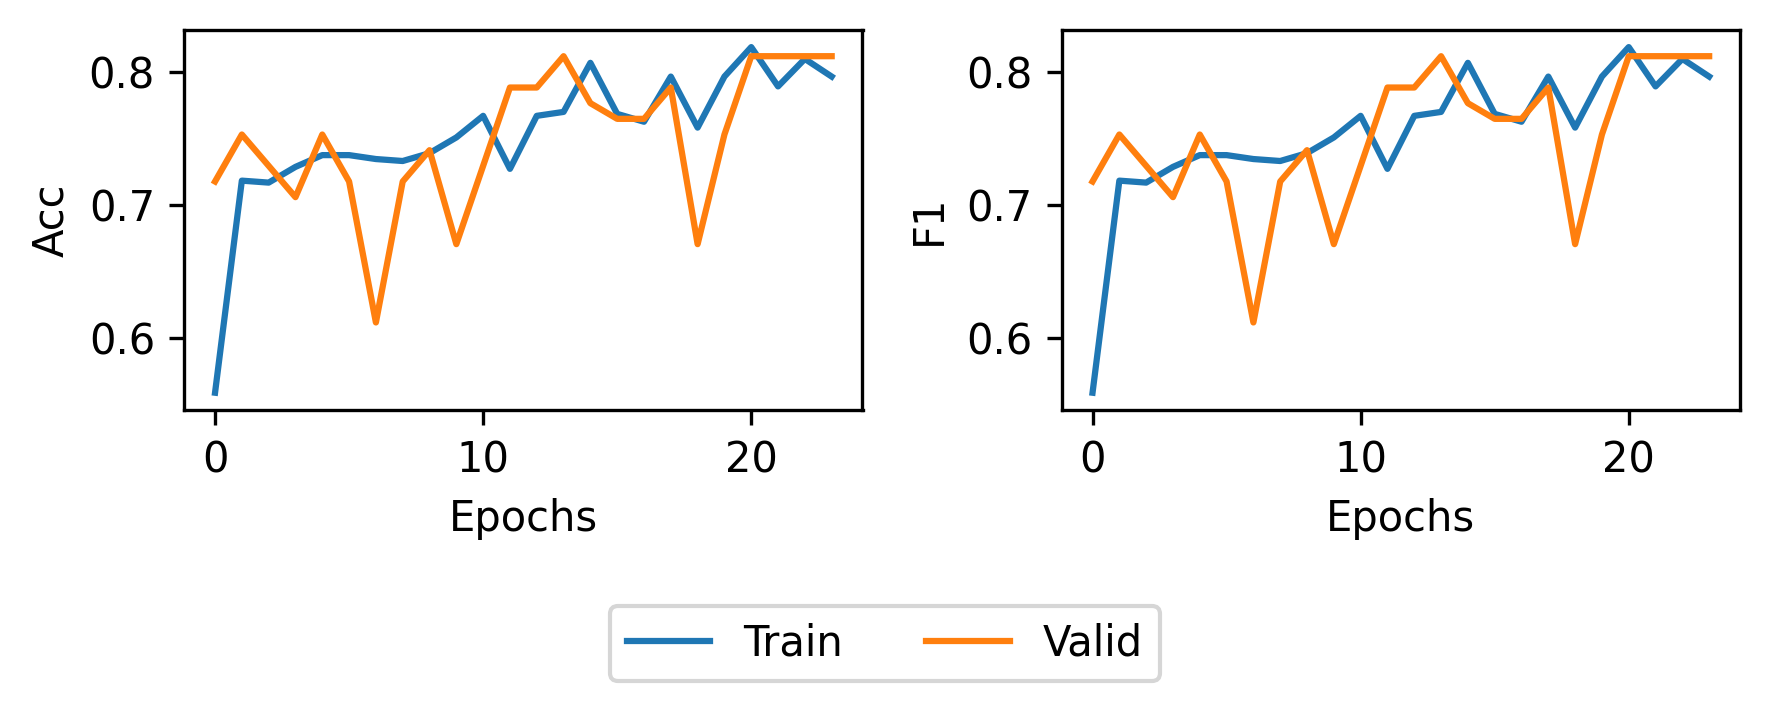

Current Param: {'intermediate_width': 128, 'num_hidden_layers': 3}, Best Valid Acc: 0.84706, Lastest Valid Acc: 0.81176:  78%|███████▊  | 7/9 [03:30<01:03, 31.72s/it]

{'intermediate_width': 128, 'num_hidden_layers': 3}


=== Epoch 0, Time Taken: 1.4s, Time Left: 719.3s ===
- Train: Acc: 0.53392, F1: 0.53392
- Valid: Acc: 0.72941, F1: 0.72941


=== Epoch 1, Time Taken: 1.5s, Time Left: 734.7s ===
- Train: Acc: 0.73156, F1: 0.73156
- Valid: Acc: 0.76471, F1: 0.76471


=== Epoch 2, Time Taken: 1.4s, Time Left: 684.0s ===
- Train: Acc: 0.73599, F1: 0.73599
- Valid: Acc: 0.72941, F1: 0.72941


=== Epoch 3, Time Taken: 1.5s, Time Left: 747.6s ===
- Train: Acc: 0.71386, F1: 0.71386
- Valid: Acc: 0.77647, F1: 0.77647


=== Epoch 4, Time Taken: 1.5s, Time Left: 749.0s ===
- Train: Acc: 0.73599, F1: 0.73599
- Valid: Acc: 0.70588, F1: 0.70588


=== Epoch 5, Time Taken: 1.3s, Time Left: 638.6s ===
- Train: Acc: 0.73451, F1: 0.73451
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 6, Time Taken: 1.4s, Time Left: 698.6s ===
- Train: Acc: 0.72419, F1: 0.72419
- Valid: Acc: 0.76471, F1: 0.76471


=== Epoch 7, Time Taken: 1.4s, Time Left: 702.2s ===
- Train: Acc: 0.75074, F1: 0.75074
- Valid: Acc: 0.75294, F1: 0.75294


=== Epoch 8, Time Taken: 1.4s, Time Left: 695.2s ===
- Train: Acc: 0.75664, F1: 0.75664
- Valid: Acc: 0.76471, F1: 0.76471


=== Epoch 9, Time Taken: 1.6s, Time Left: 785.2s ===
- Train: Acc: 0.78466, F1: 0.78466
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 10, Time Taken: 1.6s, Time Left: 760.3s ===
- Train: Acc: 0.73451, F1: 0.73451
- Valid: Acc: 0.76471, F1: 0.76471


=== Epoch 11, Time Taken: 1.4s, Time Left: 682.3s ===
- Train: Acc: 0.79941, F1: 0.79941
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 12, Time Taken: 1.4s, Time Left: 687.1s ===
- Train: Acc: 0.80088, F1: 0.80088
- Valid: Acc: 0.81176, F1: 0.81176


=== Epoch 13, Time Taken: 1.4s, Time Left: 678.5s ===
- Train: Acc: 0.79204, F1: 0.79204
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 14, Time Taken: 1.5s, Time Left: 732.5s ===
- Train: Acc: 0.80973, F1: 0.80973
- Valid: Acc: 0.76471, F1: 0.76471


=== Epoch 15, Time Taken: 1.4s, Time Left: 699.4s ===
- Train: Acc: 0.82006, F1: 0.82006
- Valid: Acc: 0.56471, F1: 0.56471


=== Epoch 16, Time Taken: 1.5s, Time Left: 706.2s ===
- Train: Acc: 0.80826, F1: 0.80826
- Valid: Acc: 0.81176, F1: 0.81176


=== Epoch 17, Time Taken: 1.4s, Time Left: 696.5s ===
- Train: Acc: 0.82301, F1: 0.82301
- Valid: Acc: 0.80000, F1: 0.80000


=== Epoch 18, Time Taken: 1.5s, Time Left: 731.4s ===
- Train: Acc: 0.82153, F1: 0.82153
- Valid: Acc: 0.82353, F1: 0.82353


=== Epoch 19, Time Taken: 1.5s, Time Left: 726.8s ===
- Train: Acc: 0.82153, F1: 0.82153
- Valid: Acc: 0.71765, F1: 0.71765


=== Epoch 20, Time Taken: 1.6s, Time Left: 753.5s ===
- Train: Acc: 0.80678, F1: 0.80678
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 21, Time Taken: 1.4s, Time Left: 680.8s ===
- Train: Acc: 0.80383, F1: 0.80383
- Valid: Acc: 0.82353, F1: 0.82353


=== Epoch 22, Time Taken: 1.5s, Time Left: 732.1s ===
- Train: Acc: 0.81563, F1: 0.81563
- Valid: Acc: 0.82353, F1: 0.82353


=== Epoch 23, Time Taken: 1.5s, Time Left: 714.1s ===
- Train: Acc: 0.82743, F1: 0.82743
- Valid: Acc: 0.81176, F1: 0.81176


=== Epoch 24, Time Taken: 1.4s, Time Left: 676.9s ===
- Train: Acc: 0.83481, F1: 0.83481
- Valid: Acc: 0.81176, F1: 0.81176


=== Epoch 25, Time Taken: 1.5s, Time Left: 689.6s ===
- Train: Acc: 0.82891, F1: 0.82891
- Valid: Acc: 0.82353, F1: 0.82353


=== Epoch 26, Time Taken: 1.4s, Time Left: 685.1s ===
- Train: Acc: 0.81416, F1: 0.81416
- Valid: Acc: 0.82353, F1: 0.82353


=== Epoch 27, Time Taken: 1.6s, Time Left: 744.0s ===
- Train: Acc: 0.83923, F1: 0.83923
- Valid: Acc: 0.82353, F1: 0.82353


=== Epoch 28, Time Taken: 1.5s, Time Left: 695.9s ===
- Train: Acc: 0.84513, F1: 0.84513
- Valid: Acc: 0.82353, F1: 0.82353
Early Stopping at Epoch 28, Best Validation Acc (0.82353) at Epoch 18.


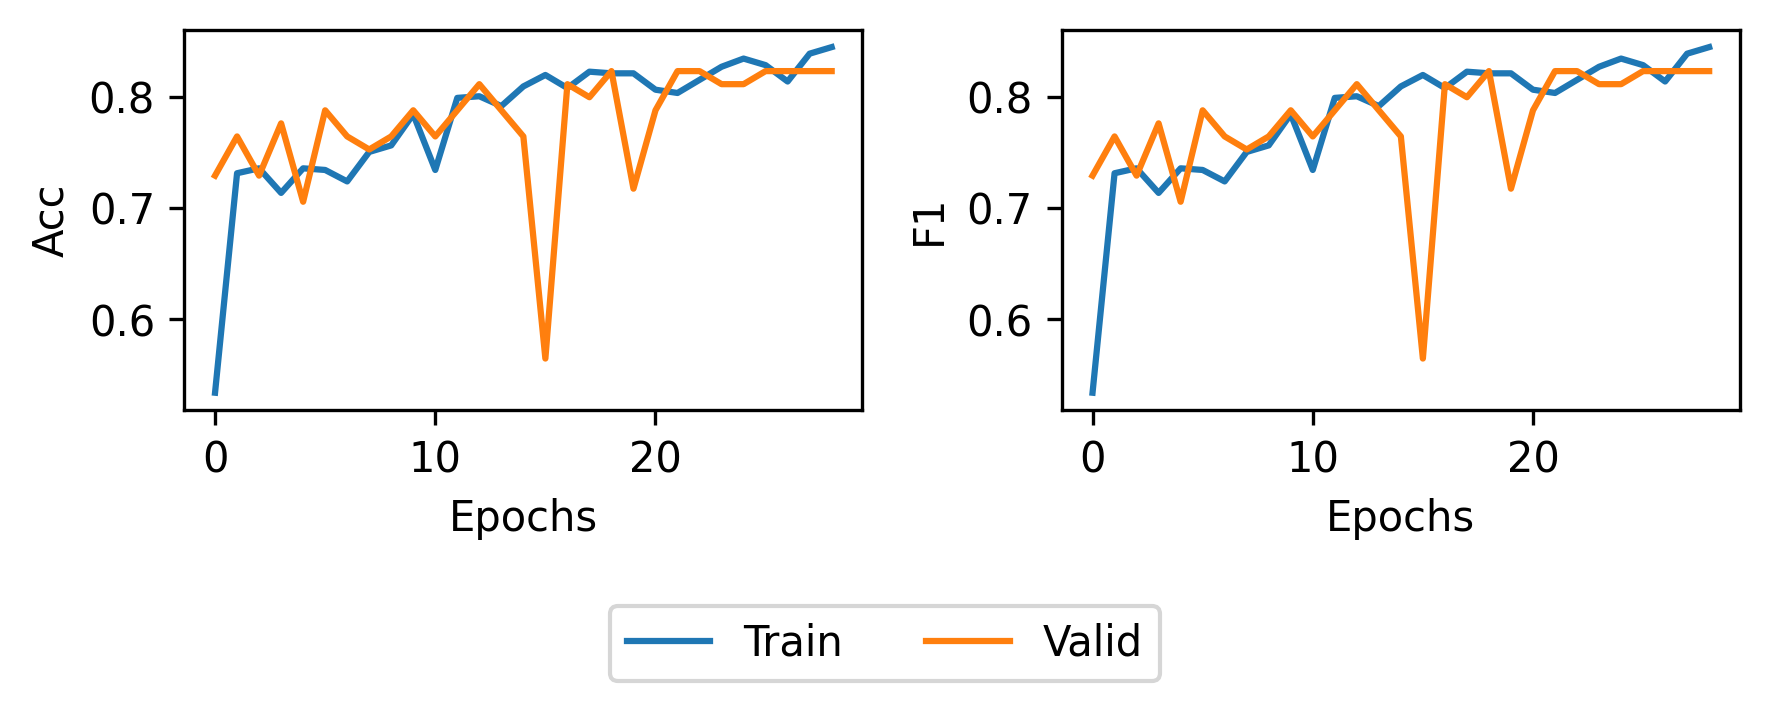

Current Param: {'intermediate_width': 128, 'num_hidden_layers': 4}, Best Valid Acc: 0.84706, Lastest Valid Acc: 0.82353:  89%|████████▉ | 8/9 [04:13<00:35, 35.30s/it]

{'intermediate_width': 128, 'num_hidden_layers': 4}


=== Epoch 0, Time Taken: 1.7s, Time Left: 826.2s ===
- Train: Acc: 0.48525, F1: 0.48525
- Valid: Acc: 0.67059, F1: 0.67059


=== Epoch 1, Time Taken: 1.6s, Time Left: 814.6s ===
- Train: Acc: 0.69027, F1: 0.69027
- Valid: Acc: 0.68235, F1: 0.68235


=== Epoch 2, Time Taken: 1.8s, Time Left: 870.1s ===
- Train: Acc: 0.70501, F1: 0.70501
- Valid: Acc: 0.67059, F1: 0.67059


=== Epoch 3, Time Taken: 1.5s, Time Left: 760.3s ===
- Train: Acc: 0.70354, F1: 0.70354
- Valid: Acc: 0.72941, F1: 0.72941


=== Epoch 4, Time Taken: 1.5s, Time Left: 737.9s ===
- Train: Acc: 0.73156, F1: 0.73156
- Valid: Acc: 0.71765, F1: 0.71765


=== Epoch 5, Time Taken: 1.5s, Time Left: 740.7s ===
- Train: Acc: 0.72566, F1: 0.72566
- Valid: Acc: 0.75294, F1: 0.75294


=== Epoch 6, Time Taken: 1.4s, Time Left: 697.0s ===
- Train: Acc: 0.71534, F1: 0.71534
- Valid: Acc: 0.74118, F1: 0.74118


=== Epoch 7, Time Taken: 1.6s, Time Left: 800.8s ===
- Train: Acc: 0.75369, F1: 0.75369
- Valid: Acc: 0.58824, F1: 0.58824


=== Epoch 8, Time Taken: 1.5s, Time Left: 715.3s ===
- Train: Acc: 0.74631, F1: 0.74631
- Valid: Acc: 0.75294, F1: 0.75294


=== Epoch 9, Time Taken: 1.6s, Time Left: 808.1s ===
- Train: Acc: 0.77434, F1: 0.77434
- Valid: Acc: 0.72941, F1: 0.72941


=== Epoch 10, Time Taken: 1.7s, Time Left: 810.2s ===
- Train: Acc: 0.74926, F1: 0.74926
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 11, Time Taken: 1.6s, Time Left: 761.4s ===
- Train: Acc: 0.78024, F1: 0.78024
- Valid: Acc: 0.71765, F1: 0.71765


=== Epoch 12, Time Taken: 1.5s, Time Left: 707.6s ===
- Train: Acc: 0.78614, F1: 0.78614
- Valid: Acc: 0.80000, F1: 0.80000


=== Epoch 13, Time Taken: 1.6s, Time Left: 775.8s ===
- Train: Acc: 0.81416, F1: 0.81416
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 14, Time Taken: 1.7s, Time Left: 816.1s ===
- Train: Acc: 0.81858, F1: 0.81858
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 15, Time Taken: 1.5s, Time Left: 738.7s ===
- Train: Acc: 0.82743, F1: 0.82743
- Valid: Acc: 0.80000, F1: 0.80000


=== Epoch 16, Time Taken: 1.5s, Time Left: 736.7s ===
- Train: Acc: 0.81563, F1: 0.81563
- Valid: Acc: 0.81176, F1: 0.81176


=== Epoch 17, Time Taken: 1.5s, Time Left: 705.1s ===
- Train: Acc: 0.82448, F1: 0.82448
- Valid: Acc: 0.75294, F1: 0.75294


=== Epoch 18, Time Taken: 1.0s, Time Left: 504.5s ===
- Train: Acc: 0.81121, F1: 0.81121
- Valid: Acc: 0.71765, F1: 0.71765


=== Epoch 19, Time Taken: 1.5s, Time Left: 734.0s ===
- Train: Acc: 0.81711, F1: 0.81711
- Valid: Acc: 0.82353, F1: 0.82353


=== Epoch 20, Time Taken: 1.1s, Time Left: 531.5s ===
- Train: Acc: 0.84366, F1: 0.84366
- Valid: Acc: 0.74118, F1: 0.74118


=== Epoch 21, Time Taken: 1.1s, Time Left: 536.2s ===
- Train: Acc: 0.80236, F1: 0.80236
- Valid: Acc: 0.81176, F1: 0.81176


=== Epoch 22, Time Taken: 1.1s, Time Left: 512.8s ===
- Train: Acc: 0.83628, F1: 0.83628
- Valid: Acc: 0.80000, F1: 0.80000


=== Epoch 23, Time Taken: 1.1s, Time Left: 545.7s ===
- Train: Acc: 0.80678, F1: 0.80678
- Valid: Acc: 0.82353, F1: 0.82353


=== Epoch 24, Time Taken: 1.2s, Time Left: 552.5s ===
- Train: Acc: 0.83038, F1: 0.83038
- Valid: Acc: 0.81176, F1: 0.81176


=== Epoch 25, Time Taken: 1.2s, Time Left: 579.1s ===
- Train: Acc: 0.82743, F1: 0.82743
- Valid: Acc: 0.81176, F1: 0.81176


=== Epoch 26, Time Taken: 1.1s, Time Left: 536.2s ===
- Train: Acc: 0.83481, F1: 0.83481
- Valid: Acc: 0.83529, F1: 0.83529


=== Epoch 27, Time Taken: 1.3s, Time Left: 613.0s ===
- Train: Acc: 0.83628, F1: 0.83628
- Valid: Acc: 0.77647, F1: 0.77647


=== Epoch 28, Time Taken: 1.1s, Time Left: 540.0s ===
- Train: Acc: 0.80973, F1: 0.80973
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 29, Time Taken: 1.2s, Time Left: 548.4s ===
- Train: Acc: 0.82448, F1: 0.82448
- Valid: Acc: 0.76471, F1: 0.76471


=== Epoch 30, Time Taken: 1.1s, Time Left: 523.0s ===
- Train: Acc: 0.84218, F1: 0.84218
- Valid: Acc: 0.81176, F1: 0.81176


=== Epoch 31, Time Taken: 1.3s, Time Left: 626.1s ===
- Train: Acc: 0.81416, F1: 0.81416
- Valid: Acc: 0.82353, F1: 0.82353


=== Epoch 32, Time Taken: 1.2s, Time Left: 541.8s ===
- Train: Acc: 0.82891, F1: 0.82891
- Valid: Acc: 0.70588, F1: 0.70588


=== Epoch 33, Time Taken: 1.3s, Time Left: 599.0s ===
- Train: Acc: 0.82743, F1: 0.82743
- Valid: Acc: 0.77647, F1: 0.77647


=== Epoch 34, Time Taken: 1.2s, Time Left: 547.9s ===
- Train: Acc: 0.84218, F1: 0.84218
- Valid: Acc: 0.80000, F1: 0.80000


=== Epoch 35, Time Taken: 1.2s, Time Left: 541.9s ===
- Train: Acc: 0.81711, F1: 0.81711
- Valid: Acc: 0.82353, F1: 0.82353


=== Epoch 36, Time Taken: 1.4s, Time Left: 634.6s ===
- Train: Acc: 0.84366, F1: 0.84366
- Valid: Acc: 0.78824, F1: 0.78824
Early Stopping at Epoch 36, Best Validation Acc (0.83529) at Epoch 26.


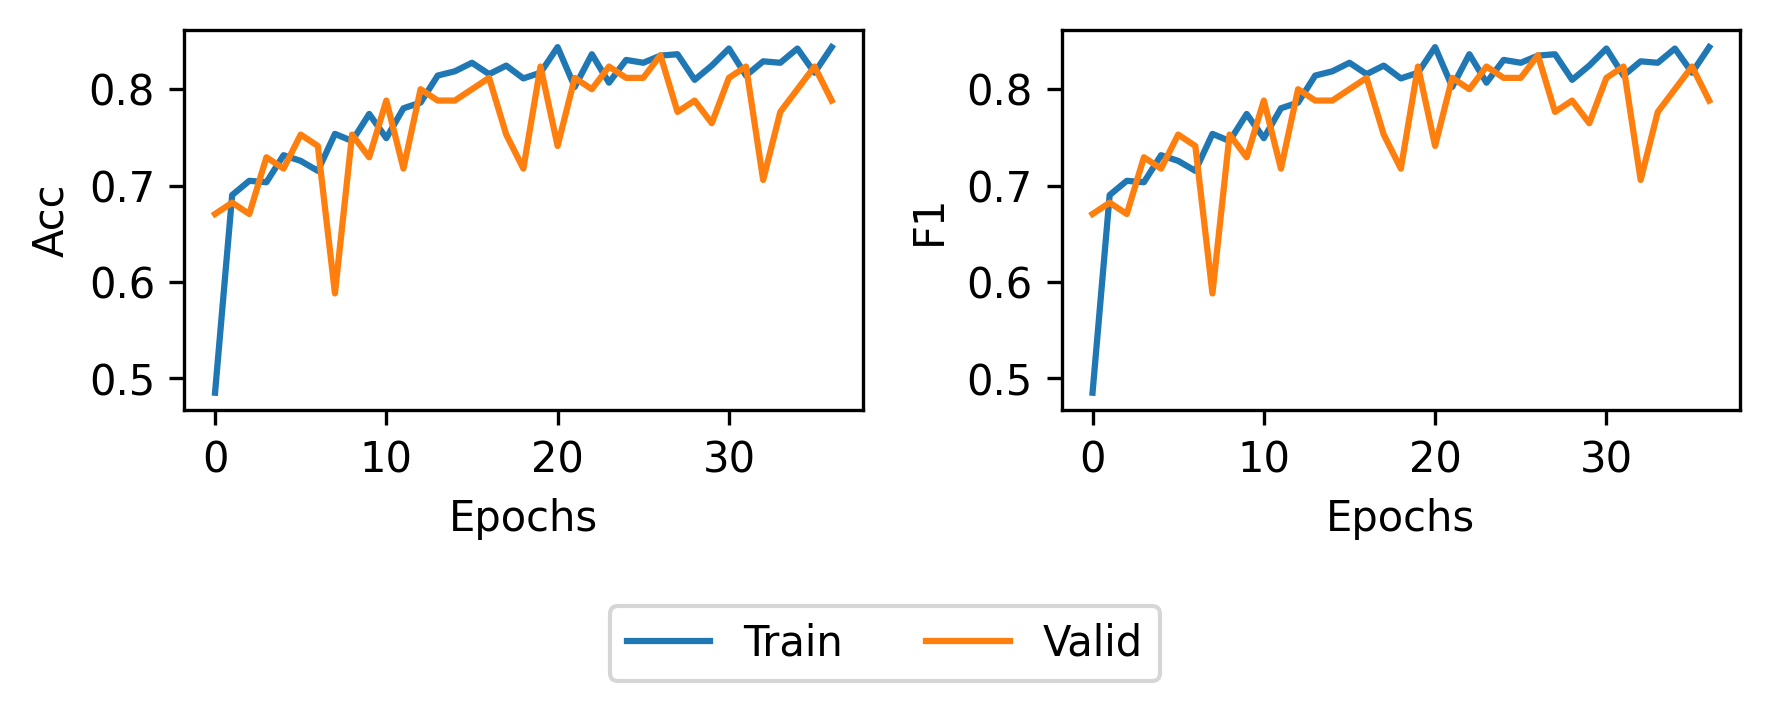

Current Param: {'intermediate_width': 128, 'num_hidden_layers': 4}, Best Valid Acc: 0.84706, Lastest Valid Acc: 0.82353: 100%|██████████| 9/9 [05:05<00:00, 33.91s/it]


In [17]:
tuning_df, best_param = tune_model(
    param_grid={
        "num_hidden_layers":[2, 3, 4], 
        "intermediate_width":[32, 64, 128], 
    }, **params
)

In [18]:
display(tuning_df)
print(best_param)

,intermediate_width,num_hidden_layers,Epochs,Train Acc,Train F1,Valid Acc,Valid F1,Time/s,best_hyperparameter
0,32,2,10,0.802360,0.802360,0.823529,0.823529,24.511919,False
1,32,3,13,0.815634,0.815634,0.835294,0.835294,28.969117,False
2,32,4,12,0.802360,0.802360,0.823529,0.823529,26.678854,False
3,64,2,19,0.808260,0.808260,0.835294,0.835294,36.064476,False
4,64,3,10,0.808260,0.808260,0.847059,0.847059,25.905749,True
5,64,4,18,0.824484,0.824484,0.835294,0.835294,36.449211,False
6,128,2,13,0.769912,0.769912,0.811765,0.811765,32.263254,False
7,128,3,18,0.821534,0.821534,0.823529,0.823529,42.960271,False
8,128,4,26,0.834808,0.834808,0.835294,0.835294,51.330264,False


{'intermediate_width': 64, 'num_hidden_layers': 3}


#### Training

=== Epoch 0, Time Taken: 1.0s, Time Left: 494.2s ===
- Train: Acc: 0.46755, F1: 0.46755
- Valid: Acc: 0.70588, F1: 0.70588


=== Epoch 1, Time Taken: 0.9s, Time Left: 467.5s ===
- Train: Acc: 0.71681, F1: 0.71681
- Valid: Acc: 0.70588, F1: 0.70588


=== Epoch 2, Time Taken: 0.9s, Time Left: 437.3s ===
- Train: Acc: 0.74041, F1: 0.74041
- Valid: Acc: 0.72941, F1: 0.72941


=== Epoch 3, Time Taken: 0.9s, Time Left: 422.8s ===
- Train: Acc: 0.72861, F1: 0.72861
- Valid: Acc: 0.77647, F1: 0.77647


=== Epoch 4, Time Taken: 0.9s, Time Left: 451.2s ===
- Train: Acc: 0.72714, F1: 0.72714
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 5, Time Taken: 0.9s, Time Left: 438.1s ===
- Train: Acc: 0.77434, F1: 0.77434
- Valid: Acc: 0.81176, F1: 0.81176


=== Epoch 6, Time Taken: 1.0s, Time Left: 474.8s ===
- Train: Acc: 0.78466, F1: 0.78466
- Valid: Acc: 0.82353, F1: 0.82353


=== Epoch 7, Time Taken: 1.0s, Time Left: 493.9s ===
- Train: Acc: 0.77581, F1: 0.77581
- Valid: Acc: 0.78824, F1: 0.78824


=== Epoch 8, Time Taken: 0.9s, Time Left: 443.4s ===
- Train: Acc: 0.77581, F1: 0.77581
- Valid: Acc: 0.80000, F1: 0.80000


=== Epoch 9, Time Taken: 1.0s, Time Left: 486.9s ===
- Train: Acc: 0.78171, F1: 0.78171
- Valid: Acc: 0.81176, F1: 0.81176


=== Epoch 10, Time Taken: 0.9s, Time Left: 442.7s ===
- Train: Acc: 0.80826, F1: 0.80826
- Valid: Acc: 0.84706, F1: 0.84706


=== Epoch 11, Time Taken: 0.9s, Time Left: 432.1s ===
- Train: Acc: 0.81563, F1: 0.81563
- Valid: Acc: 0.82353, F1: 0.82353


=== Epoch 12, Time Taken: 0.9s, Time Left: 430.1s ===
- Train: Acc: 0.77581, F1: 0.77581
- Valid: Acc: 0.77647, F1: 0.77647


=== Epoch 13, Time Taken: 1.0s, Time Left: 467.7s ===
- Train: Acc: 0.81268, F1: 0.81268
- Valid: Acc: 0.83529, F1: 0.83529


=== Epoch 14, Time Taken: 0.9s, Time Left: 420.1s ===
- Train: Acc: 0.79056, F1: 0.79056
- Valid: Acc: 0.80000, F1: 0.80000


=== Epoch 15, Time Taken: 1.0s, Time Left: 464.6s ===
- Train: Acc: 0.80973, F1: 0.80973
- Valid: Acc: 0.82353, F1: 0.82353


=== Epoch 16, Time Taken: 1.0s, Time Left: 460.1s ===
- Train: Acc: 0.82448, F1: 0.82448
- Valid: Acc: 0.81176, F1: 0.81176


=== Epoch 17, Time Taken: 0.9s, Time Left: 452.6s ===
- Train: Acc: 0.82596, F1: 0.82596
- Valid: Acc: 0.82353, F1: 0.82353


=== Epoch 18, Time Taken: 0.9s, Time Left: 447.9s ===
- Train: Acc: 0.80383, F1: 0.80383
- Valid: Acc: 0.81176, F1: 0.81176


=== Epoch 19, Time Taken: 0.9s, Time Left: 424.2s ===
- Train: Acc: 0.80973, F1: 0.80973
- Valid: Acc: 0.82353, F1: 0.82353


=== Epoch 20, Time Taken: 0.9s, Time Left: 454.5s ===
- Train: Acc: 0.81563, F1: 0.81563
- Valid: Acc: 0.81176, F1: 0.81176
Early Stopping at Epoch 20, Best Validation Acc (0.84706) at Epoch 10.


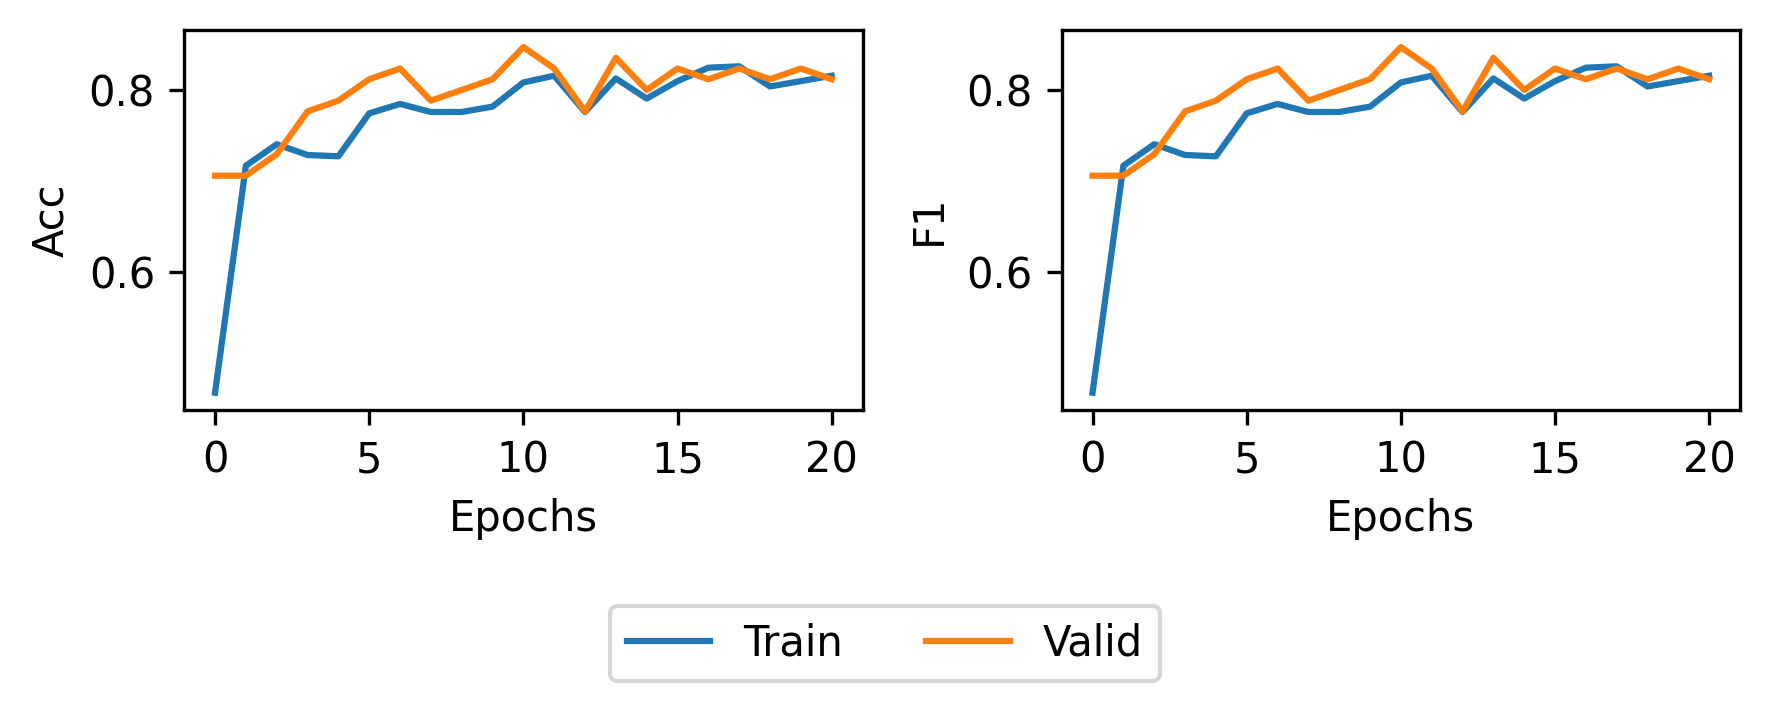

In [ ]:
best_param = {'intermediate_width': 64, 'num_hidden_layers': 3}
mlp_bilateral = train_model_w_best_param(
    **params, best_param=best_param,  
)

In [24]:
pred_df, perf_df = evaluate_baseline_bilteral_models(
    data_dfs=data_dfs_ordinal, col_info=col_info_ordinal, model=mlp_bilateral, 
    batch_size=batch_size, eval_batch_size=batch_size*4, seed=seed_no
)
perf_df

,train,valid,test
Accuracy,0.855,0.847,0.871
Accuracy Total_Time >= 1.0,0.000,0.000,NaN
Accuracy Total_Time >= 13.0,0.225,0.273,0.333
Accuracy Total_Time >= 26.0,0.978,0.964,0.963
Accuracy Total_Time >= 4.33,0.915,0.600,0.875
Accuracy Total_Time >= 52.0,0.997,1.000,0.974
Total_Time >= 1.0 Proportion,0.004,0.002,0.000
Total_Time >= 13.0 Proportion,0.131,0.013,0.014
Total_Time >= 26.0 Proportion,0.215,0.033,0.032
Total_Time >= 4.33 Proportion,0.055,0.006,0.009
